In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import sys
#!{sys.executable} -m pip install openpyxl
#import sys
#!{sys.executable} -m pip install --upgrade pandas
# Not able to upgrade pandas or openpyxl on server so we use a .xls file instead

## Load data

In [19]:
# Set the results directory
directory = 'M:/Current-Users/Michalis-Hadjikakou/Food_Meta_analysis_Enayat/Results/'

#'N:/Planet-A/Current-Users/Michalis-Hadjikakou/Food_Meta_analysis_Enayat/Results/'

boundaries = ['Biogeochemical_Flows', 'Climate_Change', 'Freshwater_Use', 'Land_system_change']

# These are for correcting the names in plots
boundaries_name = {'Biogeochemical_Flows': 'Biogeochemical Flows', 'Climate_Change':'Climate Change', 
                   'Freshwater_Use':'Freshwater Use', 'Land_system_change':'Land System Change', 'all_boundaries':'All Boundaries'}
solutions_name = {'Pop_levels':'Population',  'Diet':'Diet', 'Plant_kcal':'Plant kcal', 'Waste':'Waste',  'Yield_levels':'Yield',  'Feed_efficiency':'Feed efficiency',  
                  'Feed_composition':'Feed composition',  'WUEinc': 'Water-use efficiency', 'Carbon_price':'Carbon price',  'N_management':'N management'}
risk_colour = {'RED':'red', 'ORANGE':'orange', 'YELLOW':'#ffe66d', 'GREEN': 'green'}
risk_label = {'RED':'Very high risk', 'ORANGE':'High risk', 'YELLOW':'Moderate risk', 'GREEN': 'Safe'}

#indicators = ['CH4', 'CO2_LUC', 'N2O', 'Nfert','Pfert', 'Psurplus', 'Nsurplus', 'Cropland','Pasture', 'Water']

# Introduce penalty for very increasing ambition
penalty = 'no'

# Create an empty dictionary to record results per each boundary and each indicator in a dataframe
results_dict = {}

results_dict_ind = {}

# Read the boundary-level results
for b in boundaries:
    results_dict[b] = pd.read_csv(directory+b+'_2022-05-18.csv', converters={'Plant_kcal':str,'Carbon_price':str, 'Yield_levels':str, 'WUEinc':str})
    results_dict[b] = results_dict[b].drop(columns=['Unnamed: 0', 'System']) # Drop unnecessary columns
    results_dict[b]['Pop_levels'] = results_dict[b]['Pop_levels'].round(decimals = 1) # Rounding to one decimal place
    
# Adding min/max/mode for climate change assuming 95th percentile (2*SD) as min/max and mean as mode
results_dict['Climate_Change']['Mode']= results_dict['Climate_Change']['Mean']
results_dict['Climate_Change']['Min']= results_dict['Climate_Change']['Mean'] - results_dict['Climate_Change']['SD']*2
results_dict['Climate_Change']['Max']= results_dict['Climate_Change']['Mean'] + results_dict['Climate_Change']['SD']*2

# Read the indicator-level results
#for i in indicators:
    #results_dict_ind[i] = pd.read_csv(directory+i+'_2021-12-07.csv', converters={'Pop_levels':str,'C_price':str, 'Carbon_price':str, 'Yield_levels':str, 'WUEinc':str})
    #results_dict_ind[i] = results_dict_ind[i].drop(columns=['Unnamed: 0']) # Drop unnecessary columns
    
# Read the bounrday's reference levels
ref_levels = pd.read_excel(directory+'New_scenario_levels.xls', sheet_name='Sheet1', 
                           converters={'Plant_kcal':str,'Carbon_price':str, 'Yield_levels':str, 'WUEinc':str})
# Not able to upgrade pandas or openpyxl on server so we use a .xls file instead

ref_levels = ref_levels.drop(columns="P_management") # P_management removed from data.frame as only average N/P risk is plotted
ref_levels['Pop_levels'] = ref_levels['Pop_levels'].round(decimals = 1) # Rounding to one decimal place

if penalty=='yes':
    ref_levels['Trend_deviation'] = [-1,0,1,4]

# Create a list of all solutions
solutions = list(ref_levels)
del solutions[:2]
#solutions.remove('P_management') # Removing solutions associated with P since only aggregated boundary used

In [20]:
# For example, I call the results for Biogeochemical_Flows_N
pd.unique(results_dict['Biogeochemical_Flows']['N_management'])

array(['Current', '+10% NUE,+10% REC', '+20% NUE,+20% REC',
       '+30% NUE,30% REC'], dtype=object)

In [21]:
pd.unique(results_dict['Land_system_change']['Pop_levels'])

array([ 8.5,  8.9,  9.7, 10.6])

In [24]:
ref_levels

,Level,Trend_deviation,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management
0,Low,-1,10.6,RICH DIET,2900,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,0,Current
1,Medium,0,9.7,BAU DIET,2700,Current,1.3,TREND,TREND,0.1,25,"+10% NUE,+10% REC"
2,High,1,8.9,REDUCED MEAT,2500,BAU_Low,1.45,ACCELERATED,INTENSIFIED,0.2,100,"+20% NUE,+20% REC"
3,Very High,2,8.5,LOW ASF,2300,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.3,200,"+30% NUE,30% REC"


## Compute solution ambitions based on BAU deviation and average risk across all boundaries

In [25]:
# The first step to find the Pareto scenarios is to calculate the average solution ambition and risk across all boundaries combined. 
# The solution ambition levels are categorical in the datasets. Using this categorical value and in each scenario,
# we measure the unit of deviation from trend per each solution and take the average of all deviations 
# to come up with a single number solution ambition value per scenario. 
# We also take an average for risk across all boundaries. This process is implemented as follows. 

# First, compute ambition of levels of solutions related to each boundary
# temp_results_dict is the same as results_dict, but it has new column for average ambitions and riska cross all bourndaries and the same per each boundary., . 
temp_results_dict2 = {}
for b in boundaries:
    temp_results_dict2[b] = results_dict[b].copy() # A new dataframe for each boundary with a new column for trend deviation
    temp_results_dict2[b].rename(columns={'Risk': 'Risk_'+b}, inplace=True)
    temp_results_dict2[b].rename(columns={'RiskCol': 'RiskCol_'+b}, inplace=True)
    temp_results_dict2[b].rename(columns={'Pred_avg': 'Pred_avg_'+b}, inplace=True)
    temp_results_dict2[b].rename(columns={'Max': 'Max_'+b}, inplace=True)
    temp_results_dict2[b].rename(columns={'Min': 'Min_'+b}, inplace=True)
    temp_results_dict2[b].rename(columns={'Mode': 'Mode_'+b}, inplace=True)
    temp_results_dict2[b].rename(columns={'Pred_SD': 'Pred_SD_'+b}, inplace=True)
    

# Find solutions in each boundary as a list. Add to it the Risk of each boundary too.
solrisk_dict = {}
for b in boundaries:
    solrisk_dict[b] = []
    for s, solution in enumerate(solutions):
        if solution in list(results_dict[b]):
            solrisk_dict[b].append(solution)
    solrisk_dict[b] = solrisk_dict[b]+['Risk_'+b, 'RiskCol_'+b, 'Pred_avg_'+b, 'Max_'+b, 'Min_'+b, 'Mode_'+b, 'Pred_SD_'+b]
    


# Turn each solution level from the scenario framework into a dictionary.
sol_dev = {}
for s in solutions:
    sol_dev[s] = ref_levels.set_index(s).to_dict()['Trend_deviation']
    

# Map the solution level names in pandas column with the generated dict. This well generate dataframe with ambition per boundary
sol_dict = {} # a dictionary which entails the list all solution in each boundary
for b in boundaries:
    sol_dict[b] = list(set(solrisk_dict[b])-set(['Risk_'+b, 'RiskCol_'+b, 'Pred_avg_'+b, 
                                                 'Max_'+b, 'Min_'+b, 'Mode_'+b, 'Pred_SD_'+b]))
    for s in sol_dict[b]:
        temp_results_dict2[b][s] = temp_results_dict2[b][s].map(sol_dev[s])    
    temp_results_dict2[b]['Ambition_'+b] = temp_results_dict2[b][sol_dict[b]].mean(axis=1)
    
    
print('Each boundary scenario ambitions computed')


    
# Second, combine all per boundary dataframes to calculate avergae risk and ambition across all boundaries.
# Find common solution columns between all dataframes. This will be needed to merge all boundary scenarios  on common solutions
gen_col = ['Max', 'Min', 'Risk', 'Mode','RiskCol','Pred_SD', 'Pred_avg']
comm_sol = list(set(list(set(results_dict['Biogeochemical_Flows']) #& set(results_dict['Biogeochemical_Flows_P']) 
     & set(results_dict['Climate_Change']) & set(results_dict['Freshwater_Use']) 
     & set(results_dict['Land_system_change'])))-set(gen_col))
    
    
# Combine scenarios from all boudnaries and merge them on their common solution colums. It's not the most effieict way, 
# But the boundary darafarems need to be merged one by one as the common solutions between them are differnet. 

# Add ambition per boundary to the list of columns to be integrated.
for b in boundaries:
    solrisk_dict[b].append('Ambition_'+b)


All_results_dict = temp_results_dict2['Biogeochemical_Flows'][solrisk_dict['Biogeochemical_Flows']]
#All_results_dict = pd.merge(temp_results_dict2['Biogeochemical_Flows_N'][solrisk_dict['Biogeochemical_Flows_N']], 
#                            temp_results_dict2['Biogeochemical_Flows_P'][solrisk_dict['Biogeochemical_Flows_P']], 
#                            how='left', on=comm_sol)
#print('Biogeochemical_Flows_N and Biogeochemical_Flows_P combined')

All_results_dict = pd.merge(All_results_dict, 
                            temp_results_dict2['Freshwater_Use'][solrisk_dict['Freshwater_Use']], 
                            how='left', on=comm_sol)

print('Freshwater_Use combined')


All_results_dict = pd.merge(All_results_dict, 
                            temp_results_dict2['Land_system_change'][solrisk_dict['Land_system_change']], 
                            how='left', on=comm_sol)
print('Land_system_change combined')


All_results_dict = pd.merge(All_results_dict, 
                            temp_results_dict2['Climate_Change'][solrisk_dict['Climate_Change']], 
                            how='left', on=comm_sol)

# Carbon price no longer a matching variable
#+['Carbon_price'])

print('Climate_Change combined')


# Compute averege ambition and risk across all boundaries and in each individual boundary as new columns
All_results_dict['Ambition_all_boundaries'] = All_results_dict[solutions].mean(axis=1)

all_risk_list = []
for b in boundaries:
    all_risk_list.append('Risk_'+b) 

All_results_dict['Risk_all_boundaries'] = All_results_dict[all_risk_list].mean(axis=1)

print('All boundary scenario ambitions computed')


# Remap the all results dataframe solution ambition values back to their original level names
inv_sol_dev = {}
for s in solutions:
    inv_sol_dev[s] = {v: k for k, v in sol_dev[s].items()} 
    All_results_dict[s] = All_results_dict[s].map(inv_sol_dev[s])
    
for b in boundaries:
    for s in sol_dict[b]:
        temp_results_dict2[b][s] = temp_results_dict2[b][s].map(inv_sol_dev[s])
    
print('Scenario ambition numbers were mapped back to their original level names')
    
# Reorder the columns
all_cols_list = []
for b in boundaries:
    all_cols_list.append('Risk_'+b)
    all_cols_list.append('Ambition_'+b)
    all_cols_list.append('RiskCol_'+b)
    all_cols_list.append('Pred_avg_'+b)
    all_cols_list.append('Max_'+b)
    all_cols_list.append('Min_'+b)
    all_cols_list.append('Mode_'+b)
    all_cols_list.append('Pred_SD_'+b)
    
    
All_results_dict = All_results_dict[solutions+all_cols_list+['Risk_all_boundaries', 'Ambition_all_boundaries']]



Each boundary scenario ambitions computed
Freshwater_Use combined
Land_system_change combined
Climate_Change combined
All boundary scenario ambitions computed
Scenario ambition numbers were mapped back to their original level names


In [26]:
All_results_dict

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Risk_Land_system_change,Ambition_Land_system_change,RiskCol_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
0,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,0,Current,...,0.9800,0.000000,RED,5494.746238,5460,3019,3309,470.937526,0.865962,-0.3
1,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,25,Current,...,0.9800,0.000000,RED,5494.746238,5460,3019,3309,470.937526,0.860762,-0.2
2,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,100,Current,...,0.9800,0.000000,RED,5494.746238,5460,3019,3309,470.937526,0.853563,-0.1
3,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,200,Current,...,0.9800,0.000000,RED,5494.746238,5460,3019,3309,470.937526,0.845488,0.0
4,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0.1,0,Current,...,0.9800,0.000000,RED,5494.746238,5460,3019,3309,470.937526,0.817512,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097147,10.6,RICH DIET,2900,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.2,200,"+30% NUE,30% REC",...,0.8145,0.714286,ORANGE,4587.252969,5460,3019,3309,462.806926,0.811713,1.0
2097148,10.6,RICH DIET,2900,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.3,0,"+30% NUE,30% REC",...,0.8145,0.714286,ORANGE,4587.252969,5460,3019,3309,462.806926,0.788337,0.8
2097149,10.6,RICH DIET,2900,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.3,25,"+30% NUE,30% REC",...,0.8145,0.714286,ORANGE,4587.252969,5460,3019,3309,462.806926,0.782212,0.9
2097150,10.6,RICH DIET,2900,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.3,100,"+30% NUE,30% REC",...,0.8145,0.714286,ORANGE,4587.252969,5460,3019,3309,462.806926,0.772912,1.0


In [27]:
pd.unique(All_results_dict['Pop_levels'])

array([ 8.5,  8.9,  9.7, 10.6])

In [28]:
temp_results_dict2['Biogeochemical_Flows']['Pop_levels']

0          8.5
1          8.5
2          8.5
3          8.5
4          8.5
          ... 
131067    10.6
131068    10.6
131069    10.6
131070    10.6
131071    10.6
Name: Pop_levels, Length: 131072, dtype: float64

## Identify the pareto front

In [29]:
# Identify the pareto front
import pareto



p_front = {}
pd_p_front = {}
obj1 = {}
obj2 = {}


# Compute the pareto front for all boundaries based on aggregate risk and ambition and 
# per each boundary based on ambition for solutions of each boundary    
for b in ['all_boundaries']:
    df = All_results_dict
    obj1[b] = df.columns.get_loc("Risk_"+b)   # The column index of risk as objective 1 
    obj2[b] = df.columns.get_loc("Ambition_"+b)   #  The column index of Trend_deviation as objective 2
    np_results_dict = df.to_numpy() # Convert the dataframe to numpy for the pareto.eps_sort function
    p_front[b] = pareto.eps_sort(tables=np_results_dict, objectives=[obj1[b], obj2[b]]) # Pareto front as a 2D list
    pd_p_front[b] = pd.DataFrame(p_front[b], columns=list(df)) # Convert 2D list Pareto front to a dataframe
    
    print(b+' pareto front completed.')
    
for b in boundaries:
    df = temp_results_dict2[b]
    obj1[b] = df.columns.get_loc("Risk_"+b)   # The column index of risk as objective 1 
    obj2[b] = df.columns.get_loc("Ambition_"+b)   #  The column index of Trend_deviation as objective 2
    np_results_dict = df.to_numpy() # Convert the dataframe to numpy for the pareto.eps_sort function
    p_front[b] = pareto.eps_sort(tables=np_results_dict, objectives=[obj1[b], obj2[b]]) # Pareto front as a 2D list
    pd_p_front[b] = pd.DataFrame(p_front[b], columns=list(df)) # Convert 2D list Pareto front to a dataframe
    
    print(b+' pareto front completed.')


all_boundaries pareto front completed.
Biogeochemical_Flows pareto front completed.
Climate_Change pareto front completed.
Freshwater_Use pareto front completed.
Land_system_change pareto front completed.


In [30]:
## Filter scenarios that meet multiple conditions

High_threshold = 0.5
Low_threshold = 0.33

# All scenarios that ensure <0.5 Risk across the boundaries

All_results_reduced_risk = All_results_dict.query('Risk_Climate_Change <= 0.50 & Risk_Land_system_change <= 0.50 & Risk_Biogeochemical_Flows <= 0.50 & Risk_Freshwater_Use <= 0.50')

# All scenarios that ensure <0.4 Risk across the boundaries
All_results_low_risk = All_results_dict.query('Risk_Climate_Change <= 0.40 & Risk_Land_system_change <= 0.33 & Risk_Biogeochemical_Flows <= 0.33 & Risk_Freshwater_Use <= 0.33')

In [404]:
len(All_results_reduced_risk)

6914

In [406]:
len(All_results_low_risk)

120

In [374]:
## Write out complete dictionary for parallel sets
#import feather
#path = 'my_data.feather'
#feather.write_dataframe(df, path)
if penalty=='yes':
    All_results_dict.to_csv('All_merged_scenarios_penalty.csv',index=False)
else:    
    All_results_dict.to_csv('All_merged_scenarios',index=False)


In [340]:
All_results_dict

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Risk_Land_system_change,Ambition_Land_system_change,RiskCol_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
0,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,0,Current,...,0.9800,0.000000,RED,5494.746238,5460,3019,3309,470.937526,0.865962,-0.3
1,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,25,Current,...,0.9800,0.000000,RED,5494.746238,5460,3019,3309,470.937526,0.860762,-0.2
2,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,100,Current,...,0.9800,0.000000,RED,5494.746238,5460,3019,3309,470.937526,0.853563,-0.1
3,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,200,Current,...,0.9800,0.000000,RED,5494.746238,5460,3019,3309,470.937526,0.845488,0.0
4,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0.1,0,Current,...,0.9800,0.000000,RED,5494.746238,5460,3019,3309,470.937526,0.817512,-0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2097147,10.6,RICH DIET,2900,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.2,200,"+30% NUE,30% REC",...,0.8145,0.714286,ORANGE,4587.252969,5460,3019,3309,462.806926,0.811713,1.0
2097148,10.6,RICH DIET,2900,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.3,0,"+30% NUE,30% REC",...,0.8145,0.714286,ORANGE,4587.252969,5460,3019,3309,462.806926,0.788337,0.8
2097149,10.6,RICH DIET,2900,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.3,25,"+30% NUE,30% REC",...,0.8145,0.714286,ORANGE,4587.252969,5460,3019,3309,462.806926,0.782212,0.9
2097150,10.6,RICH DIET,2900,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.3,100,"+30% NUE,30% REC",...,0.8145,0.714286,ORANGE,4587.252969,5460,3019,3309,462.806926,0.772912,1.0


In [409]:
All_results_low_risk.sort_values(by=['Ambition_all_boundaries'])

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Risk_Land_system_change,Ambition_Land_system_change,RiskCol_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
101175,8.5,LOW ASF,2300,Current,1.45,HIGH,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,0.0254,1.142857,GREEN,2651.797763,5460,3019,3309,450.129837,0.247237,1.2
84791,8.5,LOW ASF,2300,BAU_Low,1.45,HIGH,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,0.0193,1.285714,GREEN,2554.136264,5460,3019,3309,487.311692,0.230225,1.3
121655,8.5,LOW ASF,2500,Half,1.45,HIGH,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,0.0178,1.285714,GREEN,2566.083811,5460,3019,3309,472.556821,0.243975,1.3
1133367,8.5,LOW ASF,2300,BAU_Low,1.45,HIGH,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,0.0193,1.285714,GREEN,2554.136264,5460,3019,3309,487.311692,0.237825,1.3
1134390,8.5,LOW ASF,2300,BAU_Low,1.6,HIGH,LOW GRAIN/HIGH GRASS,0.1,100,"+30% NUE,30% REC",...,0.0092,1.428571,GREEN,2432.543247,5460,3019,3309,466.777507,0.240925,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118715,8.5,LOW ASF,2300,Half,1.6,HIGH,INTENSIFIED,0.2,200,"+30% NUE,30% REC",...,0.0100,1.857143,GREEN,2348.108949,5460,3019,3309,480.455483,0.201975,1.8
118718,8.5,LOW ASF,2300,Half,1.6,HIGH,INTENSIFIED,0.3,100,"+30% NUE,30% REC",...,0.0100,1.857143,GREEN,2348.108949,5460,3019,3309,480.455483,0.199200,1.8
116735,8.5,LOW ASF,2300,Half,1.3,HIGH,HIGH GRAIN/LOW GRASS,0.3,200,"+30% NUE,30% REC",...,0.0200,1.714286,GREEN,2612.211781,5460,3019,3309,457.468494,0.191700,1.8
117759,8.5,LOW ASF,2300,Half,1.45,HIGH,HIGH GRAIN/LOW GRASS,0.3,200,"+30% NUE,30% REC",...,0.0105,1.857143,GREEN,2481.852339,5460,3019,3309,447.271719,0.190475,1.9


In [314]:
All_results_reduced_risk.sort_values(by=['Ambition_all_boundaries'])

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Risk_Land_system_change,Ambition_Land_system_change,RiskCol_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
361267,8.9,LOW ASF,2300,Current,1.15,HIGH,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,0.0899,0.714286,YELLOW,3021.271613,5460,3019,3309,464.735665,0.330675,0.8
329523,8.9,LOW ASF,2300,BAU_High,1.3,HIGH,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,0.0772,0.714286,GREEN,2929.732645,5460,3019,3309,485.257523,0.351925,0.8
349747,8.9,LOW ASF,2500,BAU_Low,1.3,ACCELERATED,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,0.1273,0.714286,YELLOW,3118.243254,5460,3019,3309,472.096285,0.371713,0.8
333623,8.9,LOW ASF,2500,BAU_High,1.3,HIGH,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,0.1064,0.571429,YELLOW,3068.180853,5460,3019,3309,459.439519,0.354725,0.8
362035,8.9,LOW ASF,2300,Current,1.3,ACCELERATED,LOW GRAIN/HIGH GRASS,0,200,"+30% NUE,30% REC",...,0.1303,0.714286,YELLOW,3113.082384,5460,3019,3309,466.974291,0.358238,0.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86015,8.5,LOW ASF,2300,BAU_Low,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.3,200,"+30% NUE,30% REC",...,0.0065,1.857143,GREEN,2378.582759,5460,3019,3309,459.589057,0.206562,1.9
380927,8.9,LOW ASF,2300,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.3,200,"+30% NUE,30% REC",...,0.0073,1.857143,GREEN,2389.916472,5460,3019,3309,448.863380,0.205225,1.9
1167295,8.5,LOW ASF,2300,Half,1.6,HIGH,INTENSIFIED,0.3,200,"+30% NUE,30% REC",...,0.0100,1.857143,GREEN,2348.108949,5460,3019,3309,480.455483,0.209625,1.9
118783,8.5,LOW ASF,2300,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.3,200,"+30% NUE,30% REC",...,0.0061,2.000000,GREEN,2330.913418,5460,3019,3309,465.665606,0.191837,2.0


In [288]:
All_results_low_risk.sort_values(by=['Ambition_all_boundaries'])

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Risk_Land_system_change,Ambition_Land_system_change,RiskCol_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
101175,8.5,LOW ASF,2300,Current,1.45,HIGH,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,0.0254,1.142857,GREEN,2651.797763,5460,3019,3309,450.129837,0.247237,1.2
84791,8.5,LOW ASF,2300,BAU_Low,1.45,HIGH,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,0.0193,1.285714,GREEN,2554.136264,5460,3019,3309,487.311692,0.230225,1.3
121655,8.5,LOW ASF,2500,Half,1.45,HIGH,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,0.0178,1.285714,GREEN,2566.083811,5460,3019,3309,472.556821,0.243975,1.3
1133367,8.5,LOW ASF,2300,BAU_Low,1.45,HIGH,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,0.0193,1.285714,GREEN,2554.136264,5460,3019,3309,487.311692,0.237825,1.3
1134390,8.5,LOW ASF,2300,BAU_Low,1.6,HIGH,LOW GRAIN/HIGH GRASS,0.1,100,"+30% NUE,30% REC",...,0.0092,1.428571,GREEN,2432.543247,5460,3019,3309,466.777507,0.240925,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118715,8.5,LOW ASF,2300,Half,1.6,HIGH,INTENSIFIED,0.2,200,"+30% NUE,30% REC",...,0.0100,1.857143,GREEN,2348.108949,5460,3019,3309,480.455483,0.201975,1.8
118718,8.5,LOW ASF,2300,Half,1.6,HIGH,INTENSIFIED,0.3,100,"+30% NUE,30% REC",...,0.0100,1.857143,GREEN,2348.108949,5460,3019,3309,480.455483,0.199200,1.8
116735,8.5,LOW ASF,2300,Half,1.3,HIGH,HIGH GRAIN/LOW GRASS,0.3,200,"+30% NUE,30% REC",...,0.0200,1.714286,GREEN,2612.211781,5460,3019,3309,457.468494,0.191700,1.8
117759,8.5,LOW ASF,2300,Half,1.45,HIGH,HIGH GRAIN/LOW GRASS,0.3,200,"+30% NUE,30% REC",...,0.0105,1.857143,GREEN,2481.852339,5460,3019,3309,447.271719,0.190475,1.9


In [291]:
All_results_low_risk.sort_values(by=['Risk_all_boundaries'])

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Risk_Land_system_change,Ambition_Land_system_change,RiskCol_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
118591,8.5,LOW ASF,2300,Half,1.6,HIGH,LOW GRAIN/HIGH GRASS,0.3,200,"+30% NUE,30% REC",...,0.0104,1.571429,GREEN,2405.845003,5460,3019,3309,482.153201,0.173737,1.7
117567,8.5,LOW ASF,2300,Half,1.45,HIGH,LOW GRAIN/HIGH GRASS,0.3,200,"+30% NUE,30% REC",...,0.0144,1.428571,GREEN,2537.106592,5460,3019,3309,460.107509,0.175338,1.6
1167167,8.5,LOW ASF,2300,Half,1.6,HIGH,LOW GRAIN/HIGH GRASS,0.3,200,"+30% NUE,30% REC",...,0.0104,1.571429,GREEN,2405.845003,5460,3019,3309,482.153201,0.175675,1.7
116543,8.5,LOW ASF,2300,Half,1.3,HIGH,LOW GRAIN/HIGH GRASS,0.3,200,"+30% NUE,30% REC",...,0.0265,1.285714,GREEN,2651.753528,5460,3019,3309,463.777437,0.178700,1.5
118655,8.5,LOW ASF,2300,Half,1.6,HIGH,TREND,0.3,200,"+30% NUE,30% REC",...,0.0051,1.714286,GREEN,2381.801521,5460,3019,3309,428.376777,0.179800,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118710,8.5,LOW ASF,2300,Half,1.6,HIGH,INTENSIFIED,0.1,100,"+30% NUE,30% REC",...,0.0100,1.857143,GREEN,2348.108949,5460,3019,3309,480.455483,0.243450,1.6
121655,8.5,LOW ASF,2500,Half,1.45,HIGH,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,0.0178,1.285714,GREEN,2566.083811,5460,3019,3309,472.556821,0.243975,1.3
85559,8.5,LOW ASF,2300,BAU_Low,1.6,ACCELERATED,LOW GRAIN/HIGH GRASS,0.1,200,"+30% NUE,30% REC",...,0.0306,1.285714,GREEN,2662.036504,5460,3019,3309,481.908266,0.245787,1.3
117431,8.5,LOW ASF,2300,Half,1.45,ACCELERATED,INTENSIFIED,0.1,200,"+30% NUE,30% REC",...,0.0268,1.571429,GREEN,2674.454995,5460,3019,3309,472.707895,0.246512,1.5


In [32]:
list(All_results_dict.columns)

['Pop_levels',
 'Diet',
 'Plant_kcal',
 'Waste',
 'Yield_levels',
 'Feed_efficiency',
 'Feed_composition',
 'WUEinc',
 'Carbon_price',
 'N_management',
 'Risk_Biogeochemical_Flows',
 'Ambition_Biogeochemical_Flows',
 'RiskCol_Biogeochemical_Flows',
 'Pred_avg_Biogeochemical_Flows',
 'Max_Biogeochemical_Flows',
 'Min_Biogeochemical_Flows',
 'Mode_Biogeochemical_Flows',
 'Pred_SD_Biogeochemical_Flows',
 'Risk_Climate_Change',
 'Ambition_Climate_Change',
 'RiskCol_Climate_Change',
 'Pred_avg_Climate_Change',
 'Max_Climate_Change',
 'Min_Climate_Change',
 'Mode_Climate_Change',
 'Pred_SD_Climate_Change',
 'Risk_Freshwater_Use',
 'Ambition_Freshwater_Use',
 'RiskCol_Freshwater_Use',
 'Pred_avg_Freshwater_Use',
 'Max_Freshwater_Use',
 'Min_Freshwater_Use',
 'Mode_Freshwater_Use',
 'Pred_SD_Freshwater_Use',
 'Risk_Land_system_change',
 'Ambition_Land_system_change',
 'RiskCol_Land_system_change',
 'Pred_avg_Land_system_change',
 'Max_Land_system_change',
 'Min_Land_system_change',
 'Mode_Land

In [31]:
# For example, see the pareto scenarios for Biogeochemical_Flows_P
pd_p_front['all_boundaries'] # 'Biogeochemical_Flows,'Climate_Change', 'Freshwater_Use', 'Land_system_change'

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Risk_Land_system_change,Ambition_Land_system_change,RiskCol_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
0,8.5,LOW ASF,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,0,"+30% NUE,30% REC",...,0.4105,0.285714,ORANGE,3734.321781,5460,3019,3309,469.051871,0.494962,0.2
1,8.5,LOW ASF,2300,BAU_Low,1.15,HIGH,LOW GRAIN/HIGH GRASS,0.1,0,"+30% NUE,30% REC",...,0.0613,1.000000,GREEN,2861.392832,5460,3019,3309,477.062165,0.279800,0.8
2,8.5,LOW ASF,2300,BAU_Low,1.15,HIGH,LOW GRAIN/HIGH GRASS,0.2,0,"+30% NUE,30% REC",...,0.0613,1.000000,GREEN,2861.392832,5460,3019,3309,477.062165,0.257800,0.9
3,8.5,LOW ASF,2300,Half,1.15,HIGH,LOW GRAIN/HIGH GRASS,0.2,0,"+30% NUE,30% REC",...,0.0520,1.142857,GREEN,2828.107853,5460,3019,3309,464.079922,0.241038,1.0
4,8.5,LOW ASF,2300,Half,1.15,HIGH,LOW GRAIN/HIGH GRASS,0.2,100,"+30% NUE,30% REC",...,0.0520,1.142857,GREEN,2828.107853,5460,3019,3309,464.079922,0.214088,1.2
5,8.5,LOW ASF,2300,Half,1.15,HIGH,LOW GRAIN/HIGH GRASS,0.2,200,"+30% NUE,30% REC",...,0.0520,1.142857,GREEN,2828.107853,5460,3019,3309,464.079922,0.200388,1.3
6,8.5,LOW ASF,2300,Half,1.15,HIGH,LOW GRAIN/HIGH GRASS,0.3,0,"+30% NUE,30% REC",...,0.0520,1.142857,GREEN,2828.107853,5460,3019,3309,464.079922,0.229938,1.1
7,8.5,LOW ASF,2300,Half,1.15,HIGH,LOW GRAIN/HIGH GRASS,0.3,200,"+30% NUE,30% REC",...,0.0520,1.142857,GREEN,2828.107853,5460,3019,3309,464.079922,0.189288,1.4
8,8.5,LOW ASF,2300,Half,1.3,HIGH,LOW GRAIN/HIGH GRASS,0.3,200,"+30% NUE,30% REC",...,0.0265,1.285714,GREEN,2651.753528,5460,3019,3309,463.777437,0.178700,1.5
9,8.5,LOW ASF,2300,Half,1.45,HIGH,LOW GRAIN/HIGH GRASS,0.3,200,"+30% NUE,30% REC",...,0.0144,1.428571,GREEN,2537.106592,5460,3019,3309,460.107509,0.175338,1.6


## Plot the pareto front (risk-ambition trade-off)

In [ ]:
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.patches import BoxStyle
from matplotlib.lines import Line2D
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import heapq


pd_scenario = {}
pd_scenario2 = {} # pareto scenarios at each risk level

# Create axes
# Create grids and axes
fig = plt.figure(figsize=(20, 20))

# Set the width ratio of subplots (main plot, side plot)
#width_ratios = [2,.25]
grid = plt.GridSpec(3, 3, hspace=0.07, wspace=0.15)

axes = {}

axes['all_boundaries'] = fig.add_subplot(grid[0:2,0:2])
axes['Freshwater_Use'] = fig.add_subplot(grid[2,0])
#axes['Biogeochemical_Flows_P'] = fig.add_subplot(grid[2,1], sharey=axes['Biogeochemical_Flows_N'])
axes['Biogeochemical_Flows'] = fig.add_subplot(grid[2,1], sharey=axes['Freshwater_Use']) 
axes['Land_system_change'] = fig.add_subplot(grid[0,2])#, sharex=axes['Land_system_change'])
axes['Climate_Change'] = fig.add_subplot(grid[1,2], sharex=axes['Land_system_change'])

risk_levels_dict = {50:'High risk', 25:'Moderate risk', 10:'Low risk'}#, 5:'Low risk'}

for i, b in enumerate(['all_boundaries']+boundaries): #

    
    #p_front_x, p_front_y = column(p_front[b], obj1[b]), column(p_front[b], obj2[b])
    p_front_x, p_front_y = list(pd_p_front[b]['Risk_'+b]), list(pd_p_front[b]['Ambition_'+b])
    
    # because all boundaries risk doesn't have risk color, we have to make this conditional term
    if b == 'all_boundaries':
        p_front_c = ['#dcdfe5' for x in list(pd_p_front[b]['RiskCol_Climate_Change'])] # We use RiskCol_Climate_Change just to know the length of the list. The values don't matter as they will be replaced with the same colour  
    else: 
        p_front_c = list(pd_p_front[b]['RiskCol_'+b])
    
    # Derive the representative scenarios from the pareto set bsaed on the most achievabel scenario in all boundaries fin 5, 25, 50, 95% of risk. 

    # First, in the pareto solution set, sort the risk colour and ambition based on the risk value (reverse)
    sorted_p_front_y = [y for _,y in sorted(zip(p_front_x,p_front_y), reverse=True)]
    sorted_p_front_c = [c for _,c in sorted(zip(p_front_x,p_front_c), reverse=True)]
    sorted_p_front_x = sorted(p_front_x, reverse=True)

    # Second, find the 5, 25, 50, 95 percentiles of risk and their equivalent ambition based the all_boundaries dataframe
    for p in list(risk_levels_dict.keys()):
        # This condition is to only use the all_boundaries dataframe for selecting representative scenarios
        if b == 'all_boundaries':
            a = np.array(sorted_p_front_x)
            prc = np.percentile(a,p)
            n = 0
            for itm in sorted_p_front_x:
                if itm<prc and n==0:
                    idx = sorted_p_front_x.index(itm)
                    n += 1
            pd_scenario[(b, risk_levels_dict[p])] = pd_p_front[b].loc[(pd_p_front[b]['Risk_'+b] == sorted_p_front_x[idx]) & (pd_p_front[b]['Ambition_'+b] == sorted_p_front_y[idx])]
        else:
            # We find all individual boundary pareto datafarmes what sceanrios have specific risk and ambition and shared solution values equal to one in the representative scenarios from all_boundarues dataframe
            pd_scenario[(b, risk_levels_dict[p])] = temp_results_dict2[b].loc[(temp_results_dict2[b]['Risk_'+b] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Risk_'+b])[0]) 
                                                                              & (temp_results_dict2[b]['Ambition_'+b] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Ambition_'+b])[0]) 
                                                                              & (temp_results_dict2[b]['Pop_levels'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Pop_levels'])[0]) 
                                                                              & (temp_results_dict2[b]['Diet'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Diet'])[0]) 
                                                                              & (temp_results_dict2[b]['Waste'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Waste'])[0]) 
                                                                              & (temp_results_dict2[b]['Yield_levels'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Yield_levels'])[0]) 
                                                                              & (temp_results_dict2[b]['Feed_efficiency'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Feed_efficiency'])[0]) 
                                                                              & (temp_results_dict2[b]['Feed_composition'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Feed_composition'])[0]) 
                                                                              & (temp_results_dict2[b]['Plant_kcal'] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Plant_kcal'])[0]) 
                                                                              & (temp_results_dict2[b]['Pred_avg_'+b] == list(pd_scenario[('all_boundaries', risk_levels_dict[p])]['Pred_avg_'+b])[0])]
            
            # We remove the name of boundary from the column headers as now we have dataframe per each boundary. This is needed for later dataprocessing in the wheel chart.
            pd_scenario2[(b, risk_levels_dict[p])] = pd_scenario[(b, risk_levels_dict[p])].copy()
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Risk_'+b: 'Risk'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'RiskCol_'+b: 'RiskCol'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Pred_avg_'+b: 'Pred_avg'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Max_'+b: 'Max'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Min_'+b: 'Min'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Mode_'+b: 'Mode'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Pred_SD_'+b: 'Pred_SD'}, inplace=True)
            pd_scenario2[(b, risk_levels_dict[p])].rename(columns={'Ambition_'+b: 'Ambition'}, inplace=True)
            


    # Draw the pareto front
    if b == 'all_boundaries':
        #First, transform single column dataframe to a list
        x_list = All_results_dict['Risk_'+b].tolist()
        y_list = All_results_dict['Ambition_'+b].tolist()
        x_list2 = All_results_reduced_risk['Risk_'+b].tolist()
        y_list2 = All_results_reduced_risk['Ambition_'+b].tolist()
        x_list3 = All_results_low_risk['Risk_'+b].tolist()
        y_list3 = All_results_low_risk['Ambition_'+b].tolist()
        # Adjust the size of markers
        size1 = 3
        size2 = 1.9
    else:
        x_list = temp_results_dict2[b]['Risk_'+b].tolist()
        y_list = temp_results_dict2[b]['Ambition_'+b].tolist()
        x_list2 = All_results_reduced_risk['Risk_'+b].tolist()
        y_list2 = All_results_reduced_risk['Ambition_'+b].tolist()
        x_list3 = All_results_low_risk['Risk_'+b].tolist()
        y_list3 = All_results_low_risk['Ambition_'+b].tolist()
        size1 = 1
        size2 = 1
        
    # Plot all scenarios across subplots
    if b == 'all_boundaries':
        axes[b].scatter(x_list, y_list, color='#dcdfe5', s=12*size1)
        axes[b].scatter(x_list2, y_list2, color='#3288BD', s=12*size1)
        axes[b].scatter(x_list3, y_list3, color='#9E0142', s=12*size1) 
    else:
        axes[b].scatter(x_list, y_list, color='#dcdfe5', s=12*size1)
        axes[b].scatter(x_list2, y_list2, color='#3288BD', s=12*size1)
        axes[b].scatter(x_list3, y_list3, color='#9E0142', s=12*size1) 
    
    # Plot the pareto fronts across all subplots
    #axes[b].scatter(p_front_x, p_front_y, marker='o', color=p_front_c, edgecolor='lightgrey', linewidth=1, s=140*size2)
    axes[b].scatter(p_front_x, p_front_y, marker='o', color='darkgray', edgecolor=None, linewidth=1, s=80*size2)
    
    # Plot representative scenarios in all subplots
#     marker_shape = {'High risk':"D", 'Moderate risk':"s", 'Low risk':'*'}#, 'Low risk':"X"}
#     marker_size = {'High risk':90*size2, 'Moderate risk':90*size2, 'Low risk':250*size2}#, 'Low risk':150*size2}
#     for l in risk_levels_dict.values():
#         axes[b].scatter(list(pd_scenario[('all_boundaries', l)]['Risk_'+b]), 
#                             list(pd_scenario[('all_boundaries', l)]['Ambition_'+b]), 
#                             marker=marker_shape[l], color='none', edgecolor='blue', linewidth=1.4, s=marker_size[l])
        
    if penalty=='yes':
        y_ticks = [-1, 0, 1, 4]
    else:
        y_ticks = [-1, 0, 1, 2]
        
    y_tick_labels = ['Low', 'Trend','High', 'Very\nHigh']
    #x_ticks = np.arange(round(All_results_dict['Risk_'+b].min(),1), 1.1, .2).tolist()
    #x_ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    x_ticks = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    
    axes[b].set_title(boundaries_name[b], y=1.0, fontsize=25, pad=-20)
    
    # Set a consistent range for all y axis
    #axes[b].set_ylim([-1.1, 2.1])
    if penalty=='yes':
        axes[b].set_ylim([-1.1, 4.1])
    else:
        axes[b].set_ylim([-1.1, 2.25])
    # Remove unnecessary ticks and labels
    if b in ['all_boundaries', 'Freshwater_Use']:
        axes[b].yaxis.set_ticks(y_ticks)
        axes[b].set_yticklabels(y_tick_labels, fontsize=16)
    elif b in ['Climate_Change','Land_system_change']:
        axes[b].yaxis.set_ticks(y_ticks)
        axes[b].set_yticklabels(y_tick_labels, fontsize=16)
        #axes[b].set_yticklabels([])
    else:
        axes[b].tick_params(axis='y', direction='out', labelleft=False)

    if b in ['all_boundaries', 'Biogeochemical_Flows', 'Climate_Change',"Freshwater_Use"]:
        #axes[b].tick_params(axis='x', labelsize=13)
        axes[b].xaxis.set_ticks(x_ticks)
    else:
        axes[b].tick_params(axis='x', direction='out', labelbottom=False)
    
    
#     # Print the boundary icon 
#     img_dir = 'M:/Current-Users/Michalis-Hadjikakou/Food_Meta_analysis/Figs/PB_icons/'

#     img = mpimg.imread(img_dir+b+'.png')
#     if b in ['Biogeochemical_Flows_N', 'Biogeochemical_Flows_P']:
#         zoom = .15
#         xloc = 0.08
#     else:
#         zoom = .5
#         xloc = 0.11
        
#     if b in ['all_boundaries']:
#         yloc = 0.15
#     else:
#         yloc = 0.1
#     imagebox = OffsetImage(img, zoom=zoom)
    
#     ab = AnnotationBbox(imagebox, (xloc, yloc), xycoords='axes fraction',  frameon=False)
#     axes[b].add_artist(ab)


    
fig.text(0.5, 0.09, "  ".join('Risk of exceeding environmental limits'), ha='center', fontsize=25)
fig.text(0.08, 0.27, "  ".join('Level of mitigation ambition'), ha='center', fontsize=25, rotation='vertical')


    
# Create legend
legend_elements = []


legend_elements.append(Line2D([0], [0], marker="o", color='none', label='Pareto scenario', 
                                  markersize=12, markeredgecolor='white', markerfacecolor='darkgray', alpha=1))
#mediumpurple
legend_elements.append(Line2D([0], [0], marker="o", color='none', label='Non-Pareto scenario \n (Risk < 0.33 across all boundaries)', 
                                  markersize=9, markeredgecolor='white', markerfacecolor='#9E0142', alpha=1))

legend_elements.append(Line2D([0], [0], marker="o", color='none', label='Non-Pareto scenario \n (Risk < 0.50 across all boundaries)', 
                                  markersize=9, markeredgecolor='white', markerfacecolor='#3288BD', alpha=1))

legend_elements.append(Line2D([0], [0], marker="o", color='none', label='Other non-Pareto scenario', 
                                  markersize=9, markeredgecolor='white', markerfacecolor='#dcdfe5', alpha=1))
# for r in list(risk_colour.keys()):
#     legend_elements.append(Line2D([0], [0], marker="o", color='none', label=risk_label[r], 
#                                   markersize=15, markeredgecolor='white', markerfacecolor=risk_colour[r], alpha=1))
# # legend_elements.append(Line2D([0], [0], marker="*", color='none', label='5th percentile risk', 
# #                                   markersize=18, markeredgecolor='blue', markerfacecolor='none', alpha=1))
# legend_elements.append(Line2D([0], [0], marker="*", color='none', label='10th percentile risk', 
#                                   markersize=18, markeredgecolor='blue', markerfacecolor='none', alpha=1))
# legend_elements.append(Line2D([0], [0], marker="s", color='none', label='25th percentile risk', 
#                                   markersize=15, markeredgecolor='blue', markerfacecolor='none', alpha=1))
# legend_elements.append(Line2D([0], [0], marker="D", color='none', label='50th percentile risk', 
#                                   markersize=15, markeredgecolor='blue', markerfacecolor='none', alpha=1))

fig.legend(handles=legend_elements, #loc='lower right', #bbox_to_anchor=(.05, 0.03, .4, .05), 
           frameon=False, ncol=1, loc='upper left', bbox_to_anchor=(0.65, 0.3),
           #bbox_transform=fig.transFigure, 
           handlelength=1, columnspacing=1, handletextpad=.4, labelspacing=1, fontsize=18, handleheight=1)


plt.savefig('{}/Fig_3_Risk_Ambition_Pareto_revised_27_July.png'.format(r'M:/Current-Users/Michalis-Hadjikakou/Food_Meta_analysis_Enayat/Figs/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/Risk_Ambition_Tradeoff.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/Risk_Ambition_Tradeoff.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 


In [382]:
y_ticks

[-1, 0, 1, 4]

In [317]:
p_front_c

['GREEN',
 'GREEN',
 'GREEN',
 'GREEN',
 'GREEN',
 'GREEN',
 'GREEN',
 'ORANGE',
 'ORANGE',
 'ORANGE',
 'ORANGE',
 'YELLOW',
 'YELLOW',
 'GREEN',
 'GREEN',
 'ORANGE',
 'ORANGE',
 'RED',
 'RED']

In [313]:
risk_levels_dict.values()

dict_values(['High risk', 'Moderate risk', 'Low risk'])

In [312]:
temp_results_dict2['Climate_Change']

,Indicator,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,Carbon_price,Pred_avg_CH4,...,Mean,SD,Pred_avg_Climate_Change,Pred_SD_Climate_Change,RiskCol_Climate_Change,Risk_Climate_Change,Mode_Climate_Change,Min_Climate_Change,Max_Climate_Change,Ambition_Climate_Change
0,NonCO2+LUC,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,4747.503978,...,3528.96895,3525.43905,10402.001900,1186.114246,ORANGE,0.9676,3528.96895,-3521.909149,10579.847049,-0.125
1,NonCO2+LUC,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,25,4065.672582,...,3528.96895,3525.43905,9549.889590,1232.863766,ORANGE,0.9468,3528.96895,-3521.909149,10579.847049,0.000
2,NonCO2+LUC,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,100,3502.396919,...,3528.96895,3525.43905,8722.731638,1188.949455,ORANGE,0.9180,3528.96895,-3521.909149,10579.847049,0.125
3,NonCO2+LUC,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,200,3005.713699,...,3528.96895,3525.43905,7995.896834,1170.395616,ORANGE,0.8857,3528.96895,-3521.909149,10579.847049,0.250
4,NonCO2+LUC,8.5,BAU DIET,2300,BAU_High,1.15,STAGNANT,TREND,0,4736.525099,...,3528.96895,3525.43905,10481.166757,1219.841162,ORANGE,0.9684,3528.96895,-3521.909149,10579.847049,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,NonCO2+LUC,10.6,RICH DIET,2900,Half,1.6,HIGH,INTENSIFIED,200,2654.727000,...,3528.96900,3525.43900,6930.315000,1187.671000,ORANGE,0.8221,3528.96900,-3521.909000,10579.847000,0.750
65532,NonCO2+LUC,10.6,RICH DIET,2900,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0,4181.010000,...,3528.96900,3525.43900,9238.681000,1185.205000,ORANGE,0.9345,3528.96900,-3521.909000,10579.847000,0.500
65533,NonCO2+LUC,10.6,RICH DIET,2900,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,25,3594.167000,...,3528.96900,3525.43900,8517.603000,1219.288000,ORANGE,0.9100,3528.96900,-3521.909000,10579.847000,0.625
65534,NonCO2+LUC,10.6,RICH DIET,2900,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,100,3092.811000,...,3528.96900,3525.43900,7715.099000,1204.116000,ORANGE,0.8728,3528.96900,-3521.909000,10579.847000,0.750


In [269]:
y_tick_labels

['Very\nLow', 'Low', 'High', 'Very\nHigh']

In [208]:
risk_levels_dict.keys()

dict_keys([50, 25, 10])

In [377]:
ref_levels

,Level,Trend_deviation,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management
0,Low,-1,10.6,RICH DIET,2900,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,0,Current
1,Medium,0,9.7,BAU DIET,2700,Current,1.3,TREND,TREND,0.1,25,"+10% NUE,+10% REC"
2,High,1,8.9,REDUCED MEAT,2500,BAU_Low,1.45,ACCELERATED,INTENSIFIED,0.2,100,"+20% NUE,+20% REC"
3,Very High,4,8.5,LOW ASF,2300,Half,1.6,HIGH,HIGH GRAIN/LOW GRASS,0.3,200,"+30% NUE,30% REC"


In [212]:
pd_scenario[('all_boundaries', risk_levels_dict[10])]
#pd_scenario[('all_boundaries', risk_levels_dict[50])]
#pd_scenario[('all_boundaries', risk_levels_dict[90])]

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,...,Risk_Land_system_change,Ambition_Land_system_change,RiskCol_Land_system_change,Pred_avg_Land_system_change,Max_Land_system_change,Min_Land_system_change,Mode_Land_system_change,Pred_SD_Land_system_change,Risk_all_boundaries,Ambition_all_boundaries
8,8.5,LOW ASF,2300,Half,1.3,HIGH,LOW GRAIN/HIGH GRASS,0.3,200,"+30% NUE,30% REC",...,0.0265,1.285714,GREEN,2651.753528,5460,3019,3309,463.777437,0.1787,1.5


In [211]:
boundaries

['Biogeochemical_Flows',
 'Climate_Change',
 'Freshwater_Use',
 'Land_system_change']

In [315]:
pd_scenario2[('Climate_Change', risk_levels_dict[10])]

,Indicator,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,Carbon_price,Pred_avg_CH4,...,Mean,SD,Pred_avg,Pred_SD,RiskCol,Risk,Mode,Min,Max,Ambition
7283,NonCO2+LUC,8.5,LOW ASF,2300,Half,1.3,HIGH,LOW GRAIN/HIGH GRASS,200,1610.350184,...,3528.96895,3525.43905,2488.897017,1170.872814,YELLOW,0.3954,3528.96895,-3521.909149,10579.847049,1.375


## Plot the pareto solution set

In [65]:
from matplotlib import ticker
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.patches import BoxStyle
from matplotlib.lines import Line2D

# Create grids and axes
fig = plt.figure(figsize=(15, 15))
grid = plt.GridSpec(5, 7, hspace=0.4, wspace=0.0)
axes = {}


# Create a copy of all scenarios and pareto scenarios for parallel coordinate and drop unused columns
for i, b in enumerate(boundaries):
    pd_p_front_copy = pd_p_front[b].copy()
    temp_results_dict_copy  = temp_results_dict[b].copy()
    
    for s, solution in enumerate(solutions):
        if solution in list(temp_results_dict[b]):
            for l in list(ref_levels[solution]):
                dev = list(ref_levels.loc[ref_levels[solution] == l]['Trend_deviation'])[0]
                normalised_dev = (dev-(-1))/3 # All values in all_soln are normalized by subtracting the minimum value from each objective. Therefore [-1, 0, 1, 2] converts into [0, .33, .66, 1] 
                                              #then dividing it by the range of values for that objective. Normalisation is important because to have comparable axes later in the plot. risk range is [0,1] whereas solution range is [-1, 2]
                pd_p_front_copy[solution] = np.where(pd_p_front_copy[solution] == l, normalised_dev, 
                                                        pd_p_front_copy[solution])
                temp_results_dict_copy[solution] = np.where(temp_results_dict_copy[solution] == l, normalised_dev, 
                                                               temp_results_dict_copy[solution])

    # A temporary fix boundary datasets don't have same columns and are not consistent 
    if i in [0, 1, 3]:
        drop_list = ['Plant_kcal','Pred_avg','Pred_upr','Pred_lwr','Min','Mode','Max','SD_avg','SD_upr','SD_lwr',
                     'RiskCol', 'Trend_deviation', 'Pred_SD']
    elif i in [2]:
        drop_list = ['Indicator','Plant_kcal','Pred_avg','Min','Mode','Max','SD_CH4','SD_N2O',
                     'RiskCol', 'Trend_deviation', 'Pred_SD', 'Pred_avg_CH4', 'Pred_upr_CH4', 'Pred_lwr_CH4',
                     'Pred_avg_N2O', 'Pred_upr_N2O', 'Pred_lwr_N2O' , 'Pred_avg_LUC','Variance_LUC','SD_LUC']
    else:
        drop_list = ['Plant_kcal', 'Indicator', 'Pred_avg','Pred_upr','Pred_lwr','Min','Mode','Max',
                     'RiskCol', 'Trend_deviation', 'Pred_SD', 'Pred_avg_crop','Pred_upr_crop','Pred_lwr_crop',
                     'Pred_avg_pasture','Pred_upr_pasture','Pred_lwr_pasture','SD_crop','SD_pasture']
    pd_p_front_copy = pd_p_front_copy.drop(drop_list, axis=1)
    temp_results_dict_copy = temp_results_dict_copy.drop(drop_list, axis=1)


    # Set data
    all_soln = temp_results_dict_copy.to_numpy()   # Non-pareto scenarios
    nd_indices = pd_p_front_copy.to_numpy()   # Pareto scenarios

    # Identify and list the objectives of the reference set in each boundary by droping  unused ref solution levels   
    ref_levels_copy = ref_levels.copy()
    for s in list(ref_levels_copy):
        if s not in list(temp_results_dict_copy):
            ref_levels_copy = ref_levels_copy.drop(s, axis=1)
    objs = list(ref_levels_copy)+['Risk']
    # Correct ref levels for x axis labels in the plots
    ref_levels_copy['Pop_levels'] = ['10.5', '9.7', '8.9', '8.5']
    ref_levels_copy['Feed_composition'] = ['LOW GRAIN \n HIGH GRASS', 'TREND', 'INTENSIFIED', 'HIGH GRAIN \n LOW GRASS']
    ref_levels_copy['N_management'] = ['Current', '+10% NUE, \n +10% REC', '+20% NUE, \n +20% REC', 
                                       '+30% NUE, \n 30% REC']
    ref_levels_copy['P_management'] = ['Current', '+5% PUE, \n +20% REC', '+10% PUE, \n +40% REC', 
                                       '+15% PUE, \n 60% REC']
    ref_levels_copy['Carbon_price'] = ['0', '33', '66', '100']
    
    
    # Create an array of integers ranging from 0 to the number of solutions                    
    x = [i for i, _ in enumerate(objs)]
    
    # Create axes
    for o in range(len(objs)-1):
        axes[i,o] = fig.add_subplot(grid[i, o])
        
        # Iterate through all the axes in the figure and plot each pareto scenario
        for d in range(len(nd_indices)):
            c = pd_p_front[b]['RiskCol'].iloc[d]
            if c == 'GREEN':
                z = 10
            elif c == 'YELLOW':
                z = 5
            elif c == 'ORANGE':
                z = -5
            else:
                z = -10
            
            if (d == 0):
                axes[i,o].plot(objs, nd_indices[d, :], scaley=True, color=risk_colour[c], 
                               alpha=1, label='Pareto scenarios', linewidth=3, zorder = z)
            else:
                axes[i,o].plot(objs, nd_indices[d, :], scaley=True, color=risk_colour[c], 
                               alpha=1, linewidth=3, zorder = z)
        axes[i,o].set_xlim([x[o], x[o+1]])
        
        # Iterate over and label y axes and set them according to the ref levels
        if o<7:
            ticks = [0, .33, .66, 1]
            tick_labels = ref_levels_copy.iloc[:, o].tolist()
            axes[i,o].yaxis.set_ticks(ticks)
            axes[i,o].set_yticklabels(tick_labels, fontsize=8)
            axes[i,o].margins(y=.1)
        
    # Create a twin axis on the last axis in ax
    ax2 = plt.twinx(axes[i,o])
    ax2.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x [-1]]))
    ticks = np.arange (0, 1.1, .2).tolist()
    tick_labels = [0, .2, .4, .6, .8, 1]
    ax2.yaxis.set_ticks(ticks)
    ax2.set_yticklabels(tick_labels)
    #ax2.set_xticklabels([objs[-2], objs[-1]])
    ax2.margins(y=.1)
    axes[i,0].set_ylabel(u"Intervention ambition increase \u2192", fontsize=8)
    axes[i,3].set_title(boundaries_name[b], fontsize=13, pad=7)


# Create the legend
legend_elements = []
for r in list(risk_colour.keys()):
    legend_elements.append(Line2D([0], [0], linewidth=5, linestyle='-', color=risk_colour[r], label=risk_label[r], 
                                  alpha=1))

fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.12, 0.02, .4, .05), frameon=False, 
           bbox_transform=fig.transFigure, ncol=20, 
           handlelength=1, columnspacing=2, handletextpad=.9, labelspacing=.01, fontsize=12, handleheight=2.4)


plt.savefig('{}/Pareto_Set_Parallelcoordinate_300dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=300,  bbox_inches='tight') 
plt.savefig('{}/Pareto_Set_Parallelcoordinate.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
plt.savefig('{}/Pareto_Set_Parallelcoordinate.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 


NameError: name 'temp_results_dict' is not defined

<Figure size 1080x1080 with 0 Axes>

## Prepare data for plotting representative scenario risk exceedance

In [249]:
# Create an aggregated dataframe of all boundaries for each low to very high risk scenario.                 
pd_scenario_rep_all = {}   # Dataframe of representative scenarios with all solutions and their outcomes in all boundaries per risk level (green to red)
pd_scenario_rep_sol = {}   # Dataframe of an aggregrated representative scenario across boundaries with all solutions per risk level (green to red)
pd_scenario_rep_sol_q = {}  # Dataframe of an aggregrated representative scenario across boundaries with all solutions which are quantified based on the categorical ranking per risk level (green to red) (normalised)
risk_list = {} #list of boundary risks per each risk level (normalised)
risk_col_list = {} # list of boundary risk colours per each risk level
pred_avg = {} #list of prediction absolute values per each risk level 
#pred_lwr = {} #list of prediction absolute values per each risk level 
#pred_upr = {} #list of prediction absolute values per each risk level 
bound_mode = {} #list of boundary absolute values per each risk level 
bound_min = {} #list of boundary absolute values per each risk level
bound_max = {} #list of boundary absolute values per each risk level


ordered_cols = ['Indicator', 'Pop_levels', 'Diet', 'Plant_kcal', 'Waste', 'Yield_levels', 'Feed_efficiency', 
                'Feed_composition', 'WUEinc', 'Carbon_price', 'N_management', 'Pred_avg', 
                'Min', 'Mode', 'Max', 'Risk', 'RiskCol', 'Ambition']
risk_levels = ['High risk', 'Moderate risk', 'Low risk']



for c, colour in enumerate(risk_levels): 
    # Create a dataframe of representative scenarios in all boundaries per each risk level (Low to Very high)
    pd_scenario_rep_all[colour] = pd.concat([pd_scenario2[(b, colour)] for b in boundaries], ignore_index=True)
    pd_scenario_rep_all[colour] = pd_scenario_rep_all[colour][ordered_cols]
    pd_scenario_rep_all[colour]['Indicator'] = ['Nfert','DirNonCO2', 'WaterUse', 'TotalAgArea'] #  replace indicator column with this list as some of the datasets don't have indicator column

    
    # Create a dataframe of solutions of average ambitions across all boundaries representative scenarios per each risk level
    cols = []
    df = pd_scenario_rep_all[colour].copy()
    for s, solution in enumerate(solutions):
        list_ordering = list(ref_levels[solution])  
        df[solution] = pd.Categorical(df[solution], categories=list_ordering)
        df.sort_values(solution, inplace=True, ascending=False)
        cols.append(list(df[solution])[0])
    pd_scenario_rep_sol[colour] = pd.DataFrame(cols)
    pd_scenario_rep_sol[colour] = pd_scenario_rep_sol[colour].T
    pd_scenario_rep_sol[colour].columns = solutions
       
    
    
    # Replace the solution categorical level with ranking number for ploting later on
    pd_scenario_rep_sol_q[colour] = pd_scenario_rep_sol[colour].copy()
    for s, solution in enumerate(solutions):
        for l in list(ref_levels[solution]):
            dev = list(ref_levels.loc[ref_levels[solution] == l]['Trend_deviation'])[0]
            normalised_dev = .25 + (dev-(-1))/3 # Normalise between 0.25 and 1.25 for polar plotting later 
            pd_scenario_rep_sol_q[colour][solution] = np.where(pd_scenario_rep_sol_q[colour][solution] == l, normalised_dev, 
                                                    pd_scenario_rep_sol_q[colour][solution])
    
    # Create a list of risk for each boundary in the order of the boundaries list for plotting        
    risk_list[colour] = []
    risk_col_list[colour] = []
    pred_avg[colour] = []
    #pred_lwr[colour] = []
    #pred_upr[colour] = []
    bound_mode[colour] = []
    bound_min[colour] = []
    bound_max[colour] = []

    df = pd_scenario_rep_all[colour]
    for i, ind in enumerate(['Nfert', 'DirNonCO2', 'WaterUse', 'TotalAgArea']):
        risk_val = list(df.loc[df['Indicator'] == ind]['Risk'])[0]
        norm_risk_val = risk_val # Not normalising
        #norm_risk_val = ((risk_val-0)/(1-0))*(5-0)+0# Normalise the risk value between 0 and 5 for polar plotting.
        risk_list[colour].append(norm_risk_val)
        risk_col_val = list(df.loc[df['Indicator'] == ind]['RiskCol'])[0]
        risk_col_list[colour].append(risk_col_val)
        
        pred_avg[colour].append(list(df.loc[df['Indicator'] == ind]['Pred_avg'])[0])
        #pred_lwr[colour].append(list(df.loc[df['Indicator'] == ind]['Pred_lwr'])[0])
        #pred_upr[colour].append(list(df.loc[df['Indicator'] == ind]['Pred_upr'])[0])
        bound_mode[colour].append(list(df.loc[df['Indicator'] == ind]['Mode'])[0])
        bound_min[colour].append(list(df.loc[df['Indicator'] == ind]['Min'])[0])
        bound_max[colour].append(list(df.loc[df['Indicator'] == ind]['Max'])[0])
        
        
        
# Normalise the acutal prediction and boundary values for plotting
def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

pred_avg_norm = {} #list of prediction absolute values per each risk level 
#pred_lwr_norm = {} #list of prediction absolute values per each risk level 
#pred_upr_norm = {} #list of prediction absolute values per each risk level 
bound_mode_norm = {} #list of boundary absolute values per each risk level 
bound_min_norm = {} #list of boundary absolute values per each risk level
bound_max_norm = {} #list of boundary absolute values per each risk level        

for c, colour in enumerate(risk_levels):  # risk_levels = ['Very high risk', 'High risk', 'Moderate risk', 'Low risk']

    pred_avg_norm[colour] = []
    #pred_lwr_norm[colour] = []
    #pred_upr_norm[colour] = []
    bound_mode_norm[colour] = []
    bound_min_norm[colour] = []
    bound_max_norm[colour] = []
    
    pred_norm_list = [pred_avg_norm[colour], bound_mode_norm[colour], bound_min_norm[colour], bound_max_norm[colour]]
    pred_list = [pred_avg, bound_mode, bound_min, bound_max]
    
    for p, pred in enumerate(pred_norm_list):
        for i, ind in enumerate(['Nfert', 'DirNonCO2', 'WaterUse', 'TotalAgArea']):
            temp = [pred_list[p][x][i] for x in risk_levels] # Normalisation is for each boundary, but across all scenarios.
            temp_norm = normalize(temp,{'actual':{'lower':0,
                                                  'upper':max(pred_avg['High risk'][i], bound_max['High risk'][i])},
                                                  'desired':{'lower':0,'upper':6}})
            pred.append(temp_norm[c])

            
            
# We drop he plant kcal column first as it's not needed in the wheel chart
for c in risk_levels: #
    #pd_scenario_rep_all[c].drop('Plant_kcal', axis=1, inplace=True)
    #pd_scenario_rep_sol[c].drop('Plant_kcal', axis=1, inplace=True)
    #pd_scenario_rep_sol_q[c].drop('Plant_kcal', axis=1, inplace=True)
    pd_scenario_rep_sol[c].drop('Feed_composition', axis=1, inplace=True)
    pd_scenario_rep_sol_q[c].drop('Feed_composition', axis=1, inplace=True)

# Dropping feed composition (levels are subjective)
del solutions_name['Feed_composition']

KeyError: 'Feed_composition'

In [268]:
solutions_name

{'Pop_levels': 'Population',
 'Diet': 'Diet',
 'Plant_kcal': 'Plant kcal',
 'Waste': 'Waste',
 'Yield_levels': 'Yield',
 'Feed_efficiency': 'Feed efficiency',
 'WUEinc': 'Water-use efficiency',
 'Carbon_price': 'Carbon price',
 'N_management': 'N management'}

In [247]:
solutions_name

{'Pop_levels': 'Population',
 'Diet': 'Diet',
 'Plant_kcal': 'Plant kcal',
 'Waste': 'Waste',
 'Yield_levels': 'Yield',
 'Feed_efficiency': 'Feed efficiency',
 'WUEinc': 'Water-use efficiency',
 'Carbon_price': 'Carbon price',
 'N_management': 'N management'}

In [139]:
pd_scenario_rep_sol['Moderate risk']

,Pop_levels,Diet,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management
0,8.5,LOW ASF,Half,1.3,HIGH,LOW GRAIN/HIGH GRASS,0.3,200,"+30% NUE,30% REC"


In [141]:
pd_scenario_rep_sol_q['Moderate risk']

,Pop_levels,Diet,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management
0,1.25,1.25,1.25,0.583333,1.25,0.25,1.25,1.25,1.25


In [201]:
# For example, let's see the results of the high risk scenario for all boundaries
pd_scenario_rep_all['High risk']

,Indicator,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,Pred_avg,Min,Mode,Max,Risk,RiskCol,Ambition
0,Nfert,10.6,RICH DIET,2900,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,NaN,NaN,Current,250.424742,50.0000,90.000,146.000,1.0000,RED,-1.000
1,DirNonCO2,10.6,RICH DIET,2900,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,NaN,0,NaN,19328.200000,-3521.9090,3528.969,10579.847,1.0000,RED,-1.000
2,WaterUse,10.6,RICH DIET,2900,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0.3,NaN,NaN,2329.660000,685.2838,2273.749,4044.233,0.5058,ORANGE,-0.625
3,TotalAgArea,10.6,RICH DIET,2900,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,NaN,NaN,NaN,8447.326929,3019.0000,3309.000,5460.000,1.0000,RED,-1.000


In [200]:
# Now, let's see the results of the most ambitious solution levels across all boundaries for high risk scenario across all boundaries

pd_scenario_rep_sol['Low risk'] # The most ambitious solution levels across all boundaries in each scenario

,Pop_levels,Diet,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management
0,8.5,LOW ASF,Half,1.3,HIGH,LOW GRAIN/HIGH GRASS,0.3,200,"+30% NUE,30% REC"


In [107]:
# Let's see the normalised (0.25-1.25) most ambitious solution levels across all boundaries in each scenario
# Normalisation is needed for plotting later on.

pd_scenario_rep_sol_q['High risk'] 
                                  

,Pop_levels,Diet,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,P_management
0,0.916667,1.25,0.25,0.25,0.583333,0.25,0.583333,0.25,1.25,1.25


In [203]:
print(pred_avg['Low risk']) # Actual prediction avg values
print(pred_avg['High risk'])
print(pred_avg['Moderate risk'])


[75.7307294998432, 2488.8970166235, 1207.0274889918699, 2651.75352809932]
[250.424742139418, 19328.2, 2329.66, 8447.32692884269]
[84.1337028305603, 5782.993, 1929.39348915112, 3350.7449092393895]


In [204]:
print(pred_avg_norm['High risk'])
print(pred_avg_norm['Moderate risk'])
print(pred_avg_norm['Low risk'])

[6.0, 6.0, 3.4562697055288356, 6.0]
[2.015784114104529, 1.7951986217030038, 2.862436693164494, 2.3799800368553643]
[1.8144548063309638, 0.7726214598224873, 1.7907387961947838, 1.883497738707233]


In [22]:
print(bound_mode['Very high risk']) # Actual values
print(bound_mode['High risk'])
print(bound_mode['Moderate risk'])
print(bound_mode['Low risk'])

[69, 8.69, 3750, 2452.9394399999996, 3308]
[69.0, 8.69, 3750.0, 2452.9394399999996, 3308.0]
[69.0, 8.69, 3750.0, 2452.9394399999996, 3308.0]
[69, 8.69, 3750, 2452.9394399999996, 3308]


In [77]:
print(bound_mode_norm['Very high risk']) # Normalised values for plotting
print(bound_mode_norm['High risk'])
print(bound_mode_norm['Moderate risk'])
print(bound_mode_norm['Low risk'])

[2.154402835580328, 2.609345851163347, 1.505983417685856, 3.373320478815142, 2.3580626801919125]
[1.651708840611585, 2.609345851163347, 1.505983417685856, 3.3733201049494426, 2.3580626801919125]
[1.651708840611585, 2.609345851163347, 1.505983417685856, 3.3733201049494426, 2.3580626801919125]
[1.651708840611585, 2.609345851163347, 1.505983417685856, 3.3733201049494426, 2.3580626801919125]


In [78]:
print(bound_min['Very high risk']) # Actual values
print(bound_min['High risk'])
print(bound_min['Moderate risk'])
print(bound_min['Low risk'])

[50.0, 6.2, -3966.0, 685.2838, 3019.0]
[52.0, 6.2, -3966.0, 685.2837668, 3019.0]
[52.0, 6.2, -3966.0, 685.2837668, 3019.0]
[52.0, 6.2, -3966.0, 685.2837668, 3019.0]


In [79]:
print(bound_min_norm['Very high risk']) # Normalised values for plotting
print(bound_min_norm['High risk'])
print(bound_min_norm['Moderate risk'])
print(bound_min_norm['Low risk'])

[1.1968904642112934, 1.011121517325797, -1.2574168914825483, 1.0166829655957013, 2.1514026084918054]
[1.244766082779745, 1.011121517325797, -1.2574168914825483, 1.0166829163403788, 2.1514026084918054]
[1.244766082779745, 1.011121517325797, -1.2574168914825483, 1.0166829163403788, 2.1514026084918054]
[1.244766082779745, 1.011121517325797, -1.2574168914825483, 1.0166829163403788, 2.1514026084918054]


In [205]:
# Save pareto representative scenarios in spreadsheet

from pandas import ExcelWriter


writer = ExcelWriter('RepresentiveScenarios.xlsx')
for c in risk_levels:
    pd_scenario_rep_all[c].to_excel(writer, c)
writer.save()

writer = ExcelWriter('RepresentiveScenariosSolutions.xlsx')
for c in risk_levels:
    pd_scenario_rep_sol[c].to_excel(writer, c)
writer.save()



## Plot representative scenario risk exceedance

In [243]:
solutions_name

{'Pop_levels': 'Population',
 'Diet': 'Diet',
 'Plant_kcal': 'Plant kcal',
 'Waste': 'Waste',
 'Yield_levels': 'Yield',
 'Feed_efficiency': 'Feed efficiency',
 'Feed_composition': 'Feed composition',
 'WUEinc': 'Water-use efficiency',
 'Carbon_price': 'Carbon price',
 'N_management': 'N management'}

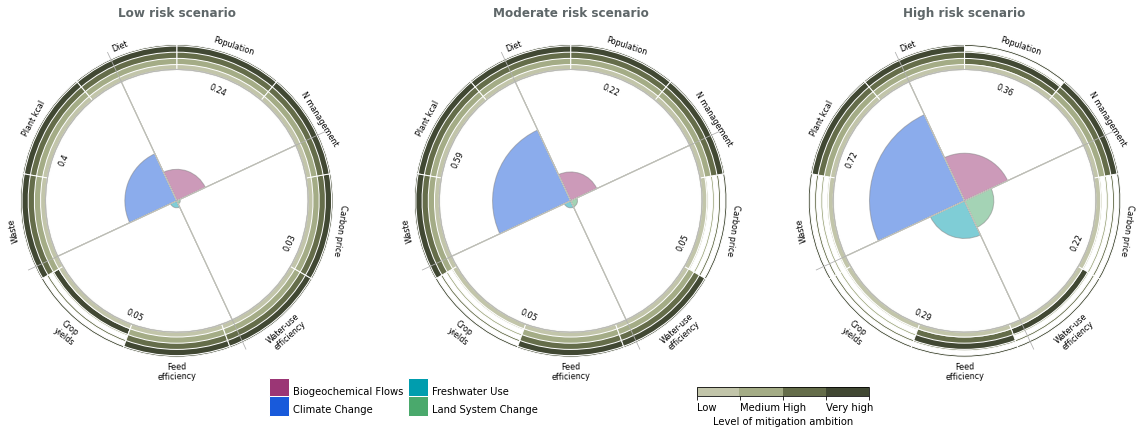

In [266]:
import os
import math
from textwrap import wrap
import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
#from matplotlib._png import read_png




# We  create a new solutions list without plant kcal
solutions2 = ['Pop_levels', 'Diet', 'Plant_kcal','Waste','Yield_levels','Feed_efficiency',#,'Feed_composition',
              'WUEinc','Carbon_price', 'N_management']#,'P_management']

# Create the figure
fig = plt.figure(figsize=(20, 15.7))


# Set up the grid
grid = plt.GridSpec(1, 3, wspace=.2)

axes = {}
# Create the subplots for the bar polar charts
for i in range(3):
    axes[i] = fig.add_subplot(grid[0,i], projection='polar')
        

        
        
for c, colour in enumerate(['Low risk', 'Moderate risk', 'High risk']): #
        
    # Set the zero location of theta
    axes[c].set_theta_zero_location("N", offset=-20)

    # Draw the outer solution bars
    sol_bar_label = solutions2 # Set the labels for the outer layer (solutions)
    N1 = len(sol_bar_label) # the numbre of solutions
    theta1 = np.linspace(0, 2 * np.pi, N1, endpoint=False)
    width1 = 2*np.pi/N1

    # Solution ring for highly ambitous level
    values1 = list(pd_scenario_rep_sol_q[colour].iloc[0])
    axes[c].bar(theta1, values1, width=width1, bottom=7.0, color='#414833',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for ambitous level
    values = [x-.33 if x > 0.25 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.0, color='#656d4a',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for BAU level
    values = [x-.66 if x > 0.6 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.0, color='#a4ac86',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for low ambitous level
    values = [x-.99 if x > 0.95 else .26 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.0, color='#c2c5aa',
                   edgecolor='white',zorder=1,alpha=1)
    
    # Draw the boundary frame for solution bars
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=8.23, color='#414833',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.89, color='#656d4a',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.56, color='#a4ac86',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.23, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=6.9, color='#c2c5aa',
                   edgecolor='white', zorder=-1, alpha=1)
    
    
       

    # Draw the inner boundary bars
    bon_bar_label = boundaries # Set the labels for the inner layer (boundaries)
    N2 = len(bon_bar_label) # the numbre of boundaries
    theta2 = np.linspace(0, 2 * np.pi, N2, endpoint=False)
    width2 = 2*np.pi/N2
   
     
    wedge_colours_temp = risk_col_list[colour]
    boundary_colour = {'Biogeochemical_Flows': '#9B3675', 'Climate_Change':'#185ADB', 
                   'Freshwater_Use':'#009DAE', 'Land_system_change':'#4AA96C'}
    #wedge_colours = [risk_colour[wedge_colours_temp[i]] for i in range(len(wedge_colours_temp))]
    
    
    # Wedges filled colour - predicted avg list(boundary_colour.values()
    values = [i*7 for i in risk_list[colour]]
    
    values3 = [7,7,7,7]
   
    axes[c].bar(theta2, values3, width=width2, bottom=0.0, color='white',
                   edgecolor='grey',zorder=1,alpha=.9)
    
    # Wedges filled colour
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color=list(boundary_colour.values()),
                   edgecolor='grey',zorder=1,alpha=.5)
    
        
    '''for v, val in enumerate(values):
        # bound_min_norm for Climate change boundary is below zero. This causes issue in plotting. Here we replace it with temporary replaced it with zero for correction.
        if bound_min_norm[colour][v] < 0:
            bound_min_norm[colour][v] = 0
        
        
        col_r = [(.1,.2,.1, 0) for i in range(5)]
        col_o = [(.1,.2,.1, 0) for i in range(5)]
        col_y = [(.1,.2,.1, 0) for i in range(5)]
        col_g = [(.1,.2,.1, 0) for i in range(5)]
        if val > bound_max_norm[colour][v]: #red
            col_r[v] = '#DD4A48'
            col_o[v] = '#FFA62B'
            col_y[v] = '#FFC85C'
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_r,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_max_norm[colour][v], width=width2, bottom=0.0, color=col_o,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_mode_norm[colour][v], width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_min_norm[colour][v], width=width2, bottom=0.0, color=col_g,
                   edgecolor='none',zorder=1)

        if (val > bound_mode_norm[colour][v]) & (val <= bound_max_norm[colour][v]): #orange
            col_o[v] = '#FFA62B'
            col_y[v] = '#FFC85C'
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_o,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_mode_norm[colour][v], width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_min_norm[colour][v], width=width2, bottom=0.0, color=col_g,
                   edgecolor='none',zorder=1)

        if (val > bound_min_norm[colour][v]) & (val <= bound_mode_norm[colour][v]): # yellow
            col_y[v] = '#FFC85C'
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_min_norm[colour][v], width=width2, bottom=0, color=col_g,
                   edgecolor='none',zorder=1)

        if val <= bound_min_norm[colour][v]: #green
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0, color=col_g,
                   edgecolor='none',zorder=1)'''


   
 
    
    # Boundary mode line. Not used anymore
    '''values = bound_mode_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#FFA62B',zorder=1,alpha=1)
    # Boundary min line
    values = bound_min_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#519259',zorder=1,alpha=1)
    # Boundary max line
    values = bound_max_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#DD4A48',zorder=1,alpha=1)'''


    
    # Wedges border colour
    values = [7, 7, 7, 7] # max normalised values of 'Nfert','Pfert', 'DirNonCO2', 'WaterUse', 'TotalAgArea'.
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#e6e8d5',zorder=1,alpha=1)
    
    # Annotate the solution and boundary label
    
    # Find the right angle for solution labels
    solution_angle = [math.degrees(theta1[i])-18 for i in range(9)]
    
    for n in range(N1):
        if n == 5:  # This condition is to adjust the solution label only
            axes[c].text(theta1[n], 9.1, 'Feed\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 4:
            axes[c].text(theta1[n], 9.1, 'Crop\nyields', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 6:
            axes[c].text(theta1[n], 9.1, 'Water-use\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta1[n], 8.8, solutions_name[solutions2[n]], rotation=solution_angle[n],
                horizontalalignment='center', verticalalignment='center', fontsize=8)

    
    # Adjust the grids
    axes[c].spines['polar'].set_visible(False)
    #axes[c].grid(True)
    # Calculate the degree of theta grids from radians
    grid_angle = [math.degrees(theta2[i])+45 for i in range(4)]  
    axes[c].set_thetagrids(grid_angle, [], visible=True)
    axes[c].set_rgrids([0, 7], [], visible=True)
    
    
    # Print the PB icon
    #img_dir = 'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/PB_icons/'
    
    
#     for b, bound in enumerate(boundaries):
#         img = mpimg.imread(img_dir+bound+'.png')
#         img2 = mpimg.imread(img_dir+'arrows'+'.png')
#         if bound in ['Biogeochemical_Flows_N', 'Biogeochemical_Flows_P']:
#             zoom = .06
#         else:
#             zoom = .15
#         imagebox = OffsetImage(img, zoom=zoom)
#         imagebox2 = OffsetImage(img2, zoom=.118)
#         if b == 0:  # This condition is to adjust the icon position only / biogeochemical N
#             ab = AnnotationBbox(imagebox, (theta2[b], 4.8), xycoords='data',  frameon=False)
#         elif b == 1: # biogeochemical P
#             ab = AnnotationBbox(imagebox, (theta2[b], 4.8), xycoords='data', frameon=False)
#         elif b == 2: # climate
#             ab = AnnotationBbox(imagebox, (theta2[b], 5), xycoords='data', frameon=False)
#         elif b == 3: # water
#             ab = AnnotationBbox(imagebox, (theta2[b], 5), xycoords='data', frameon=False)
#         else: # land system
#             ab = AnnotationBbox(imagebox, (theta2[b], 4.7), xycoords='data', frameon=False)
        
#         axes[c].add_artist(ab)
#         ab2 = AnnotationBbox(imagebox2, (0, 0), xycoords='data', frameon=False)
#         axes[c].add_artist(ab2)
        
        
    # Annotate risk on each boundary
    # Find the right angle for risk labels
    solution_angle = [math.degrees(theta2[i])-25 for i in range(4)]
    for n in range(N2):
        if n == 0:  # This condition is to adjust the boundary risk label only
            axes[c].text(theta2[n], 6.3, round(risk_list[colour][n],2), rotation=solution_angle[n],
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
        elif n == 1:
            axes[c].text(theta2[n], 6.4, round(risk_list[colour][n],2), rotation=solution_angle[n],
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
        elif n == 2:
            axes[c].text(theta2[n], 6.5, round(risk_list[colour][n],2), rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
        elif n == 3:
            axes[c].text(theta2[n], 6.4, round(risk_list[colour][n],2), rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
            
        else:
            axes[c].text(theta2[n], 6.5, round(risk_list[colour][n],2), rotation=solution_angle[n]+180,
                horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
            
    
    #Annotate scenario name on each subplot
    axes[c].text(np.radians(20), 10, colour+' scenario', fontsize=12, color='#5f6769', fontweight='heavy', 
                   rotation=0, horizontalalignment='center', verticalalignment='center')




# Create the legends
    
# Create the colorbar for the solution levels
# First, create a list of our values for colorbar
vals = [0, 1, 2, 3, 4]
val_labels = ['Low', 'Medium', 'High', 'Very high']

# Second, create the colour names with a function. 
colorbar_list = ['#c2c5aa', '#a4ac86', '#656d4a', '#414833']


# Third, create a ListedColormap object, which contains the information of the colours we want to display in our colourbar
cmap = mpl.colors.ListedColormap(colorbar_list)

# Set alpha
alpha_cmap = cmap(np.arange(cmap.N))
alpha_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
alpha_cmap = mpl.colors.ListedColormap(alpha_cmap)

# Fourth, set the colormap index for discrete color bar
norm = mpl.colors.BoundaryNorm(vals, alpha_cmap.N)

# Fifth, create the colorbar
axes[0] = fig.add_axes([0.5, 0.1, 0.03, 0.5]) 

cb = mpl.colorbar.ColorbarBase(axes[0], cmap=cmap,
                                norm=norm,
                                spacing='uniform',
                                orientation='horizontal',
                                extend='neither',
                                ticks=vals)
cb.set_ticklabels(val_labels)
for t in cb.ax.get_xticklabels():
    t.set_horizontalalignment('left') 

cb.set_label('Level of mitigation ambition', fontsize=10)
axes[0].set_position((.6, 0.33, 0.12, 0.008))  


# Create legend for Min, Mode, Max lines    
'''legend_elements = [Line2D([0], [0], color='#DD4A48', lw=2, label='Max'),
                   Line2D([0], [0], color='#FFA62B', lw=2,   label='Mode'),
                   Line2D([0], [0], color='#519259', lw=2,  label='Min')]

l1 = fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.38, .35),  
                bbox_transform=fig.transFigure, title= "Boundary's levels", frameon=False,ncol=2)

l1.get_title().set_position((-10, 12))'''


# Create legend for wedges
legend_elements_2 = []

#risks = ['Low', 'Moderate', 'High']
#riskcols = ['#FFC85C', '#FFA62B', '#DD4A48']

risks = ['Biogeochemical Flows', 'Climate Change', 'Freshwater Use', 'Land System Change']
riskcols = ['#9B3675', '#185ADB', '#009DAE','#4AA96C']

for r, rk in enumerate(risks):
    legend_elements_2.append(Line2D([0], [0], marker="s", color='none', label=rk, 
                                  markersize=20, markeredgecolor='white', markerfacecolor=riskcols[r], alpha=1))

l2 = fig.legend(handles=legend_elements_2, loc='upper left', bbox_to_anchor=(.30, .3, .4, .05), frameon=False, 
           bbox_transform=fig.transFigure, ncol=2, title="", 
           handlelength=1, columnspacing=1, handletextpad=.9, labelspacing=.01, fontsize=10, handleheight=2.4)

l2.get_title().set_position((-20, 20)) 
l2.get_title().set_fontsize('10') 



# Create boundary legends by adding images
# class ImageHandler(HandlerBase):
#     def create_artists(self, legend, orig_handle,
#                        xdescent, ydescent, width, height, fontsize,
#                        trans):

#         # enlarge the image by these margins
#         sx, sy = self.image_stretch 

#         # create a bounding box to house the image
#         bb = Bbox.from_bounds(xdescent - sx,
#                               ydescent - sy,
#                               width + sx,
#                               height + sy)

#         tbb = TransformedBbox(bb, trans)
#         image = BboxImage(tbb)
#         image.set_data(self.image_data)

#         self.update_prop(image, orig_handle, legend)

#         return [image]

#     def set_image(self, image_path, image_stretch=(0, 0)):
#         if not os.path.exists(image_path):
#             sample = get_sample_data("grace_hopper.png", asfileobj=False)
#             self.image_data = mpimg.imread(sample)
#         else:
#             self.image_data = mpimg.imread(image_path)

#         self.image_stretch = image_stretch

    
# # Create a legend for supply / demand side impacts

# # setup the handler instance for the scattered data
# custom_handler1 = ImageHandler()
# custom_handler1.set_image(img_dir+'Biogeochemical_Flows_N'+'.png',
#                          image_stretch=(20, 25))
# custom_handler2 = ImageHandler()
# custom_handler2.set_image(img_dir+'Biogeochemical_Flows_P'+'.png',
#                          image_stretch=(20, 25))
# custom_handler3 = ImageHandler()
# custom_handler3.set_image(img_dir+'Climate_Change'+'.png',
#                          image_stretch=(20, 25))
# custom_handler4 = ImageHandler()
# custom_handler4.set_image(img_dir+'Freshwater_Use'+'.png',
#                          image_stretch=(20, 25))
# custom_handler5 = ImageHandler()
# custom_handler5.set_image(img_dir+'Land_system_change'+'.png',
#                          image_stretch=(20, 25))

# plot two series of scatter data
# # random data
# x = np.random.randn(100)
# y = np.random.randn(100)
# y2 = np.random.randn(100)
# y3 = np.random.randn(100)
# y4 = np.random.randn(100)
# y5 = np.random.randn(100)

# s = plt.scatter(x, y, c='none')
# s2 = plt.scatter(x, y2, c='none')
# s3 = plt.scatter(x, y3, c='none')
# s4 = plt.scatter(x, y4, c='none')
# s5 = plt.scatter(x, y5, c='none')

# # add the legend for the scattered data, mapping the
# # scattered points to the custom handler
# l3 = plt.legend([s, s2, s3, s4, s5],
#            ['Biogeochemical\nflows N','Biogeochemical\nflows P', 'Climate\nchange', 'Freshwater\nuse', 'Land system\nchange'],
#            handler_map={s: custom_handler1, s2: custom_handler2, s3: custom_handler3, s4: custom_handler4, s5: custom_handler5},
#            labelspacing=1, ncol=3,handletextpad=.2,
#            frameon=False, bbox_to_anchor=(2.2, 4.9), loc='upper left')    

# for t in l3.get_texts():
#     t.set_va('center_baseline') 
 
    
'''# Create a legend for supply / demand side impacts
img3 = mpimg.imread(img_dir+'legend1'+'.png')
imagebox3 = OffsetImage(img3, zoom=.015) 
ab3 = AnnotationBbox(imagebox3, (.87, .1), xycoords='figure fraction',  frameon=False)
fig.add_artist(ab3)'''

#fig.text(.11, .62, 'a', fontsize=14, fontweight='semibold', rotation=0,
#                    horizontalalignment='center', verticalalignment='center')

plt.savefig('{}/Polar_Barchart.png'.format(r'M:/Current-Users/Michalis-Hadjikakou/Food_Meta_analysis_Enayat/Figs/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart_300dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 


In [252]:
solutions_name

{'Pop_levels': 'Population',
 'Diet': 'Diet',
 'Plant_kcal': 'Plant kcal',
 'Waste': 'Waste',
 'Yield_levels': 'Yield',
 'Feed_efficiency': 'Feed efficiency',
 'WUEinc': 'Water-use efficiency',
 'Carbon_price': 'Carbon price',
 'N_management': 'N management'}

In [100]:
risk_list['High risk']

[0.36225, 0.7236, 0.2867, 0.223]

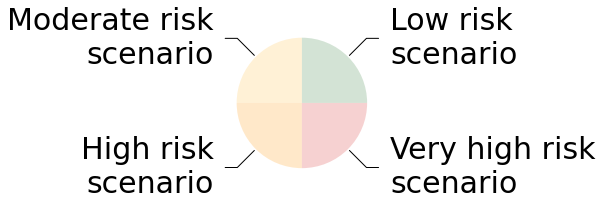

In [81]:
# Not in use anymore
# this create an image legend for the next plot. The legend is saved and will be used later as an image in the figures
fig_l1, ax_l1 = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"))

recipe = ['Low risk\nscenario', 'Moderate risk\nscenario', 'High risk\nscenario', 'Very high risk\nscenario']

data = [.25,.25,.25,.25]
ingredients = ['Low risk', 'Moderate risk', 'High risk', 'Very high risk']


wedges, texts = ax_l1.pie(data, colors=['#51925940','#FFC85C40','#FFA62B40', '#DD4A4840'], radius=1)


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="w", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax_l1.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw, fontsize=30)

fig_l1.savefig('{}/legend1.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/PB_icons/'), dpi=1500,  bbox_inches='tight') 
plt.close()

,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,WUEinc,Carbon_price,N_management,P_management
0,1.25,1.25,1.25,1.25,0.916667,1.25,0.25,1.25,1.25,1.25,1.25


Text(0.11, 0.62, 'a')

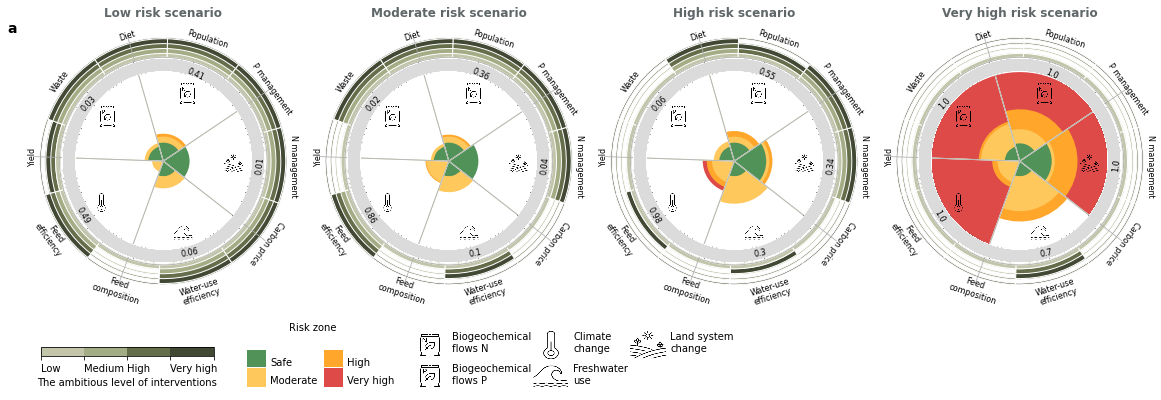

In [131]:
import os
import math
from textwrap import wrap
import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
#from matplotlib._png import read_png




# We  create a new solutions list without plant kcal
solutions2 = ['Pop_levels', 'Diet', 'Waste','Yield_levels','Feed_efficiency','Feed_composition',
              'WUEinc','Carbon_price', 'N_management','P_management']

# Create the figure
fig = plt.figure(figsize=(20, 15.7))


# Set up the grid
grid = plt.GridSpec(1, 4, wspace=.1)

axes = {}
# Create the subplots for the bar polar charts
for i in range(4):
    axes[i] = fig.add_subplot(grid[0,i], projection='polar')
        

        
        
for c, colour in enumerate(['Low risk', 'Moderate risk', 'High risk', 'Very high risk']): #
        
    # Set the zero location of theta
    axes[c].set_theta_zero_location("N", offset=-20)

    # Draw the outer solution bars
    sol_bar_label = solutions2 # Set the labels for the outer layer (solutions)
    N1 = len(sol_bar_label) # the numbre of solutions
    theta1 = np.linspace(0, 2 * np.pi, N1, endpoint=False)
    width1 = 2*np.pi/N1

    # Solution ring for highly ambitous level
    values1 = list(pd_scenario_rep_sol_q[colour].iloc[0])
    axes[c].bar(theta1, values1, width=width1, bottom=7.0, color='#414833',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for ambitous level
    values = [x-.33 if x > 0.25 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.0, color='#656d4a',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for BAU level
    values = [x-.66 if x > 0.6 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.0, color='#a4ac86',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for low ambitous level
    values = [x-.99 if x > 0.95 else .26 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.0, color='#c2c5aa',
                   edgecolor='white',zorder=1,alpha=1)
    
    # Draw the boundary frame for solution bars
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=8.23, color='#414833',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.89, color='#656d4a',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.56, color='#a4ac86',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.23, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=6.9, color='#c2c5aa',
                   edgecolor='white', zorder=-1, alpha=1)
    
    
       

    # Draw the inner boundary bars
    bon_bar_label = boundaries # Set the labels for the inner layer (boundaries)
    N2 = len(bon_bar_label) # the numbre of boundaries
    theta2 = np.linspace(0, 2 * np.pi, N2, endpoint=False)
    width2 = 2*np.pi/N2
   
     
    #wedge_colours_temp = risk_col_list[colour]
    #boundary_colour = {'Biogeochemical_Flows': '#9B3675', 'Climate_Change':'#185ADB', 
                   #'Freshwater_Use':'#009DAE', 'Land_system_change':'#4AA96C'}
    #wedge_colours = [risk_colour[wedge_colours_temp[i]] for i in range(len(wedge_colours_temp))]
    
    
    # Wedges filled colour - predicted avg list(boundary_colour.values()
    values = pred_avg_norm[colour]
    
        
    for v, val in enumerate(values):
        # bound_min_norm for Climate change boundary is below zero. This causes issue in plotting. Here we replace it with temporary replaced it with zero for correction.
        if bound_min_norm[colour][v] < 0:
            bound_min_norm[colour][v] = 0
        
        
        col_r = [(.1,.2,.1, 0) for i in range(5)]
        col_o = [(.1,.2,.1, 0) for i in range(5)]
        col_y = [(.1,.2,.1, 0) for i in range(5)]
        col_g = [(.1,.2,.1, 0) for i in range(5)]
        if val > bound_max_norm[colour][v]: #red
            col_r[v] = '#DD4A48'
            col_o[v] = '#FFA62B'
            col_y[v] = '#FFC85C'
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_r,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_max_norm[colour][v], width=width2, bottom=0.0, color=col_o,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_mode_norm[colour][v], width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_min_norm[colour][v], width=width2, bottom=0.0, color=col_g,
                   edgecolor='none',zorder=1)

        if (val > bound_mode_norm[colour][v]) & (val <= bound_max_norm[colour][v]): #orange
            col_o[v] = '#FFA62B'
            col_y[v] = '#FFC85C'
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_o,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_mode_norm[colour][v], width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_min_norm[colour][v], width=width2, bottom=0.0, color=col_g,
                   edgecolor='none',zorder=1)

        if (val > bound_min_norm[colour][v]) & (val <= bound_mode_norm[colour][v]): # yellow
            col_y[v] = '#FFC85C'
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_min_norm[colour][v], width=width2, bottom=0, color=col_g,
                   edgecolor='none',zorder=1)

        if val <= bound_min_norm[colour][v]: #green
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0, color=col_g,
                   edgecolor='none',zorder=1)


   
 
    
    # Boundary mode line. Not used anymore
    '''values = bound_mode_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#FFA62B',zorder=1,alpha=1)
    # Boundary min line
    values = bound_min_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#519259',zorder=1,alpha=1)
    # Boundary max line
    values = bound_max_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#DD4A48',zorder=1,alpha=1)'''


    
    # Wedges border colour
    values = [7, 7, 7, 7, 7] # max normalised values of 'Nfert','Pfert', 'DirNonCO2', 'WaterUse', 'TotalAgArea'.
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#e6e8d5',zorder=1,alpha=1)
    
    # Annotate the solution and boundary label
    
    # Find the right angle for solution labels
    solution_angle = [math.degrees(theta1[i])-18 for i in range(10)]
    
    for n in range(N1):
        if n == 4:  # This condition is to adjust the solution label only
            axes[c].text(theta1[n], 9.1, 'Feed\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 5:
            axes[c].text(theta1[n], 9.1, 'Feed\ncomposition', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 6:
            axes[c].text(theta1[n], 9.1, 'Water-use\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta1[n], 8.8, solutions_name[solutions2[n]], rotation=solution_angle[n],
                horizontalalignment='center', verticalalignment='center', fontsize=8)

    
    # Adjust the grids
    axes[c].spines['polar'].set_visible(False)
    #axes[c].grid(True)
    # Calculate the degree of theta grids from radians
    grid_angle = [math.degrees(theta2[i])+36 for i in range(5)]  
    axes[c].set_thetagrids(grid_angle, [], visible=True)
    axes[c].set_rgrids([0, 7], [], visible=True)
    
    
    # Print the PB icon
    img_dir = 'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/PB_icons/'
    
    
    for b, bound in enumerate(boundaries):
        img = mpimg.imread(img_dir+bound+'.png')
        img2 = mpimg.imread(img_dir+'arrows'+'.png')
        if bound in ['Biogeochemical_Flows_N', 'Biogeochemical_Flows_P']:
            zoom = .06
        else:
            zoom = .15
        imagebox = OffsetImage(img, zoom=zoom)
        imagebox2 = OffsetImage(img2, zoom=.118)
        if b == 0:  # This condition is to adjust the icon position only / biogeochemical N
            ab = AnnotationBbox(imagebox, (theta2[b], 4.8), xycoords='data',  frameon=False)
        elif b == 1: # biogeochemical P
            ab = AnnotationBbox(imagebox, (theta2[b], 4.8), xycoords='data', frameon=False)
        elif b == 2: # climate
            ab = AnnotationBbox(imagebox, (theta2[b], 5), xycoords='data', frameon=False)
        elif b == 3: # water
            ab = AnnotationBbox(imagebox, (theta2[b], 5), xycoords='data', frameon=False)
        else: # land system
            ab = AnnotationBbox(imagebox, (theta2[b], 4.7), xycoords='data', frameon=False)
        
        axes[c].add_artist(ab)
        ab2 = AnnotationBbox(imagebox2, (0, 0), xycoords='data', frameon=False)
        axes[c].add_artist(ab2)
        
        
    # Annotate risk on each boundary
    # Find the right angle for risk labels
    solution_angle = [math.degrees(theta2[i])-25 for i in range(5)]
    for n in range(N2):
        if n == 0:  # This condition is to adjust the boundary risk label only
            axes[c].text(theta2[n], 6.3, round(risk_list[colour][n],2), rotation=solution_angle[n],
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
        elif n == 1:
            axes[c].text(theta2[n], 6.4, round(risk_list[colour][n],2), rotation=solution_angle[n],
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
        elif n == 2:
            axes[c].text(theta2[n], 6.5, round(risk_list[colour][n],2), rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
        elif n == 3:
            axes[c].text(theta2[n], 6.4, round(risk_list[colour][n],2), rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
            
        else:
            axes[c].text(theta2[n], 6.5, round(risk_list[colour][n],2), rotation=solution_angle[n]+180,
                horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
            
    
    #Annotate scenario name on each subplot
    axes[c].text(np.radians(20), 10, colour+' scenario', fontsize=12, color='#5f6769', fontweight='heavy', 
                   rotation=0, horizontalalignment='center', verticalalignment='center')




# Create the legends
    
# Create the colorbar for the solution levels
# First, create a list of our values for colorbar
vals = [0, 1, 2, 3, 4]
val_labels = ['Low', 'Medium', 'High', 'Very high']

# Second, create the colour names with a function. 
colorbar_list = ['#c2c5aa', '#a4ac86', '#656d4a', '#414833']


# Third, create a ListedColormap object, which contains the information of the colours we want to display in our colourbar
cmap = mpl.colors.ListedColormap(colorbar_list)

# Set alpha
alpha_cmap = cmap(np.arange(cmap.N))
alpha_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
alpha_cmap = mpl.colors.ListedColormap(alpha_cmap)

# Fourth, set the colormap index for discrete color bar
norm = mpl.colors.BoundaryNorm(vals, alpha_cmap.N)

# Fifth, create the colorbar
axes[0] = fig.add_axes([0.5, 0.1, 0.03, 0.5]) 

cb = mpl.colorbar.ColorbarBase(axes[0], cmap=cmap,
                                norm=norm,
                                spacing='uniform',
                                orientation='horizontal',
                                extend='neither',
                                ticks=vals)
cb.set_ticklabels(val_labels)
for t in cb.ax.get_xticklabels():
    t.set_horizontalalignment('left') 

cb.set_label('The ambitious level of interventions', fontsize=10)
axes[0].set_position((.13, 0.33, 0.12, 0.008))  


# Create legend for Min, Mode, Max lines    
'''legend_elements = [Line2D([0], [0], color='#DD4A48', lw=2, label='Max'),
                   Line2D([0], [0], color='#FFA62B', lw=2,   label='Mode'),
                   Line2D([0], [0], color='#519259', lw=2,  label='Min')]

l1 = fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.38, .35),  
                bbox_transform=fig.transFigure, title= "Boundary's levels", frameon=False,ncol=2)

l1.get_title().set_position((-10, 12))'''


# Create legend for wedges
legend_elements_2 = []

risks = ['Safe', 'Moderate', 'High', 'Very high']
riskcols = ['#519259', '#FFC85C', '#FFA62B', '#DD4A48']
for r, rk in enumerate(risks):
    legend_elements_2.append(Line2D([0], [0], marker="s", color='none', label=rk, 
                                  markersize=20, markeredgecolor='white', markerfacecolor=riskcols[r], alpha=1))

l2 = fig.legend(handles=legend_elements_2, loc='upper left', bbox_to_anchor=(.27, .3, .4, .05), frameon=False, 
           bbox_transform=fig.transFigure, ncol=2, title="Risk zone", 
           handlelength=1, columnspacing=1, handletextpad=.9, labelspacing=.01, fontsize=10, handleheight=2.4)

l2.get_title().set_position((-10, 20)) 
#l2.get_title().set_fontsize('10') 



# Create boundary legends by adding images
class ImageHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize,
                       trans):

        # enlarge the image by these margins
        sx, sy = self.image_stretch 

        # create a bounding box to house the image
        bb = Bbox.from_bounds(xdescent - sx,
                              ydescent - sy,
                              width + sx,
                              height + sy)

        tbb = TransformedBbox(bb, trans)
        image = BboxImage(tbb)
        image.set_data(self.image_data)

        self.update_prop(image, orig_handle, legend)

        return [image]

    def set_image(self, image_path, image_stretch=(0, 0)):
        if not os.path.exists(image_path):
            sample = get_sample_data("grace_hopper.png", asfileobj=False)
            self.image_data = mpimg.imread(sample)
        else:
            self.image_data = mpimg.imread(image_path)

        self.image_stretch = image_stretch

    
# Create a legend for supply / demand side impacts

# setup the handler instance for the scattered data
custom_handler1 = ImageHandler()
custom_handler1.set_image(img_dir+'Biogeochemical_Flows_N'+'.png',
                         image_stretch=(20, 25))
custom_handler2 = ImageHandler()
custom_handler2.set_image(img_dir+'Biogeochemical_Flows_P'+'.png',
                         image_stretch=(20, 25))
custom_handler3 = ImageHandler()
custom_handler3.set_image(img_dir+'Climate_Change'+'.png',
                         image_stretch=(20, 25))
custom_handler4 = ImageHandler()
custom_handler4.set_image(img_dir+'Freshwater_Use'+'.png',
                         image_stretch=(20, 25))
custom_handler5 = ImageHandler()
custom_handler5.set_image(img_dir+'Land_system_change'+'.png',
                         image_stretch=(20, 25))

# plot two series of scatter data
# random data
x = np.random.randn(100)
y = np.random.randn(100)
y2 = np.random.randn(100)
y3 = np.random.randn(100)
y4 = np.random.randn(100)
y5 = np.random.randn(100)

s = plt.scatter(x, y, c='none')
s2 = plt.scatter(x, y2, c='none')
s3 = plt.scatter(x, y3, c='none')
s4 = plt.scatter(x, y4, c='none')
s5 = plt.scatter(x, y5, c='none')

# add the legend for the scattered data, mapping the
# scattered points to the custom handler
l3 = plt.legend([s, s2, s3, s4, s5],
           ['Biogeochemical\nflows N','Biogeochemical\nflows P', 'Climate\nchange', 'Freshwater\nuse', 'Land system\nchange'],
           handler_map={s: custom_handler1, s2: custom_handler2, s3: custom_handler3, s4: custom_handler4, s5: custom_handler5},
           labelspacing=1, ncol=3,handletextpad=.2,
           frameon=False, bbox_to_anchor=(2.2, 4.9), loc='upper left')    

for t in l3.get_texts():
    t.set_va('center_baseline') 
 
    
'''# Create a legend for supply / demand side impacts
img3 = mpimg.imread(img_dir+'legend1'+'.png')
imagebox3 = OffsetImage(img3, zoom=.015) 
ab3 = AnnotationBbox(imagebox3, (.87, .1), xycoords='figure fraction',  frameon=False)
fig.add_artist(ab3)'''

fig.text(.11, .62, 'a', fontsize=14, fontweight='semibold', rotation=0,
                    horizontalalignment='center', verticalalignment='center')

#plt.savefig('{}/Polar_Barchart_300dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=300,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 


## Identify the representative scenarios in the indicator datasets

In [29]:
# The first is to find the representative scenarios in the indicator datasets.
# We match the solution ambition level of each representative scenario with the solution ambition of all scenarios 
# for each indicator in the indicator datasets.


boundary_inds = {'Biogeochemical_Flows_N':['Nfert','Nsurplus'], 'Biogeochemical_Flows_P':['Pfert', 'Psurplus'], 
                'Climate_Change':['CH4', 'CO2_LUC', 'N2O'], 'Freshwater_Use':['Water'], 
                'Land_system_change':['Cropland','Pasture']}

scenario_rep_all_ind = {} # A dictionary of arrays. Each dict key is an (indicator, colour) and their value is 
                          #an array of row indices in the indicator original datasets with solution ambitions 
                          #equal to selected scenario

        
for b, bound in enumerate(boundaries):
    for i, ind in enumerate(boundary_inds[bound]):  
        df1 = results_dict_ind[ind].copy()
        if bound in ['Climate_Change', 'Land_system_change'] :
            df1.rename(columns={'C_price':'Carbon_price'} , inplace=True) # This is to fix some column name inconsistencies between boudary and indicators in the datasets
            df1.rename(columns={'Pred_avg_LUC':'Pred_avg'} , inplace=True)  
            if ind == 'CO2_LUC': 
                df1['Pop_levels'].replace('10.58777','10.5877739',inplace=True) # To correct inconsistencies in pop-levels in CO2_LUC
                df1['Pop_levels'].replace('9.735034','9.7350339',inplace=True)
        for c, colour in enumerate(['Low risk', 'Moderate risk', 'High risk', 'Very high risk']): # Scenarios
            
            inds_temp = {'Nfert':'Nfert','Nsurplus':'Nfert', 'Pfert':'Pfert', 'Psurplus':'Pfert', # This is to fix the differnet name of indicators in the boundary and indicator datasets
                         'CH4':'DirNonCO2', 'CO2_LUC':'DirNonCO2', 'N2O':'DirNonCO2', 
                         'Water':'WaterUse', 'Cropland':'TotalAgArea','Pasture':'TotalAgArea'}
            df2 = pd_scenario_rep_all[colour].loc[pd_scenario_rep_all[colour]['Indicator']==inds_temp[ind]].copy()
            #scenario_rep_all_ind[(ind, colour)] = []
            for j, rowj in df2.iterrows():
                if bound == 'Biogeochemical_Flows_N':
                    temp = (df1[(df1['Pop_levels']==rowj['Pop_levels']) & (df1['Diet']==rowj['Diet']) & (df1['Waste']==rowj['Waste']) & (df1['Yield_levels']==rowj['Yield_levels']) & (df1['Feed_efficiency']==rowj['Feed_efficiency']) & (df1['Feed_composition']==rowj['Feed_composition']) & (df1['N_management']==rowj['N_management'])].index.values)
                    scenario_rep_all_ind[(ind, colour)] = df1.iloc[temp.tolist()]
                elif bound == 'Biogeochemical_Flows_P':
                    temp = (df1[(df1['Pop_levels']==rowj['Pop_levels']) & (df1['Diet']==rowj['Diet']) & (df1['Waste']==rowj['Waste']) & (df1['Yield_levels']==rowj['Yield_levels']) & (df1['Feed_efficiency']==rowj['Feed_efficiency']) & (df1['Feed_composition']==rowj['Feed_composition']) & (df1['P_management']==rowj['P_management'])].index.values)
                    scenario_rep_all_ind[(ind, colour)] = df1.iloc[temp.tolist()]
                elif bound == 'Climate_Change':
                    temp = (df1[(df1['Pop_levels']==rowj['Pop_levels']) & (df1['Diet']==rowj['Diet']) & (df1['Waste']==rowj['Waste']) & (df1['Yield_levels']==rowj['Yield_levels']) & (df1['Feed_efficiency']==rowj['Feed_efficiency']) & (df1['Feed_composition']==rowj['Feed_composition']) & (df1['Carbon_price']==rowj['Carbon_price'])].index.values)
                    scenario_rep_all_ind[(ind, colour)] = df1.iloc[temp.tolist()]
                elif bound == 'Freshwater_Use':
                    temp = (df1[(df1['Pop_levels']==rowj['Pop_levels']) & (df1['Diet']==rowj['Diet']) & (df1['Waste']==rowj['Waste']) & (df1['Yield_levels']==rowj['Yield_levels']) & (df1['Feed_efficiency']==rowj['Feed_efficiency']) & (df1['Feed_composition']==rowj['Feed_composition']) & (df1['WUEinc']==rowj['WUEinc'])].index.values)
                    scenario_rep_all_ind[(ind, colour)] = df1.iloc[temp.tolist()]
                elif bound == 'Land_system_change':
                    temp = (df1[(df1['Pop_levels']==rowj['Pop_levels']) & (df1['Diet']==rowj['Diet']) & (df1['Waste']==rowj['Waste']) & (df1['Yield_levels']==rowj['Yield_levels']) & (df1['Feed_efficiency']==rowj['Feed_efficiency']) & (df1['Feed_composition']==rowj['Feed_composition']) & (df1['Carbon_price']==rowj['Carbon_price'])].index.values)
                    scenario_rep_all_ind[(ind, colour)] = df1.iloc[temp.tolist()]

In [30]:
# For exmaple, let's see the scenarios in the indicator datasets for CO2_LUC that match the solution ambition of 
# the very high risk scenario
scenario_rep_all_ind[('CO2_LUC', 'Very high risk')]

,System,Indicator,Pop_levels,Diet,Plant_kcal,Waste,Yield_levels,Feed_efficiency,Feed_composition,Carbon_price,Pred_avg,Variance_LUC,SD_avg,fit,upr,lwr
61440,Climate change,CO2_LUC,10.5877739,RICH DIET,2300,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,5576.955,1791790.0,1338.578,0.138154,0.684512,-0.408204
61696,Climate change,CO2_LUC,10.5877739,RICH DIET,2500,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,5910.784,1829220.0,1352.486,0.206282,0.758318,-0.345753
61952,Climate change,CO2_LUC,10.5877739,RICH DIET,2700,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,6274.267,1791485.0,1338.464,0.280463,0.826774,-0.265849
62208,Climate change,CO2_LUC,10.5877739,RICH DIET,2900,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,0,6690.247,1790513.0,1338.100,0.365357,0.911520,-0.180807


## Prepare data for indicator-level prediction violin plots

In [31]:
# Flatten 2D arrays in scenario_rep_all_ind across scenarios to 1D array (all scenarios related to each indicator in one dataframe) 
# and create a long-format dataframe for plotting all scenarios related to each indicator in one subplot.
# Why we convert outcomes to long-format dataframe? because it's the accepted format of sns.violinplot 
scenario_rep_all_ind_1D = {}
for b, bound in enumerate(boundaries):
    for i, ind in enumerate(boundary_inds[bound]): 
        scenario_rep_all_ind_temp1 = [] 
        for c, colour in enumerate(['Low risk', 'Moderate risk', 'High risk', 'Very high risk']):
            scenario_rep_all_ind_temp = scenario_rep_all_ind[(ind, colour)].copy()
            scenario_rep_all_ind_temp['Scenario'] = colour
            scenario_rep_all_ind_temp1.append(scenario_rep_all_ind_temp)

        scenario_rep_all_ind_1D[ind] = pd.concat(scenario_rep_all_ind_temp1)


In [32]:
# Let's see an example of 1D array for Nfert
scenario_rep_all_ind_1D['Nfert']

,System,Indicator,Pop_levels,Diet,Waste,Yield_levels,Feed_efficiency,Feed_composition,Rum_meat_kcal_supply,Rum_meat_kcal_intake,...,Pred_upr,Pred_lwr,SD_lwr,SD_upr,SD_avg,Min,Mode,Max,RiskCol,Scenario
28876,Biogeochemical flows,Nfert,8.5,LOW ASF,Half,1.15,HIGH,LOW GRAIN/HIGH GRASS,55,50.65026,...,85.892271,58.470571,12.757380,14.664320,13.710850,52,69,130,ORANGE,Low risk
28877,Biogeochemical flows,Nfert,8.5,LOW ASF,Half,1.15,HIGH,LOW GRAIN/HIGH GRASS,55,50.65026,...,86.734034,58.310898,12.707237,15.715899,14.211568,52,69,130,ORANGE,Low risk
28878,Biogeochemical flows,Nfert,8.5,LOW ASF,Half,1.15,HIGH,LOW GRAIN/HIGH GRASS,55,50.65026,...,87.112765,58.864739,12.439857,15.808169,14.124013,52,69,130,ORANGE,Low risk
28879,Biogeochemical flows,Nfert,8.5,LOW ASF,Half,1.15,HIGH,LOW GRAIN/HIGH GRASS,55,50.65026,...,87.580156,58.519206,12.660268,16.400681,14.530475,52,69,130,ORANGE,Low risk
29900,Biogeochemical flows,Nfert,8.5,LOW ASF,Half,1.15,HIGH,LOW GRAIN/HIGH GRASS,25,23.02285,...,90.704871,61.009386,13.649293,16.046192,14.847743,52,69,130,ORANGE,Low risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247811,Biogeochemical flows,Nfert,10.5877739,RICH DIET,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,40,36.83656,...,227.606210,154.642141,33.078826,39.885243,36.482035,52,69,130,RED,Very high risk
248832,Biogeochemical flows,Nfert,10.5877739,RICH DIET,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,70,64.46397,...,245.979531,165.597926,35.614128,44.767477,40.190802,52,69,130,RED,Very high risk
248833,Biogeochemical flows,Nfert,10.5877739,RICH DIET,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,70,64.46397,...,244.610384,165.274657,34.712769,44.622958,39.667863,52,69,130,RED,Very high risk
248834,Biogeochemical flows,Nfert,10.5877739,RICH DIET,BAU_High,1.15,STAGNANT,LOW GRAIN/HIGH GRASS,70,64.46397,...,243.733452,166.648300,35.264026,41.821126,38.542576,52,69,130,RED,Very high risk


## Prepare data for solution impact pie charts

In [33]:
# Load indicator - solution data
results_riskdiff = pd.read_excel(directory+'Figure_3_data_table_SI_2021-12-13.xlsx', converters={'Level':str, 
                                                                                                 'Pred_mean':float})
results_riskdiff = results_riskdiff.drop(columns=['n', 'Pred_SD', 'Risk_L', 
                                                'Risk_H', 'Risk_joint_median', 'Risk_Q25', 'Risk_Q75']) # Drop unnecessary columns

results_riskdiff['Level'].replace('8.9','8.9067971',inplace=True) # To correct inconsistencies in levels
results_riskdiff['Level'].replace('9.7','9.7350339',inplace=True) # To correct inconsistencies in levels
results_riskdiff['Level'].replace('10.6','10.5877739',inplace=True) # To correct inconsistencies in levels
results_riskdiff['Level'].replace('33.3','33.3333333',inplace=True) # To correct inconsistencies in levels
results_riskdiff['Level'].replace('66.7','66.6666667',inplace=True) # To correct inconsistencies in levels


In [34]:
pred_change_all = {} # Record prediction % change compared to BAU per each solution in each indicator
pred_change = {}  # Record prediction % change compared to BAU per each solution group (demand vs supply) in each indicator
pred_change_pd = {}
pred_change_all_pd = {}


demand_sol = ['Pop_levels','Diet','Waste']
supply_sol = ['Yield_levels','Feed_efficiency','Feed_composition','WUEinc','Carbon_price','N_management','P_management']
sol_group_name  = {0: 'Demand-side', 1:'Supply-side'}

for b, bound in enumerate(boundaries):
    for i, ind in enumerate(boundary_inds[bound]):
        pred_change_all[ind] = []
        pred_change[ind] = []
        for sc, scenario in enumerate(['Low risk', 'Moderate risk', 'High risk', 'Very high risk']):
            for g, group in enumerate([demand_sol, supply_sol]):
                pred_change_temp = 0
                for s, sol in enumerate(group):
                    if sol in list(set(results_riskdiff[results_riskdiff['Indicator']==ind]['Predictor'])):
                        # Select BAU level and the representative scenario level of each solution
                        sollevel_bau = list(ref_levels[(ref_levels['Level'] == 'Medium')][sol])[0]
                        sollevel_sc = list(scenario_rep_all_ind[(ind, scenario)][sol])[0]

                       # Identify the BAU scenario prediction of individual indicators of individual solutions
                        pred_bau = list(results_riskdiff[(results_riskdiff['Indicator'] == ind) & 
                                         (results_riskdiff['Predictor'] == sol) & 
                                         (results_riskdiff['Level'] == sollevel_bau)]['Pred_mean'])[0]

                        # Identify the representative scenario prediction of individual indicators
                        pred_sc = list(results_riskdiff[(results_riskdiff['Indicator'] == ind) & 
                                         (results_riskdiff['Predictor'] == sol) & 
                                         (results_riskdiff['Level'] == sollevel_sc)]['Pred_mean'])[0]
                        # Compute the prediction % change between representative vs. BAU scenario in each indicator per each solution
                        pred_change_all_temp = ((pred_sc-pred_bau)/pred_bau)*100
                        pred_change_all[ind].append([sol, scenario, pred_change_all_temp])
                        
                        # Compute the prediction % change between representative vs. BAU scenario in each indicator per each solution category (demand vs supply)
                        pred_change_temp += ((pred_sc-pred_bau)/pred_bau)*100
                pred_change[ind].append([sol_group_name[g], scenario, pred_change_temp])
        
        # Convert list to dataframe
        pred_change_pd[ind] = pd.DataFrame(pred_change[ind], columns=['Solution', 'Scenario', 'Prediction % change'])
        pred_change_all_pd[ind] = pd.DataFrame(pred_change_all[ind], columns=['Solution', 'Scenario', 'Prediction % change'])

In [379]:
ref_levels_copy

NameError: name 'ref_levels_copy' is not defined

In [35]:
# For example, let's see the prediction % change between BAU and representative scenarios for cropland per demand- and supply-side solutions
pred_change_pd['Cropland']

,Solution,Scenario,Prediction % change
0,Demand-side,Low risk,-24.735341
1,Supply-side,Low risk,-17.541670
2,Demand-side,Moderate risk,5.148271
3,Supply-side,Moderate risk,2.372912
4,Demand-side,High risk,5.148271
5,Supply-side,High risk,10.490641
6,Demand-side,Very high risk,15.593891
7,Supply-side,Very high risk,10.490641


In [37]:
# For example, let's see the prediction % change between BAU and representative scenarios for cropland per each individual solutions
pred_change_all_pd['Cropland']

,Solution,Scenario,Prediction % change
0,Pop_levels,Low risk,-10.888919
1,Diet,Low risk,-6.832570
2,Waste,Low risk,-7.013851
3,Yield_levels,Low risk,-18.180988
4,Feed_efficiency,Low risk,-5.333058
5,Feed_composition,Low risk,5.972376
6,Pop_levels,Moderate risk,8.278335
7,Diet,Moderate risk,-6.832570
8,Waste,Moderate risk,3.702506
9,Yield_levels,Moderate risk,10.552254


## Call needed functions and classess for plotting

In [45]:
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.patches import BoxStyle
from matplotlib.lines import Line2D


# Function for drawing pie chart scatter plot
def draw_pie(dist, 
             xpos, 
             ypos, 
             size,
             alpha, zorder,
             ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,8))

    # for incremental pie slices
    cumsum = np.cumsum(dist)
    cumsum = cumsum/ cumsum[-1]
    pie = [0] + cumsum.tolist()

    i = 0
    for r1, r2 in zip(pie[:-1], pie[1:]):
        angles = np.linspace(2 * np.pi * r1, 2 * np.pi * r2)
        x = [0] + np.cos(angles).tolist()
        y = [0] + np.sin(angles).tolist()
        xy = np.column_stack([x, y])
        slice_color = {0:'#519259', 1:'#FFC85C', 2:'#FFA62B', 3:'#DD4A48'} #
        ax.scatter([xpos], [ypos], marker=xy, color=slice_color[i], edgecolors='none', alpha=alpha, s=size, zorder=zorder) #
        i += 1

    return ax


## plot violin plots and pie charts

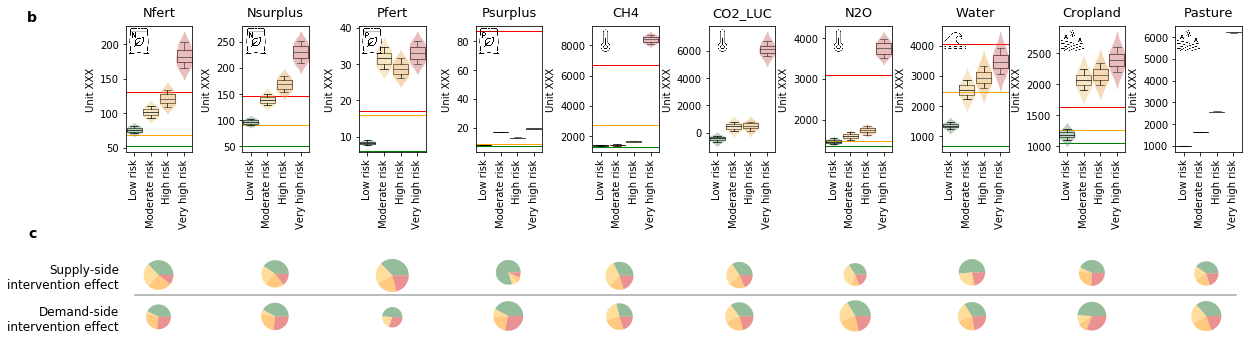

In [82]:
# Create grids and axes
fig = plt.figure(figsize=(20, 6))
grid = plt.GridSpec(3, 10, hspace=0.02, wspace=0.75, height_ratios= [1.1,.7, 1])
axes = {} # main axes fro violin plots
axes_s = {} # secondary axes for scatter plots
for i in range(10):
    axes[0,i] = fig.add_subplot(grid[0, i])
    axes_s[2,i] = fig.add_subplot(grid[2, i])
    
n= 0
for b, bound in enumerate(boundaries):
    for i, ind in enumerate(boundary_inds[bound]):
        
        sns.violinplot(x="Scenario", y="Pred_avg",data=scenario_rep_all_ind_1D[ind], palette=['#519259','#FFC85C','#FFA62B', '#DD4A48'],
                       linewidth=0, ax=axes[0,n], scale='width', width=1)
        for violin, alpha in zip(axes[0, n].collections[::2], [.4, .4, .4, .4, .4]):
            violin.set_alpha(alpha)
        sns.boxplot(x="Scenario", y="Pred_avg",data=scenario_rep_all_ind_1D[ind],  width=0.9, linewidth=.7, 
                    ax=axes[0,n], palette=['#519259','#FFC85C','#FFA62B', '#DD4A48'], showfliers=False)

        for a,artist in enumerate(axes[0,n].artists):
            # Set the linecolor on the artist to the facecolor, and set the facecolor to None
            col = artist.get_facecolor()
            artist.set_edgecolor('black')
            artist.set_facecolor('None')

            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for t in range(a*5,a*5+5):
                line = axes[0,n].lines[t]
                line.set_color('black')
                line.set_mfc('black')
                line.set_mec('black')

        
        # Annotate the boundary levels
        if 'Min' in list(scenario_rep_all_ind_1D[ind]):
            mn = scenario_rep_all_ind_1D[ind]['Min'].iloc[0]
            md = scenario_rep_all_ind_1D[ind]['Mode'].iloc[0]
            mx = scenario_rep_all_ind_1D[ind]['Max'].iloc[0]
            axes[0,n].axhline(y=mn, xmin=0, xmax=1,   alpha=1, lw=1, c='green', zorder=-1)
            axes[0,n].axhline(y=md, xmin=0, xmax=1,   alpha=1, lw=1, c='orange', zorder=-1)
            axes[0,n].axhline(y=mx, xmin=0, xmax=1,  alpha=1, lw=1, c='red', zorder=-1)
        
        
        axes[0,n].set_title(ind, fontsize=13, pad=9) 
        axes[0,n].yaxis.set_label_text('Unit XXX', fontsize=10)
        x_labels = ['Low risk','Moderate risk','High risk','Very high risk']
        axes[0,n].set_xticklabels(x_labels, fontsize=10, rotation=90)
        axes[0,n].set_xlabel('')
        
        # Print the boundary icon and add subplot labels
        img_dir = 'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/PB_icons/'
        img = mpimg.imread(img_dir+bound+'.png')
        if bound in ['Biogeochemical_Flows_N', 'Biogeochemical_Flows_P']:
            zoom = .08
        else:
            zoom = .18
        imagebox = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(imagebox, (.2, .88), xycoords='axes fraction', frameon=False)
        axes[0,n].add_artist(ab)        
        
        n += 1

    
    
    
# Plot the solution impact scatter plots
# Create an empty scatterplot with indicators in x axis and solutions (demand and supply sides) in y axis.
inds_list = [boundary_inds[b][i] for b in boundaries for i in range(len(boundary_inds[b]))]
n = 0
for b, bound in enumerate(boundaries):
    for i, ind in enumerate(boundary_inds[bound]):
        df = pred_change_pd[ind]
        val = {} # A temp dict to record the % per each scenario for pie chart
        sval = {} # A temp dict to record how much demand-sdie is more influential compared to supply-side for pie chart
        for g, group in enumerate(['Demand-side', 'Supply-side']):
            sval_temp = 0 # Temp variable to aggregate % change per each solution group across all scenrios 
            for sc, scenario in enumerate(['Low risk', 'Moderate risk', 'High risk', 'Very high risk']): 
                val[(group, scenario)] = abs(list(df[(df['Solution']==group) & (df['Scenario']==scenario)]['Prediction % change'])[0]) # Record the prediction % per each scenario
                sval_temp += abs(list(df[(df['Solution']==group) & (df['Scenario']==scenario)]['Prediction % change'])[0])
            sval[group] = sval_temp/4 # Average of absolute change across all scenarios
        ratio = 1500/(sval['Demand-side']+sval['Supply-side']) # the times that deamdn-side circle should be bigger compared to supply-side
        
        size_demand = ratio*sval['Demand-side']
        size_supply = ratio*sval['Supply-side']
        
        draw_pie([val[('Demand-side','Low risk')], val[('Demand-side','Moderate risk')], 
                  val[('Demand-side','High risk')], val[('Demand-side','Very high risk')]],
                 .5,.3,size_demand,alpha=.6, zorder=-100, ax=axes_s[2,n])
        draw_pie([val[('Supply-side','Low risk')], val[('Supply-side','Moderate risk')], 
                  val[('Supply-side','High risk')], val[('Supply-side','Very high risk')]],
                 .5,.7,size_supply,alpha=.6, zorder=-100, ax=axes_s[2,n])
        axes_s[2,n].margins(y=.7)
        axes_s[2,n].margins(x=1)
        # Remove all ticks and spines
        [s.set_visible(False) for s in axes_s[2,n].spines.values()]
        [t.set_visible(False) for t in axes_s[2,n].get_xticklines()]
        [t.set_visible(False) for t in axes_s[2,n].get_yticklines()]
        [l.set_visible(False) for l in axes_s[2,n].get_xticklabels()]
        if n >0:
            [l.set_visible(False) for l in axes_s[2,n].get_yticklabels()]
        
               
        n += 1
        

      
        
axes_s[2,0].set_yticks([.3, .7])
axes_s[2,0].set_yticklabels(['Demand-side\nintervention effect', 'Supply-side\nintervention effect'], fontsize=12, ha='right')

# Add the horizontal line between supplu and demand side intervention impacts
x,y = np.array([[-17.6, 1], [0.5, 0.5]])
line = Line2D(x, y, lw=1.5, color='grey', alpha=0.7)
line.set_clip_on(False)
axes_s[2,9].add_artist(line)


# Add all subplot labels
fig.text(.06, .9, 'b', fontsize=14, fontweight='semibold', rotation=0,
                    horizontalalignment='center', verticalalignment='center')
fig.text(.06, .4, 'c', fontsize=14, fontweight='semibold', rotation=0,
                    horizontalalignment='center', verticalalignment='center')

plt.savefig('{}/Indicator_Violin_Pie_Plot_300dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=300,  bbox_inches='tight') 
plt.savefig('{}/Indicator_Violin_Pie_Plot.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
plt.savefig('{}/Indicator_Violin_Pie_Plot_600dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
        


## Archive

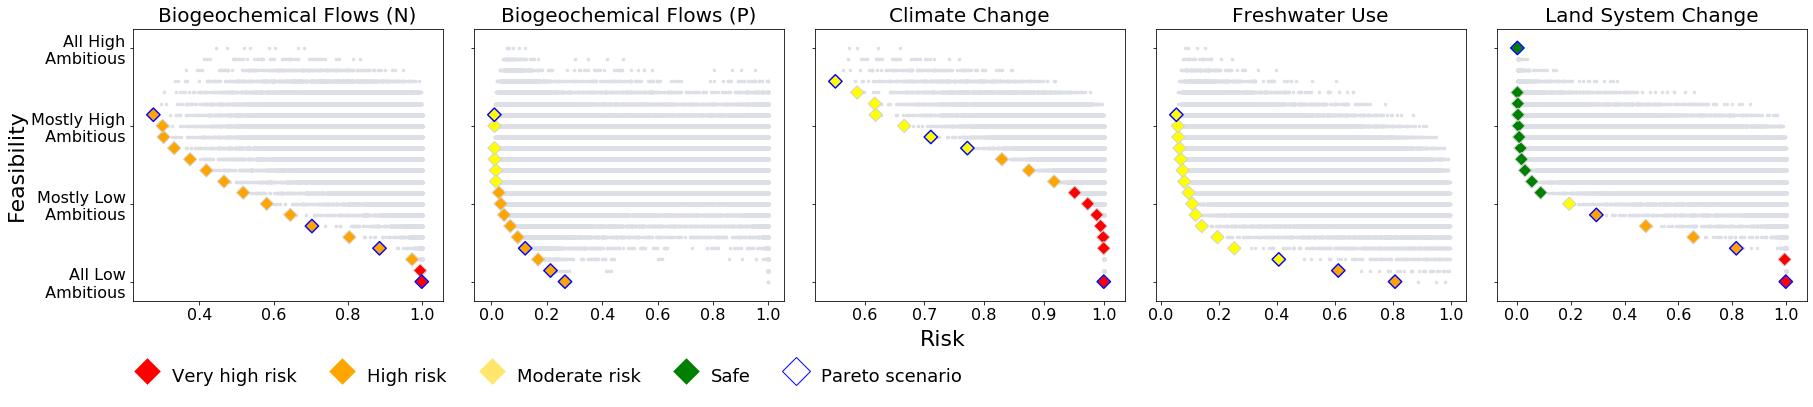

In [13]:
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.patches import BoxStyle
from matplotlib.lines import Line2D
import heapq


pd_scenario = {}

# Create axes
fig, axes = plt.subplots(1, 5, figsize=(30, 5), sharey='row')
fig.subplots_adjust(wspace=0.1)

for i, b in enumerate(boundaries):

    
    #p_front_x, p_front_y = column(p_front[b], obj1[b]), column(p_front[b], obj2[b])
    p_front_x, p_front_y, p_front_c = list(pd_p_front[b]['Risk']), list(pd_p_front[b]['Trend_deviation']), list(pd_p_front[b]['RiskCol'])
    
    
    # Derive the representative scenarios from the pareto solution set. 

    # First, in the pareto solution set, sort the risk colour and trend deviation based on the risk value (reverse)
    sorted_p_front_y = [y for _,y in sorted(zip(p_front_x,p_front_y), reverse=True)]
    sorted_p_front_c = [c for _,c in sorted(zip(p_front_x,p_front_c), reverse=True)]
    sorted_p_front_x = sorted(p_front_x, reverse=True)

    # Second, calculate the derivative of the pareto front at each pareto solution point
    impv = [0]
    for j in range(len(sorted_p_front_y)-1):
        ys = abs(sorted_p_front_y[j]-sorted_p_front_y[j+1])
        xs = abs(sorted_p_front_x[j]-sorted_p_front_x[j+1])
        impv.append(xs/ys)


    # Third, select four representative scenarios.
    
    pd_scenario[(b, 'Very high risk')] = pd_p_front[b].iloc[np.argmax(pd_p_front[b]['Risk'])].to_frame().T
    pd_scenario[(b, 'Low risk')] = pd_p_front[b].iloc[np.argmin(pd_p_front[b]['Risk'])].to_frame().T
    
    max_id_1 = heapq.nlargest(2, range(len(impv)), key=impv.__getitem__)[1] # index of max derivative
    max_id_2 = heapq.nlargest(2, range(len(impv)), key=impv.__getitem__)[0] # index of second max derivative
    pd_scenario[(b, 'High risk')] = pd_p_front[b].loc[(pd_p_front[b]['Risk'] == sorted_p_front_x[max_id_1]) & (pd_p_front[b]['Trend_deviation'] == sorted_p_front_y[max_id_1])]
    pd_scenario[(b, 'Moderate risk')] = pd_p_front[b].loc[(pd_p_front[b]['Risk'] == sorted_p_front_x[max_id_2]) & (pd_p_front[b]['Trend_deviation'] == sorted_p_front_y[max_id_2])]
 
    # Draw the pareto front
    #First, transform single column dataframe to a list
    x_list = temp_results_dict[b]['Risk'].tolist()
    y_list = temp_results_dict[b]['Trend_deviation'].tolist()


    axes[i].scatter(x_list, y_list, color='#dcdfe5', s=6)
    
    axes[i].scatter(p_front_x, p_front_y, marker='D', color=p_front_c, edgecolor='lightgrey', linewidth=1, s=90)
    
    # Second, draw border on the marker of representative scenarios
    risk_levels = ['Very high risk', 'High risk', 'Moderate risk', 'Low risk']
    for l in risk_levels:
        axes[i].scatter(list(pd_scenario[(b, l)]['Risk']), 
                            list(pd_scenario[(b, l)]['Trend_deviation']), 
                            marker='D', color='none', edgecolor='blue', linewidth=1.4, s=90)
        
    
    y_ticks = [-1, 0, 1, 2]
    y_tick_labels = ['All Low\n Ambitious', 'Mostly Low\n Ambitious', 
                     'Mostly High\n Ambitious', 'All High\n Ambitious']
    x_ticks = np.arange(round(temp_results_dict[b]['Risk'].min(),1), 1.1, .1).tolist()

    axes[i].yaxis.set_ticks(y_ticks)
    axes[i].set_yticklabels(y_tick_labels, fontsize=16)

    axes[i].tick_params(axis='x', labelsize=16)
    axes[i].set_title(boundaries_name[b], fontsize=20, pad=7)


axes[0].set_ylabel('Feasibility', fontsize=22)
fig.text(0.5, 0.0, 'Risk', ha='center', fontsize=22)

    
# Create legend
legend_elements = []


for r in list(risk_colour.keys()):
    legend_elements.append(Line2D([0], [0], marker="D", color='none', label=risk_label[r], 
                                  markersize=20, markeredgecolor='white', markerfacecolor=risk_colour[r], alpha=1))
legend_elements.append(Line2D([0], [0], marker="D", color='none', label='Pareto scenario', 
                                  markersize=20, markeredgecolor='blue', markerfacecolor='none', alpha=1))

fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.12, -.045, .4, .05), frameon=False, 
           bbox_transform=fig.transFigure, ncol=20, 
           handlelength=1, columnspacing=2, handletextpad=.9, labelspacing=.01, fontsize=18, handleheight=2.4)


plt.savefig('{}/Risk_Ambition_Tradeoff_300dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=300,  bbox_inches='tight') 
plt.savefig('{}/Risk_Ambition_Tradeoff.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
plt.savefig('{}/Risk_Ambition_Tradeoff.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 


In [ ]:
# The first step to find the Pareto scenarios is to calculate the solution ambition. 
# The solution ambition levels are categorical in the datasets. Using this categorical value and in each scenario,
# we measure the unit of deviation from trend per each solution and take the average of all deviations 
# to come up with a single number solution ambition value per scenario.

# temp_results_dict is the same as results_dict, but it has a new column for deviation at the end of the dataframe. 
temp_results_dict = {}
for b in boundaries:
    temp_results_dict[b] = results_dict[b].copy() # A new dataframe for each boundary with a new column for trend deviation




# Aggregate the level of ambition across all solutions and come up with a single ambition value per scenario
# Note that running this cell will take aroun 55 mins

import  time
start = time.time()

for b in boundaries: #boundaries
    for row in temp_results_dict[b].iloc[:100].itertuples():   # Use itertuples to speed up the for loop 
        total_dev = 0   # Reset the deviation value in each scenario
        n = 0
        for s, solution in enumerate(solutions):
            if solution in list(temp_results_dict[b]):
                idx = temp_results_dict[b].columns.get_loc(solution)   # Get column index of the solution column name
                n += 1
                total_dev += list(ref_levels.loc[ref_levels[solution] == row[idx+1]]['Trend_deviation'])[0] # row indx should be +1  because columns.get_loc doesn't count the index column 
                avg_dev = total_dev/n
        temp_results_dict[b].loc[row.Index, 'Trend_deviation'] = [avg_dev]

        end = time.time()
    print(b)
print("took {} seconds".format(end-start))

In [ ]:
# Aggregate the level of ambition across all solutions and come up with a single ambition value per scenario
# Aggregate risk across boundaries and come up with a single risk number per each scenario
# Note that running this cell will take aroun 55 mins

import  time
start = time.time()

for row in All_results_dict.itertuples():   # Use itertuples to speed up the for loop 
    total_dev = 0   # Reset the deviation value in each scenario
    total_risk = 0  # Reset the total risk value in each scenario
    n = 0
    m = 0
    for s, solution in enumerate(solutions):
        idx = All_results_dict.columns.get_loc(solution)   # Get column index of the solution column name
        n += 1
        total_dev += list(ref_levels.loc[ref_levels[solution] == row[idx+1]]['Trend_deviation'])[0] # row indx should be +1  because columns.get_loc doesn't count the index column 
    avg_dev = total_dev/n
    All_results_dict.loc[row.Index, 'Total_trend_deviation'] = [avg_dev]
    
    for b in boundaries:
        idx = All_results_dict.columns.get_loc('Risk_'+b)   # Get column index of the solution column name
        m += 1
        total_risk += row[idx+1] # row indx should be +1  because columns.get_loc doesn't count the index column
        total_dev = 0   # Reset the deviation value in each scenario
        n = 0
        for s, solution in enumerate(solutions):
            if solution in list(results_dict[b]):
                idx = All_results_dict.columns.get_loc(solution)   # Get column index of the solution column name
                n += 1
                total_dev += list(ref_levels.loc[ref_levels[solution] == row[idx+1]]['Trend_deviation'])[0] # row indx should be +1  because columns.get_loc doesn't count the index column 
        avg_dev = total_dev/n
        All_results_dict.loc[row.Index, 'Trend_deviation_'+b] = [avg_dev]
     
    avg_risk = total_risk/m
    All_results_dict.loc[row.Index, 'Total_risk'] = [avg_risk]
        

    end = time.time()
print("took {} seconds".format(end-start))


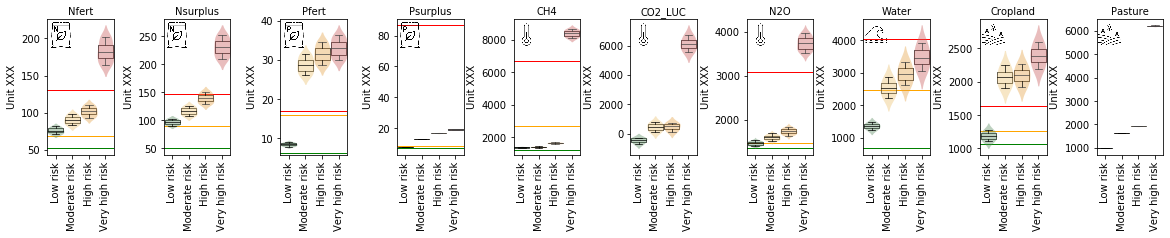

In [607]:
# Create grids and axes
fig = plt.figure(figsize=(20, 2.5))
grid = plt.GridSpec(1, 10, hspace=0.1, wspace=0.75)
axes = {}
for i in range(10):
    axes[0,i] = fig.add_subplot(grid[0, i])

n= 0
for b, bound in enumerate(boundaries):
    for i, ind in enumerate(boundary_inds[bound]):
        
        sns.violinplot(x="Scenario", y="Pred_avg",data=scenario_rep_all_ind_1D[ind], palette=['#519259','#FFC85C','#FFA62B', '#DD4A48'],
                       linewidth=0, ax=axes[0,n], scale='width', width=1)
        for violin, alpha in zip(axes[0, n].collections[::2], [.4, .4, .4, .4, .4]):
            violin.set_alpha(alpha)
        sns.boxplot(x="Scenario", y="Pred_avg",data=scenario_rep_all_ind_1D[ind],  width=0.9, linewidth=.7, 
                    ax=axes[0,n], palette=['#519259','#FFC85C','#FFA62B', '#DD4A48'], showfliers=False)

        for a,artist in enumerate(axes[0,n].artists):
            # Set the linecolor on the artist to the facecolor, and set the facecolor to None
            col = artist.get_facecolor()
            artist.set_edgecolor('black')
            artist.set_facecolor('None')

            # Each box has 6 associated Line2D objects (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour as above
            for t in range(a*5,a*5+5):
                line = axes[0,n].lines[t]
                line.set_color('black')
                line.set_mfc('black')
                line.set_mec('black')

        
        # Annotate the boundary levels
        if 'Min' in list(scenario_rep_all_ind_1D[ind]):
            mn = scenario_rep_all_ind_1D[ind]['Min'].iloc[0]
            md = scenario_rep_all_ind_1D[ind]['Mode'].iloc[0]
            mx = scenario_rep_all_ind_1D[ind]['Max'].iloc[0]
            axes[0,n].axhline(y=mn, xmin=0, xmax=1,   alpha=1, lw=1, c='green', zorder=-1)
            axes[0,n].axhline(y=md, xmin=0, xmax=1,   alpha=1, lw=1, c='orange', zorder=-1)
            axes[0,n].axhline(y=mx, xmin=0, xmax=1,  alpha=1, lw=1, c='red', zorder=-1)
        
        
        axes[0,n].set_title(ind, fontsize=10, pad=4) 
        axes[0,n].yaxis.set_label_text('Unit XXX', fontsize=10)
        x_labels = ['Low risk','Moderate risk','High risk','Very high risk']
        axes[0,n].set_xticklabels(x_labels, fontsize=10, rotation=90)
        axes[0,n].set_xlabel('')
        
        # Print the boundary icon and add subplot labels
        img_dir = 'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/PB_icons/'
        img = mpimg.imread(img_dir+bound+'.png')
        if bound in ['Biogeochemical_Flows_N', 'Biogeochemical_Flows_P']:
            zoom = .08
        else:
            zoom = .18
        imagebox = OffsetImage(img, zoom=zoom)
        ab = AnnotationBbox(imagebox, (.2, .88), xycoords='axes fraction', frameon=False)
        axes[0,n].add_artist(ab)
        
        
        n += 1

'''# Create legend 
legend_elements = [Line2D([0], [0], color='red', lw=2, dashes=(3, 5, 1, 5), label='Max'), 
                       Line2D([0], [0], color='orange', lw=2, dashes=(5, 5),  label='Mode'),
                       Line2D([0], [0], color='green', lw=2, dashes=(3, 1, 1, 1, 1, 1), label='Min')]


l = fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.12, -.4), 
           bbox_transform=fig.transFigure, frameon=False, 
           ncol=3, fontsize=13, title= "Boundary's levels",)
l.get_title().set_fontsize('13')''' 


plt.savefig('{}/Indicator_Violin_Plot_300dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=300,  bbox_inches='tight') 
plt.savefig('{}/Indicator_Violin_Plot.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
plt.savefig('{}/Indicator_Violin_Plot_600dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 


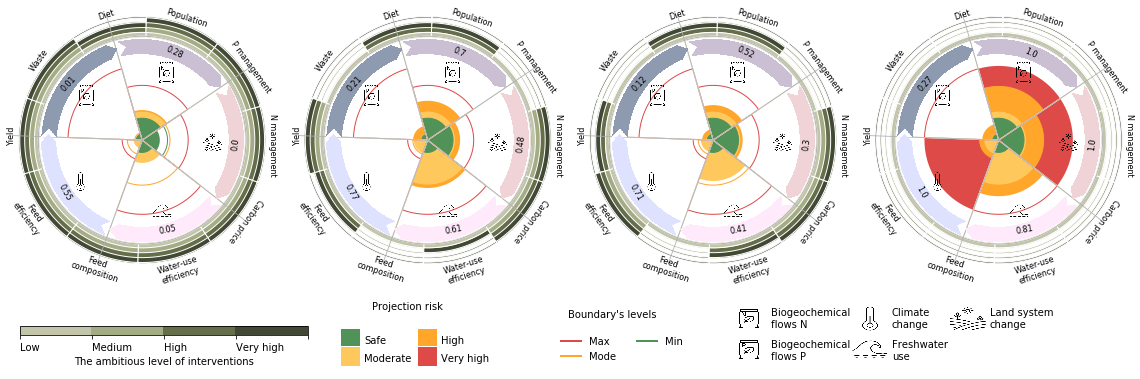

In [541]:
import os
import math
from textwrap import wrap
import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png


# Create the figure
fig = plt.figure(figsize=(20, 15.7))


# Set up the grid
grid = plt.GridSpec(1, 4, wspace=.1)

axes = {}
# Create the subplots for the bar polar charts
for i in range(4):
    axes[i] = fig.add_subplot(grid[0,i], projection='polar')
        

for c, colour in enumerate(['Low risk', 'Moderate risk', 'High risk', 'Very high risk']): #
        
    # Set the zero location of theta
    axes[c].set_theta_zero_location("N", offset=-20)

    # Draw the outer solution bars
    sol_bar_label = solutions # Set the labels for the outer layer (solutions)
    N1 = len(sol_bar_label) # the numbre of solutions
    theta1 = np.linspace(0, 2 * np.pi, N1, endpoint=False)
    width1 = 2*np.pi/N1

    # Solution ring for highly ambitous level
    values1 = list(pd_scenario_rep_sol_q[colour].iloc[0])
    axes[c].bar(theta1, values1, width=width1, bottom=7.0, color='#414833',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for ambitous level
    values = [x-.33 if x > 0.25 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.0, color='#656d4a',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for BAU level
    values = [x-.66 if x > 0.6 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.0, color='#a4ac86',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for low ambitous level
    values = [x-.99 if x > 0.95 else .26 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.0, color='#c2c5aa',
                   edgecolor='white',zorder=1,alpha=1)
    
    # Draw the boundary frame for solution bars
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=8.23, color='#414833',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.89, color='#656d4a',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.56, color='#a4ac86',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=7.23, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width1, bottom=6.9, color='#c2c5aa',
                   edgecolor='white', zorder=-1, alpha=1)
    
    
       

    # Draw the inner boundary bars
    bon_bar_label = boundaries # Set the labels for the inner layer (boundaries)
    N2 = len(bon_bar_label) # the numbre of boundaries
    theta2 = np.linspace(0, 2 * np.pi, N2, endpoint=False)
    width2 = 2*np.pi/N2
   
     
    #wedge_colours_temp = risk_col_list[colour]
    #boundary_colour = {'Biogeochemical_Flows': '#9B3675', 'Climate_Change':'#185ADB', 
                   #'Freshwater_Use':'#009DAE', 'Land_system_change':'#4AA96C'}
    #wedge_colours = [risk_colour[wedge_colours_temp[i]] for i in range(len(wedge_colours_temp))]
    
    
    # Wedges filled colour - predicted avg list(boundary_colour.values()
    values = pred_avg_norm[colour]
    
        
    for v, val in enumerate(values):
        # bound_min_norm for Climate change boundary is below zero. This causes issue in plotting. Here we replace it with temporary replaced it with zero for correction.
        if bound_min_norm[colour][v] < 0:
            bound_min_norm[colour][v] = 0
        
        
        col_r = [(.1,.2,.1, 0) for i in range(5)]
        col_o = [(.1,.2,.1, 0) for i in range(5)]
        col_y = [(.1,.2,.1, 0) for i in range(5)]
        col_g = [(.1,.2,.1, 0) for i in range(5)]
        if val > bound_max_norm[colour][v]: #red
            col_r[v] = '#DD4A48'
            col_o[v] = '#FFA62B'
            col_y[v] = '#FFC85C'
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_r,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_max_norm[colour][v], width=width2, bottom=0.0, color=col_o,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_mode_norm[colour][v], width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_min_norm[colour][v], width=width2, bottom=0.0, color=col_g,
                   edgecolor='none',zorder=1)

        if (val > bound_mode_norm[colour][v]) & (val <= bound_max_norm[colour][v]): #orange
            col_o[v] = '#FFA62B'
            col_y[v] = '#FFC85C'
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_o,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_mode_norm[colour][v], width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_min_norm[colour][v], width=width2, bottom=0.0, color=col_g,
                   edgecolor='none',zorder=1)

        if (val > bound_min_norm[colour][v]) & (val <= bound_mode_norm[colour][v]): # yellow
            col_y[v] = '#FFC85C'
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1)
            axes[c].bar(theta2, bound_min_norm[colour][v], width=width2, bottom=0, color=col_g,
                   edgecolor='none',zorder=1)

        if val <= bound_min_norm[colour][v]: #green
            col_g[v] = '#519259'
            axes[c].bar(theta2, values, width=width2, bottom=0, color=col_g,
                   edgecolor='none',zorder=1)


   
 
    
    # Boundary mode line
    values = bound_mode_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#FFA62B',zorder=1,alpha=1)
    # Boundary min line
    values = bound_min_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#519259',zorder=1,alpha=1)
    # Boundary max line
    values = bound_max_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#DD4A48',zorder=1,alpha=1)


    
    # Wedges border colour
    values = [7, 7, 7, 7, 7] # max normalised values of 'Nfert','Pfert', 'DirNonCO2', 'WaterUse', 'TotalAgArea'.
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#e6e8d5',zorder=1,alpha=1)
    
    # Annotate the solution and boundary label
    
    # Find the right angle for solution labels
    solution_angle = [math.degrees(theta1[i])-18 for i in range(10)]
    
    for n in range(N1):
        if n == 4:  # This condition is to adjust the solution label only
            axes[c].text(theta1[n], 9.1, 'Feed\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 5:
            axes[c].text(theta1[n], 9.1, 'Feed\ncomposition', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 6:
            axes[c].text(theta1[n], 9.1, 'Water-use\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta1[n], 8.8, solutions_name[solutions[n]], rotation=solution_angle[n],
                horizontalalignment='center', verticalalignment='center', fontsize=8)

    
    # Adjust the grids
    axes[c].spines['polar'].set_visible(False)
    #axes[c].grid(True)
    # Calculate the degree of theta grids from radians
    grid_angle = [math.degrees(theta2[i])+36 for i in range(5)]  
    axes[c].set_thetagrids(grid_angle, [], visible=True)
    axes[c].set_rgrids([0, 7], [], visible=True)
    
    
    # Print the PB icon
    img_dir = 'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/PB_icons/'
    
    
    for b, bound in enumerate(boundaries):
        img = mpimg.imread(img_dir+bound+'.png')
        img2 = mpimg.imread(img_dir+'arrows2'+'.png')
        if bound in ['Biogeochemical_Flows_N', 'Biogeochemical_Flows_P']:
            zoom = .06
        else:
            zoom = .15
        imagebox = OffsetImage(img, zoom=zoom)
        imagebox2 = OffsetImage(img2, zoom=.118)
        if b == 0:  # This condition is to adjust the icon position only / biogeochemical N
            ab = AnnotationBbox(imagebox, (theta2[b], 4.8), xycoords='data',  frameon=False)
        elif b == 1: # biogeochemical P
            ab = AnnotationBbox(imagebox, (theta2[b], 4.8), xycoords='data', frameon=False)
        elif b == 2: # climate
            ab = AnnotationBbox(imagebox, (theta2[b], 5), xycoords='data', frameon=False)
        elif b == 3: # water
            ab = AnnotationBbox(imagebox, (theta2[b], 5), xycoords='data', frameon=False)
        else: # land system
            ab = AnnotationBbox(imagebox, (theta2[b], 4.7), xycoords='data', frameon=False)
        
        axes[c].add_artist(ab)
        ab2 = AnnotationBbox(imagebox2, (0, 0), xycoords='data', frameon=False)
        axes[c].add_artist(ab2)
        
        
    # Annotate risk on each boundary
    # Find the right angle for risk labels
    solution_angle = [math.degrees(theta2[i])-25 for i in range(5)]
    for n in range(N2):
        if n == 0:  # This condition is to adjust the boundary risk label only
            axes[c].text(theta2[n], 6.3, round(risk_list[colour][n],2), rotation=solution_angle[n],
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
        elif n == 1:
            axes[c].text(theta2[n], 6.25, round(risk_list[colour][n],2), rotation=solution_angle[n],
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
        elif n == 2:
            axes[c].text(theta2[n], 6.25, round(risk_list[colour][n],2), rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
        elif n == 3:
            axes[c].text(theta2[n], 6.25, round(risk_list[colour][n],2), rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
            
        else:
            axes[c].text(theta2[n], 6.3, round(risk_list[colour][n],2), rotation=solution_angle[n]+180,
                horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)




# Create the legends
    
# Create the colorbar for the solution levels
# First, create a list of our values for colorbar
vals = [0, 1, 2, 3, 4]
val_labels = ['Low', 'Medium', 'High', 'Very high']

# Second, create the colour names with a function. 
colorbar_list = ['#c2c5aa', '#a4ac86', '#656d4a', '#414833']


# Third, create a ListedColormap object, which contains the information of the colours we want to display in our colourbar
cmap = mpl.colors.ListedColormap(colorbar_list)

# Set alpha
alpha_cmap = cmap(np.arange(cmap.N))
alpha_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
alpha_cmap = mpl.colors.ListedColormap(alpha_cmap)

# Fourth, set the colormap index for discrete color bar
norm = mpl.colors.BoundaryNorm(vals, alpha_cmap.N)

# Fifth, create the colorbar
axes[0] = fig.add_axes([0.5, 0.1, 0.03, 0.5]) 

cb = mpl.colorbar.ColorbarBase(axes[0], cmap=cmap,
                                norm=norm,
                                spacing='uniform',
                                orientation='horizontal',
                                extend='neither',
                                ticks=vals)
cb.set_ticklabels(val_labels)
for t in cb.ax.get_xticklabels():
    t.set_horizontalalignment('left') 

cb.set_label('The ambitious level of interventions', fontsize=10)
axes[0].set_position((.13, 0.33, 0.2, 0.008))  


    
legend_elements = [Line2D([0], [0], color='#DD4A48', lw=2, label='Max'),
                   Line2D([0], [0], color='#FFA62B', lw=2,   label='Mode'),
                   Line2D([0], [0], color='#519259', lw=2,  label='Min')]

l1 = fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.5, .35),  
                bbox_transform=fig.transFigure, title= "Boundary's levels", frameon=False,ncol=2)

l1.get_title().set_position((-10, 12))

legend_elements_2 = []

risks = ['Safe', 'Moderate', 'High', 'Very high']
riskcols = ['#519259', '#FFC85C', '#FFA62B', '#DD4A48']
for r, rk in enumerate(risks):
    legend_elements_2.append(Line2D([0], [0], marker="s", color='none', label=rk, 
                                  markersize=20, markeredgecolor='white', markerfacecolor=riskcols[r], alpha=1))

l2 = fig.legend(handles=legend_elements_2, loc='upper left', bbox_to_anchor=(.35, .3, .4, .05), frameon=False, 
           bbox_transform=fig.transFigure, ncol=2, title="Projection risk", 
           handlelength=1, columnspacing=1, handletextpad=.9, labelspacing=.01, fontsize=10, handleheight=2.4)

l2.get_title().set_position((-10, 20)) 
#l2.get_title().set_fontsize('10') 



# Create boundary legends by adding images
class ImageHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize,
                       trans):

        # enlarge the image by these margins
        sx, sy = self.image_stretch 

        # create a bounding box to house the image
        bb = Bbox.from_bounds(xdescent - sx,
                              ydescent - sy,
                              width + sx,
                              height + sy)

        tbb = TransformedBbox(bb, trans)
        image = BboxImage(tbb)
        image.set_data(self.image_data)

        self.update_prop(image, orig_handle, legend)

        return [image]

    def set_image(self, image_path, image_stretch=(0, 0)):
        if not os.path.exists(image_path):
            sample = get_sample_data("grace_hopper.png", asfileobj=False)
            self.image_data = read_png(sample)
        else:
            self.image_data = read_png(image_path)

        self.image_stretch = image_stretch

# setup the handler instance for the scattered data
custom_handler1 = ImageHandler()
custom_handler1.set_image(img_dir+'Biogeochemical_Flows_N'+'.png',
                         image_stretch=(20, 20))
custom_handler2 = ImageHandler()
custom_handler2.set_image(img_dir+'Biogeochemical_Flows_P'+'.png',
                         image_stretch=(20, 20))
custom_handler3 = ImageHandler()
custom_handler3.set_image(img_dir+'Climate_Change'+'.png',
                         image_stretch=(20, 20))
custom_handler4 = ImageHandler()
custom_handler4.set_image(img_dir+'Freshwater_Use'+'.png',
                         image_stretch=(20, 20))
custom_handler5 = ImageHandler()
custom_handler5.set_image(img_dir+'Land_system_change'+'.png',
                         image_stretch=(20, 20))

# plot two series of scatter data
# random data
x = np.random.randn(100)
y = np.random.randn(100)
y2 = np.random.randn(100)
y3 = np.random.randn(100)
y4 = np.random.randn(100)
y5 = np.random.randn(100)

s = plt.scatter(x, y, c='none')
s2 = plt.scatter(x, y2, c='none')
s3 = plt.scatter(x, y3, c='none')
s4 = plt.scatter(x, y4, c='none')
s5 = plt.scatter(x, y5, c='none')
# add the legend for the scattered data, mapping the
# scattered points to the custom handler
l3 = plt.legend([s, s2, s3, s4, s5],
           ['Biogeochemical\nflows N','Biogeochemical\nflows P', 'Climate\nchange', 'Freshwater\nuse', 'Land system\nchange'],
           handler_map={s: custom_handler1, s2: custom_handler2, s3: custom_handler3, s4: custom_handler4, s5: custom_handler5},
           labelspacing=1, ncol=3,handletextpad=.2,
           frameon=False, bbox_to_anchor=(2.5, 5.2), loc='upper left')    



for t in l3.get_texts():
    t.set_va('center_baseline') 

#plt.savefig('{}/Polar_Barchart_300dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=300,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 


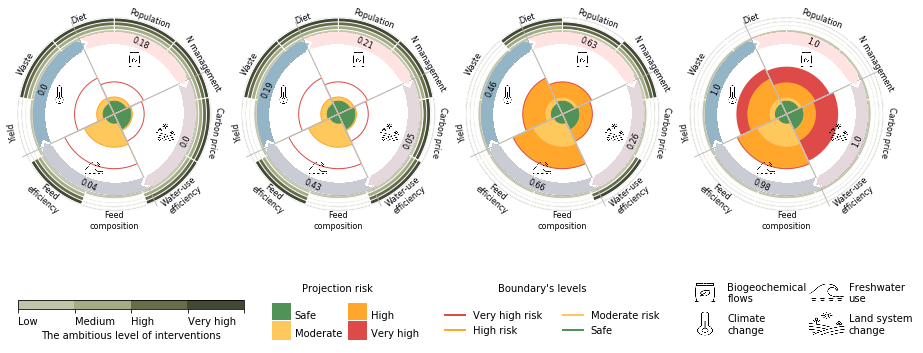

In [1475]:
import os
import math
from textwrap import wrap
import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png


# Create the figure
fig = plt.figure(figsize=(15.7, 15.7))

'''# Set up the grid
width_ratios = [1 ,1]
grid = plt.GridSpec(2, 2, hspace=.01, wspace=.01, height_ratios= [1, 1])

axes = {}
# Create the subplots for the bar polar charts
for i in range(2):
    for j in range(2):
        axes[i,j] = fig.add_subplot(grid[i,j], projection='polar')'''

# Set up the grid
grid = plt.GridSpec(1, 4, wspace=.1)

axes = {}
# Create the subplots for the bar polar charts
for i in range(4):
    axes[i] = fig.add_subplot(grid[0,i], projection='polar')
        

for c, colour in enumerate(['GREEN', 'YELLOW', 'ORANGE', 'RED']): # the colours here don't represent the risk colour in the original data, they represent very high risk, High risk, Moderate risk, and Safe'
        
    # Set the zero location of theta
    axes[c].set_theta_zero_location("N", offset=-20)

    # Draw the outer solution bars
    sol_bar_label = solutions # Set the labels for the outer layer (solutions)
    N1 = len(sol_bar_label) # the numbre of solutions
    theta1 = np.linspace(0, 2 * np.pi, N1, endpoint=False)
    width1 = 2*np.pi/N1

    # Solution ring for highly ambitous level
    values1 = list(pd_scenario_rep_sol_q[colour].iloc[0])
    axes[c].bar(theta1, values1, width=width, bottom=7.0, color='#414833',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for ambitous level
    values = [x-.33 if x > 0.25 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.0, color='#656d4a',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for BAU level
    values = [x-.66 if x > 0.6 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.0, color='#a4ac86',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for low ambitous level
    values = [x-.99 if x > 0.95 else .26 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.0, color='#c2c5aa',
                   edgecolor='white',zorder=1,alpha=1)
    
    # Draw the boundary frame for solution bars
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=8.23, color='#414833',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.89, color='#656d4a',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.56, color='#a4ac86',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.23, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=6.9, color='#c2c5aa',
                   edgecolor='white', zorder=-1, alpha=1)
    
    
       

    # Draw the inner boundary bars
    bon_bar_label = boundaries # Set the labels for the inner layer (boundaries)
    N2 = len(bon_bar_label) # the numbre of boundaries
    theta2 = np.linspace(0, 2 * np.pi, N2, endpoint=False)
    width2 = 2*np.pi/N2
   
     
    wedge_colours_temp = risk_col_list[colour]
    boundary_colour = {'Biogeochemical_Flows': '#9B3675', 'Climate_Change':'#185ADB', 
                   'Freshwater_Use':'#009DAE', 'Land_system_change':'#4AA96C'}
    #wedge_colours = [risk_colour[wedge_colours_temp[i]] for i in range(len(wedge_colours_temp))]
    
    
    # Wedges filled colour - predicted avg list(boundary_colour.values()
    values = pred_avg_norm[colour]
    
    col_r = []
    col_o = []
    col_y = []
    col_g = []
    for v, val in enumerate(values):
        if val > bound_max_norm[colour][v]: #red
            col_r.append('#DD4A48') #red
            col_o.append('#FFA62B') #orange
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif (val > bound_mode_norm[colour][v]) & (val <= bound_max_norm[colour][v]): #orange
            col_o.append('#FFA62B') #orange
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif (val > bound_min_norm[colour][v]) & (val <= bound_mode_norm[colour][v]): # yellow
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif val <= bound_min_norm[colour][v]: #green
            col_g.append('#519259') #green
        else:
            col_r.append((.1,.2,.1, 0))
            col_o.append((.1,.2,.1, 0))
            col_y.append((.1,.2,.1, 0))
            col_g.append((.1,.2,.1, 0))
    
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_r,
                   edgecolor='none',zorder=1)
    axes[c].bar(theta2, bound_max_norm[colour], width=width2, bottom=0.0, color=col_o,
                   edgecolor='none',zorder=1) 
    axes[c].bar(theta2, bound_mode_norm[colour], width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1) 
    axes[c].bar(theta2, bound_min_norm[colour], width=width2, bottom=0.0, color=col_g,
                   edgecolor='none',zorder=1) 
   
 
    
    # Wedges filled colour - boundary mode
    values = bound_mode_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#FFA62B',zorder=1,alpha=1)
    # Wedges filled colour - boundary min
    values = bound_min_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#519259',zorder=1,alpha=1)
    # Wedges filled colour - boundary max
    values = bound_max_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#DD4A48',zorder=1,alpha=1)


    
    # Wedges border colour
    values = [7, 7, 7, 7] # max normalised values of 'Nfert', 'DirNonCO2', 'WaterUse', 'TotalAgArea'.
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#e6e8d5',zorder=1,alpha=1)
    


    

    
    # Annotate the solution and boundary label
    
    # Find the right angle for solution labels
    solution_angle = [math.degrees(theta1[i])-20 for i in range(9)]
    
    for n in range(N):
        if n == 4:  # This condition is to adjust the solution label only
            axes[c].text(theta1[n], 9.1, 'Feed\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 5:
            axes[c].text(theta1[n], 9.1, 'Feed\ncomposition', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 6:
            axes[c].text(theta1[n], 9.1, 'Water-use\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta1[n], 8.8, solutions_name[solutions[n]], rotation=solution_angle[n],
                horizontalalignment='center', verticalalignment='center', fontsize=8)

    
    # Adjust the grids
    axes[c].spines['polar'].set_visible(False)
    #axes[c].grid(True)
    # Calculate the degree of theta grids from radians
    grid_angle = [math.degrees(theta2[i])+45 for i in range(4)]  
    axes[c].set_thetagrids(grid_angle, [], visible=True)
    axes[c].set_rgrids([0, 7], [], visible=True)
    
    
    # Print the PB icon
    img_dir = 'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/PB_icons/'
    
    
    for b, bound in enumerate(boundaries):
        img = mpimg.imread(img_dir+bound+'.png')
        img2 = mpimg.imread(img_dir+'arrows2'+'.png')
        imagebox = OffsetImage(img, zoom=.15)
        imagebox2 = OffsetImage(img2, zoom=.095)
        if b == 0:  # This condition is to adjust the icon position only / biogeochemical
            ab = AnnotationBbox(imagebox, (theta2[b], 5), xycoords='data',  frameon=False)
        elif b == 1: # climate
            ab = AnnotationBbox(imagebox, (theta2[b], 5), xycoords='data', frameon=False)
        elif b == 2: # water
            ab = AnnotationBbox(imagebox, (theta2[b], 5), xycoords='data', frameon=False)
        else: # land system
            ab = AnnotationBbox(imagebox, (theta2[b], 4.7), xycoords='data', frameon=False)
        
        axes[c].add_artist(ab)
        ab2 = AnnotationBbox(imagebox2, (0, 0), xycoords='data', frameon=False)
        axes[c].add_artist(ab2)
        
        
    # Annotate risk on each boundary
    # Find the right angle for risk labels
    solution_angle = [math.degrees(theta2[i])-25 for i in range(4)]
    for n in range(N2):
        if n == 0:  # This condition is to adjust the boundary risk label only
            axes[c].text(theta2[n], 6.5, round(risk_list[colour][n],2), rotation=solution_angle[n],
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
        elif n == 1:
            axes[c].text(theta2[n], 6.4, round(risk_list[colour][n],2), rotation=solution_angle[n],
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
        elif n == 2:
            axes[c].text(theta2[n], 6.4, round(risk_list[colour][n],2), rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)
            
        else:
            axes[c].text(theta2[n], 6.5, round(risk_list[colour][n],2), rotation=solution_angle[n]+180,
                horizontalalignment='center', verticalalignment='center', zorder=10, fontsize=8)




# Create the legends
    
# Create the colorbar for the solution levels
# First, create a list of our values for colorbar
vals = [0, 1, 2, 3, 4]
val_labels = ['Low', 'Medium', 'High', 'Very high']

# Second, create the colour names with a function. 
colorbar_list = ['#c2c5aa', '#a4ac86', '#656d4a', '#414833']


# Third, create a ListedColormap object, which contains the information of the colours we want to display in our colourbar
cmap = mpl.colors.ListedColormap(colorbar_list)

# Set alpha
alpha_cmap = cmap(np.arange(cmap.N))
alpha_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
alpha_cmap = mpl.colors.ListedColormap(alpha_cmap)

# Fourth, set the colormap index for discrete color bar
norm = mpl.colors.BoundaryNorm(vals, alpha_cmap.N)

# Fifth, create the colorbar
axes[0] = fig.add_axes([0.5, 0.1, 0.03, 0.5]) 

cb = mpl.colorbar.ColorbarBase(axes[0], cmap=cmap,
                                norm=norm,
                                spacing='uniform',
                                orientation='horizontal',
                                extend='neither',
                                ticks=vals)
cb.set_ticklabels(val_labels)
for t in cb.ax.get_xticklabels():
    t.set_horizontalalignment('left') 

cb.set_label('The ambitious level of interventions', fontsize=10)
axes[0].set_position((.13, 0.33, 0.2, 0.008))  


    
    
legend_elements = [Line2D([0], [0], color='#DD4A48', lw=2, label='Very high risk'),
                   Line2D([0], [0], color='#FFA62B', lw=2,   label='High risk'),
                   Line2D([0], [0], color='#FFC85C', lw=2, label='Moderate risk'),
                   Line2D([0], [0], color='#519259', lw=2,  label='Safe')]

l1 = fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.5, .35),  
                bbox_transform=fig.transFigure, title= "Boundary's levels", frameon=False,ncol=2)

l1.get_title().set_position((-10, 12))

legend_elements_2 = []

risks = ['Safe', 'Moderate', 'High', 'Very high']
riskcols = ['#519259', '#FFC85C', '#FFA62B', '#DD4A48']
for r, rk in enumerate(risks):
    legend_elements_2.append(Line2D([0], [0], marker="s", color='none', label=rk, 
                                  markersize=20, markeredgecolor='white', markerfacecolor=riskcols[r], alpha=1))

l2 = fig.legend(handles=legend_elements_2, loc='upper left', bbox_to_anchor=(.35, .3, .4, .05), frameon=False, 
           bbox_transform=fig.transFigure, ncol=2, title="Projection risk", 
           handlelength=1, columnspacing=1, handletextpad=.9, labelspacing=.01, fontsize=10, handleheight=2.4)

l2.get_title().set_position((-10, 12)) 
#l2.get_title().set_fontsize('10') 



# Create boundary legends by adding images
class ImageHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize,
                       trans):

        # enlarge the image by these margins
        sx, sy = self.image_stretch 

        # create a bounding box to house the image
        bb = Bbox.from_bounds(xdescent - sx,
                              ydescent - sy,
                              width + sx,
                              height + sy)

        tbb = TransformedBbox(bb, trans)
        image = BboxImage(tbb)
        image.set_data(self.image_data)

        self.update_prop(image, orig_handle, legend)

        return [image]

    def set_image(self, image_path, image_stretch=(0, 0)):
        if not os.path.exists(image_path):
            sample = get_sample_data("grace_hopper.png", asfileobj=False)
            self.image_data = read_png(sample)
        else:
            self.image_data = read_png(image_path)

        self.image_stretch = image_stretch

# setup the handler instance for the scattered data
custom_handler1 = ImageHandler()
custom_handler1.set_image(img_dir+'Biogeochemical_Flows'+'.png',
                         image_stretch=(20, 20))
custom_handler2 = ImageHandler()
custom_handler2.set_image(img_dir+'Climate_Change'+'.png',
                         image_stretch=(20, 20))
custom_handler3 = ImageHandler()
custom_handler3.set_image(img_dir+'Freshwater_Use'+'.png',
                         image_stretch=(20, 20))
custom_handler4 = ImageHandler()
custom_handler4.set_image(img_dir+'Land_system_change'+'.png',
                         image_stretch=(20, 20))

# plot two series of scatter data
# random data
x = np.random.randn(100)
y = np.random.randn(100)
y2 = np.random.randn(100)
y3 = np.random.randn(100)
y4 = np.random.randn(100)
s = plt.scatter(x, y, c='none')
s2 = plt.scatter(x, y2, c='none')
s3 = plt.scatter(x, y3, c='none')
s4 = plt.scatter(x, y4, c='none')

# add the legend for the scattered data, mapping the
# scattered points to the custom handler
l3 = plt.legend([s, s2, s3, s4],
           ['Biogeochemical\nflows', 'Climate\nchange', 'Freshwater\nuse', 'Land system\nchange'],
           handler_map={s: custom_handler1, s2: custom_handler2, s3: custom_handler3, s4: custom_handler4},
           labelspacing=1, ncol=2,handletextpad=.2,
           frameon=False, bbox_to_anchor=(3.0, 5.2), loc='upper left')    



for t in l3.get_texts():
    t.set_va('center_baseline') 

plt.savefig('{}/Polar_Barchart_300dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=300,  bbox_inches='tight') 
plt.savefig('{}/Polar_Barchart.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
plt.savefig('{}/Polar_Barchart.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 


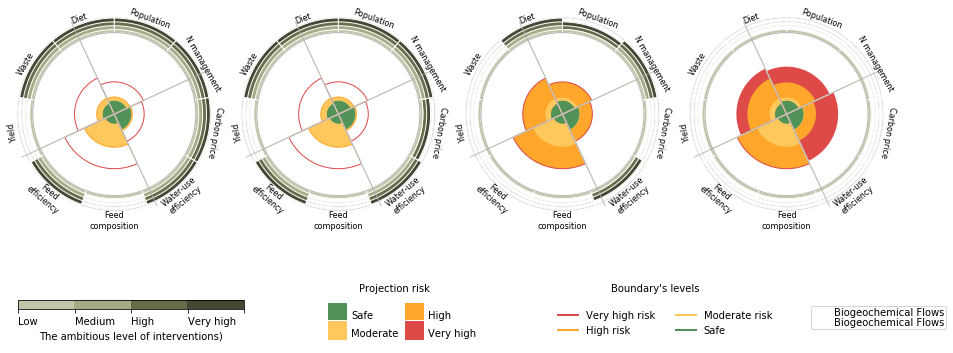

In [1390]:
import os
import math
from textwrap import wrap
import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.image import BboxImage
from matplotlib.legend_handler import HandlerBase
from matplotlib._png import read_png


# Create the figure
fig = plt.figure(figsize=(15.7, 15.7))

'''# Set up the grid
width_ratios = [1 ,1]
grid = plt.GridSpec(2, 2, hspace=.01, wspace=.01, height_ratios= [1, 1])

axes = {}
# Create the subplots for the bar polar charts
for i in range(2):
    for j in range(2):
        axes[i,j] = fig.add_subplot(grid[i,j], projection='polar')'''

# Set up the grid
grid = plt.GridSpec(1, 4, wspace=.1)

axes = {}
# Create the subplots for the bar polar charts
for i in range(4):
    axes[i] = fig.add_subplot(grid[0,i], projection='polar')
        

for c, colour in enumerate(['GREEN', 'YELLOW', 'ORANGE', 'RED']): # the colours here don't represent the risk colour in the original data, they represent very high risk, High risk, Moderate risk, and Safe'
        
    # Set the zero location of theta
    axes[c].set_theta_zero_location("N", offset=-20)

    # Draw the outer solution bars
    sol_bar_label = solutions # Set the labels for the outer layer (solutions)
    N1 = len(sol_bar_label) # the numbre of solutions
    theta1 = np.linspace(0, 2 * np.pi, N1, endpoint=False)
    width1 = 2*np.pi/N1

    # Solution ring for highly ambitous level
    values1 = list(pd_scenario_rep_sol_q[colour].iloc[0])
    axes[c].bar(theta1, values1, width=width, bottom=7.0, color='#414833',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for ambitous level
    values = [x-.33 if x > 0.25 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.0, color='#656d4a',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for BAU level
    values = [x-.66 if x > 0.6 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.0, color='#a4ac86',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for low ambitous level
    values = [x-.99 if x > 0.95 else .26 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.0, color='#c2c5aa',
                   edgecolor='white',zorder=1,alpha=1)
    
    # Draw the boundary frane for solution bars
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=8.23, color='#414833',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.89, color='#656d4a',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.56, color='#a4ac86',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=7.23, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=6.9, color='#c2c5aa',
                   edgecolor='white', zorder=-1, alpha=1)
    
    
       

    # Draw the inner boundary bars
    bon_bar_label = boundaries # Set the labels for the inner layer (boundaries)
    N2 = len(bon_bar_label) # the numbre of boundaries
    theta2 = np.linspace(0, 2 * np.pi, N2, endpoint=False)
    width2 = 2*np.pi/N2
   
     
    wedge_colours_temp = risk_col_list[colour]
    boundary_colour = {'Biogeochemical_Flows': '#9B3675', 'Climate_Change':'#185ADB', 
                   'Freshwater_Use':'#009DAE', 'Land_system_change':'#4AA96C'}
    #wedge_colours = [risk_colour[wedge_colours_temp[i]] for i in range(len(wedge_colours_temp))]
    
    
    # Wedges filled colour - predicted avg list(boundary_colour.values()
    values = pred_avg_norm[colour]
    
    col_r = []
    col_o = []
    col_y = []
    col_g = []
    for v, val in enumerate(values):
        if val > bound_max_norm[colour][v]: #red
            col_r.append('#DD4A48') #red
            col_o.append('#FFA62B') #orange
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif (val > bound_mode_norm[colour][v]) & (val <= bound_max_norm[colour][v]): #orange
            col_o.append('#FFA62B') #orange
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif (val > bound_min_norm[colour][v]) & (val <= bound_mode_norm[colour][v]): # yellow
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif val <= bound_min_norm[colour][v]: #green
            col_g.append('#519259') #green
        else:
            col_r.append((.1,.2,.1, 0))
            col_o.append((.1,.2,.1, 0))
            col_y.append((.1,.2,.1, 0))
            col_g.append((.1,.2,.1, 0))
    
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_r,
                   edgecolor='none',zorder=1)
    axes[c].bar(theta2, bound_max_norm[colour], width=width2, bottom=0.0, color=col_o,
                   edgecolor='none',zorder=1) 
    axes[c].bar(theta2, bound_mode_norm[colour], width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1) 
    axes[c].bar(theta2, bound_min_norm[colour], width=width2, bottom=0.0, color=col_g,
                   edgecolor='none',zorder=1) 
   
 
    
    # Wedges filled colour - boundary mode
    values = bound_mode_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#FFA62B',zorder=1,alpha=1)
    # Wedges filled colour - boundary min
    values = bound_min_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#519259',zorder=1,alpha=1)
    # Wedges filled colour - boundary max
    values = bound_max_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#DD4A48',zorder=1,alpha=1)


    
    # Wedges border colour
    values = [7, 7, 7, 7] # max normalised values of 'Nfert', 'DirNonCO2', 'WaterUse', 'TotalAgArea'.
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#e6e8d5',zorder=1,alpha=1)
    


    

    
    # Annotate the solution and boundary label
    
    # Find the right angle for solution labels
    solution_angle = [math.degrees(theta1[i])-20 for i in range(9)]
    
    for n in range(N):
        if n == 4:  # This condition is to adjust the solution label only
            axes[c].text(theta1[n], 9.1, 'Feed\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 5:
            axes[c].text(theta1[n], 9.1, 'Feed\ncomposition', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 6:
            axes[c].text(theta1[n], 9.1, 'Water-use\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta1[n], 8.8, solutions_name[solutions[n]], rotation=solution_angle[n],
                horizontalalignment='center', verticalalignment='center', fontsize=8)
            
            
    '''for n in range(N2):
        if n == 0:  # This condition is to adjust the solution label only
            axes[c].text(theta2[n], 3, 'Biogeochemical\nFlows', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 1:
            axes[c].text(theta2[n], 3, 'Climate\nChange', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 2:
            axes[c].text(theta2[n], 3, 'Freshwater\nUse', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta2[n], 3, 'Land System\nChange', rotation=0,
                horizontalalignment='center', verticalalignment='center', fontsize=8)'''

    
    # Adjust the grids
    axes[c].spines['polar'].set_visible(False)
    #axes[c].grid(True)
    # Calculate the degree of theta grids from radians
    grid_angle = [math.degrees(theta2[i])+45 for i in range(4)]  
    axes[c].set_thetagrids(grid_angle, [], visible=True)
    axes[c].set_rgrids([0, 7], [], visible=True)
    
    
    # Print the PB icon
    img_dir = 'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/PB_icons/'
    
    # Find the right angle for solution labels
    solution_angle = [math.degrees(theta2[i])-45 for i in range(4)]
    for b, bound in enumerate(boundaries):
        img = mpimg.imread(img_dir+bound+'.png')
        img2 = mpimg.imread(img_dir+'arrows2'+'.png')
        imagebox = OffsetImage(img, zoom=.15)
        imagebox2 = OffsetImage(img2, zoom=.09)
        if b == 0:  # This condition is to adjust the icon position only / biogeochemical
            ab = AnnotationBbox(imagebox, (theta2[b], 4.8), xycoords='data',  frameon=False)
        elif b == 1: # climate
            ab = AnnotationBbox(imagebox, (theta2[b], 4.9), xycoords='data', frameon=False)
        elif b == 2: # water
            ab = AnnotationBbox(imagebox, (theta2[b], 4.8), xycoords='data', frameon=False)
        else: # land system
            ab = AnnotationBbox(imagebox, (theta2[b], 4.6), xycoords='data', frameon=False)
        
        #axes[c].add_artist(ab)
        ab2 = AnnotationBbox(imagebox2, (0, 0), xycoords='data', frameon=False)
        #axes[c].add_artist(ab2)




# Create the legends
    
# Create the colorbar for the solution levels
# First, create a list of our values for colorbar
vals = [0, 1, 2, 3, 4]
val_labels = ['Low', 'Medium', 'High', 'Very high']

# Second, create the colour names with a function. 
colorbar_list = ['#c2c5aa', '#a4ac86', '#656d4a', '#414833']


# Third, create a ListedColormap object, which contains the information of the colours we want to display in our colourbar
cmap = mpl.colors.ListedColormap(colorbar_list)

# Set alpha
alpha_cmap = cmap(np.arange(cmap.N))
alpha_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
alpha_cmap = mpl.colors.ListedColormap(alpha_cmap)

# Fourth, set the colormap index for discrete color bar
norm = mpl.colors.BoundaryNorm(vals, alpha_cmap.N)

# Fifth, create the colorbar
axes[0] = fig.add_axes([0.5, 0.1, 0.03, 0.5]) 

cb = mpl.colorbar.ColorbarBase(axes[0], cmap=cmap,
                                norm=norm,
                                spacing='uniform',
                                orientation='horizontal',
                                extend='neither',
                                ticks=vals)
cb.set_ticklabels(val_labels)
for t in cb.ax.get_xticklabels():
    t.set_horizontalalignment('left') 

cb.set_label('The ambitious level of interventions)', fontsize=10)
axes[0].set_position((.13, 0.33, 0.2, 0.008))  


    
    
legend_elements = [Line2D([0], [0], color='#DD4A48', lw=2, label='Very high risk'),
                   Line2D([0], [0], color='#FFA62B', lw=2,   label='High risk'),
                   Line2D([0], [0], color='#FFC85C', lw=2, label='Moderate risk'),
                   Line2D([0], [0], color='#519259', lw=2,  label='Safe')]

l1 = fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.6, .35),  
                bbox_transform=fig.transFigure, title= "Boundary's levels", frameon=False,ncol=2)

l1.get_title().set_position((-10, 12))

legend_elements_2 = []

risks = ['Safe', 'Moderate', 'High', 'Very high']
riskcols = ['#519259', '#FFC85C', '#FFA62B', '#DD4A48']
for r, rk in enumerate(risks):
    legend_elements_2.append(Line2D([0], [0], marker="s", color='none', label=rk, 
                                  markersize=20, markeredgecolor='white', markerfacecolor=riskcols[r], alpha=1))

l2 = fig.legend(handles=legend_elements_2, loc='upper left', bbox_to_anchor=(.4, .3, .4, .05), frameon=False, 
           bbox_transform=fig.transFigure, ncol=2, title="Projection risk", 
           handlelength=1, columnspacing=1, handletextpad=.9, labelspacing=.01, fontsize=10, handleheight=2.4)

l2.get_title().set_position((-10, 12)) 
#l2.get_title().set_fontsize('10') 



# Create boundary legends by adding images
class HandlerLineImage(HandlerBase):

    def __init__(self, path, space=15, offset = 10 ):
        self.space=space
        self.offset=offset
        self.image_data = plt.imread(path)        
        super(HandlerLineImage, self).__init__()

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):

        l = mpl.lines.Line2D([xdescent+self.offset,xdescent+(width-self.space)/3.+self.offset],
                                     [ydescent+height/2., ydescent+height/2.])
        l.update_from(orig_handle)
        l.set_clip_on(False)
        l.set_transform(trans)

        bb = Bbox.from_bounds(xdescent +(width+self.space)/3.+self.offset,
                              ydescent,
                              height*self.image_data.shape[1]/self.image_data.shape[0],
                              height)

        tbb = TransformedBbox(bb, trans)
        image = BboxImage(tbb)
        image.set_data(self.image_data)

        self.update_prop(image, orig_handle, legend)
        return [l,image]
    

line,  = plt.plot([1,2],[1.5,3], color="none", lw=1.3)
line2,  = plt.plot([1,2],[1,2], color="none", lw=1.3)
    
plt.legend([line, line2], ["Biogeochemical Flows", "Biogeochemical Flows"],
   handler_map={ line: HandlerLineImage(img_dir+'Biogeochemical_Flows'+'.png'), 
                line2: HandlerLineImage(img_dir+'Biogeochemical_Flows'+'.png')}, 
   handlelength=2, labelspacing=0.0, fontsize=10, borderpad=0.15, loc=2, bbox_to_anchor=(3.5, .5, .4, .05),
    handletextpad=0.2, borderaxespad=0.15 )

        



#plt.savefig('{}/Polar_Barchart_300dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=300,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 


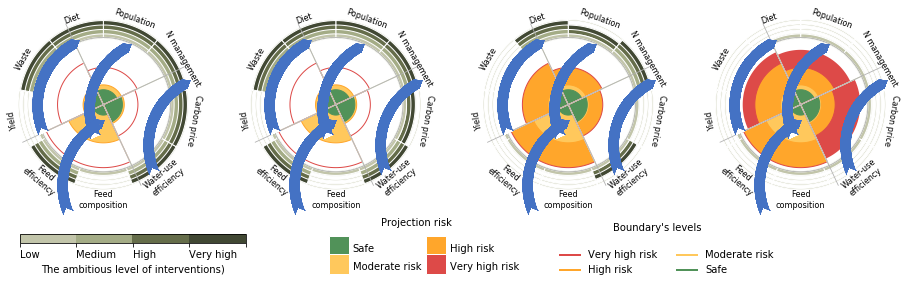

In [1327]:
import math
from textwrap import wrap
import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox


# Create the figure
fig = plt.figure(figsize=(15.7, 15.7))

'''# Set up the grid
width_ratios = [1 ,1]
grid = plt.GridSpec(2, 2, hspace=.01, wspace=.01, height_ratios= [1, 1])

axes = {}
# Create the subplots for the bar polar charts
for i in range(2):
    for j in range(2):
        axes[i,j] = fig.add_subplot(grid[i,j], projection='polar')'''

# Set up the grid
grid = plt.GridSpec(1, 4, wspace=.3)

axes = {}
# Create the subplots for the bar polar charts
for i in range(4):
    axes[i] = fig.add_subplot(grid[0,i], projection='polar')
        

for c, colour in enumerate(['GREEN', 'YELLOW', 'ORANGE', 'RED']): # the colours here don't represent the risk colour in the original data, they represent very high risk, High risk, Moderate risk, and Safe'
        
    # Set the zero location of theta
    axes[c].set_theta_zero_location("N", offset=-20)

    # Draw the outer solution bars
    sol_bar_label = solutions # Set the labels for the outer layer (solutions)
    N1 = len(sol_bar_label) # the numbre of solutions
    theta1 = np.linspace(0, 2 * np.pi, N1, endpoint=False)
    width1 = 2*np.pi/N1

    # Solution ring for highly ambitous level
    values1 = list(pd_scenario_rep_sol_q[colour].iloc[0])
    axes[c].bar(theta1, values1, width=width, bottom=5.0, color='#414833',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for ambitous level
    values = [x-.33 if x > 0.25 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.0, color='#656d4a',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for BAU level
    values = [x-.66 if x > 0.6 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.0, color='#a4ac86',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for low ambitous level
    values = [x-.99 if x > 0.95 else .26 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.0, color='#c2c5aa',
                   edgecolor='white',zorder=1,alpha=1)
    
    # Draw the boundary frane for solution bars
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=6.23, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.89, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.56, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.23, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=4.9, color='#c2c5aa',
                   edgecolor='white', zorder=-1, alpha=1)
    
    
       

    # Draw the inner boundary bars
    bon_bar_label = boundaries # Set the labels for the inner layer (boundaries)
    N2 = len(bon_bar_label) # the numbre of boundaries
    theta2 = np.linspace(0, 2 * np.pi, N2, endpoint=False)
    width2 = 2*np.pi/N2
   
     
    wedge_colours_temp = risk_col_list[colour]
    boundary_colour = {'Biogeochemical_Flows': '#9B3675', 'Climate_Change':'#185ADB', 
                   'Freshwater_Use':'#009DAE', 'Land_system_change':'#4AA96C'}
    #wedge_colours = [risk_colour[wedge_colours_temp[i]] for i in range(len(wedge_colours_temp))]
    
    
    # Wedges filled colour - predicted avg list(boundary_colour.values()
    values = pred_avg_norm[colour]
    
    col_r = []
    col_o = []
    col_y = []
    col_g = []
    for v, val in enumerate(values):
        if val > bound_max_norm[colour][v]: #red
            col_r.append('#DD4A48') #red
            col_o.append('#FFA62B') #orange
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif (val > bound_mode_norm[colour][v]) & (val <= bound_max_norm[colour][v]): #orange
            col_o.append('#FFA62B') #orange
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif (val > bound_min_norm[colour][v]) & (val <= bound_mode_norm[colour][v]): # yellow
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif val <= bound_min_norm[colour][v]: #green
            col_g.append('#519259') #green
        else:
            col_r.append((.1,.2,.1, 0))
            col_o.append((.1,.2,.1, 0))
            col_y.append((.1,.2,.1, 0))
            col_g.append((.1,.2,.1, 0))
    
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_r,
                   edgecolor='none',zorder=1)
    axes[c].bar(theta2, bound_max_norm[colour], width=width2, bottom=0.0, color=col_o,
                   edgecolor='none',zorder=1) 
    axes[c].bar(theta2, bound_mode_norm[colour], width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1) 
    axes[c].bar(theta2, bound_min_norm[colour], width=width2, bottom=0.0, color=col_g,
                   edgecolor='none',zorder=1) 
   
 
    
    # Wedges filled colour - boundary mode
    values = bound_mode_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#FFA62B',zorder=1,alpha=1)
    # Wedges filled colour - boundary min
    values = bound_min_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#519259',zorder=1,alpha=1)
    # Wedges filled colour - boundary max
    values = bound_max_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#DD4A48',zorder=1,alpha=1)


    
    # Wedges border colour
    values = [5, 5, 5, 5] # max normalised values of 'Nfert', 'DirNonCO2', 'WaterUse', 'TotalAgArea'.
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#e6e8d5',zorder=1,alpha=1)
    


    

    
    # Annotate the solution and boundary label
    
    # Find the right angle for solution labels
    solution_angle = [math.degrees(theta1[i])-20 for i in range(9)]
    
    for n in range(N):
        if n == 4:  # This condition is to adjust the solution label only
            axes[c].text(theta1[n], 7.1, 'Feed\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 5:
            axes[c].text(theta1[n], 7.1, 'Feed\ncomposition', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 6:
            axes[c].text(theta1[n], 7.1, 'Water-use\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta1[n], 6.8, solutions_name[solutions[n]], rotation=solution_angle[n],
                horizontalalignment='center', verticalalignment='center', fontsize=8)
            
            
    '''for n in range(N2):
        if n == 0:  # This condition is to adjust the solution label only
            axes[c].text(theta2[n], 3, 'Biogeochemical\nFlows', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 1:
            axes[c].text(theta2[n], 3, 'Climate\nChange', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 2:
            axes[c].text(theta2[n], 3, 'Freshwater\nUse', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta2[n], 3, 'Land System\nChange', rotation=0,
                horizontalalignment='center', verticalalignment='center', fontsize=8)'''

    
    # Adjust the grids
    axes[c].spines['polar'].set_visible(False)
    #axes[c].grid(True)
    # Calculate the degree of theta grids from radians
    grid_angle = [math.degrees(theta2[i])+45 for i in range(4)]  
    axes[c].set_thetagrids(grid_angle, [], visible=True)
    axes[c].set_rgrids([0, 5], [], visible=True)
    
    
    # Print the PB icon
    img_dir = 'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/PB_icons/'
    
    # Find the right angle for solution labels
    solution_angle = [math.degrees(theta2[i])-45 for i in range(4)]
    for b, bound in enumerate(boundaries):
        #img = mpimg.imread(img_dir+bound+'.png')
        img2 = mpimg.imread(img_dir+'arrows'+'.png')
        #imagebox = OffsetImage(img, zoom=.8)
        imagebox2 = OffsetImage(img2, zoom=.25)
        if b == 0:  # This condition is to adjust the icon position only / biogeochemical
            #ab = AnnotationBbox(imagebox, (theta2[b], 3.9), xycoords='data',  frameon=False)
            ab2 = AnnotationBbox(imagebox2, (theta2[b], 1), xycoords='data',  frameon=False)# the XY in annotation is based on theta (0-360) and r
        elif b == 1: # climate
            #ab = AnnotationBbox(imagebox, (theta2[b], 4.2), xycoords='data', frameon=False)
            ab2 = AnnotationBbox(imagebox2, (theta2[b], 3.8), xycoords='data', frameon=False)
        elif b == 2: # water
            #ab = AnnotationBbox(imagebox, (theta2[b], 3.9), xycoords='data', frameon=False)
            ab2 = AnnotationBbox(imagebox2, (theta2[b], 5), xycoords='data', frameon=False)
        else: # land system
            #ab = AnnotationBbox(imagebox, (theta2[b], 3.8), xycoords='data', frameon=False)
            ab2 = AnnotationBbox(imagebox2, (theta2[b], 5), xycoords='data', frameon=False)
        
        #axes[c].add_artist(ab)
        axes[c].add_artist(ab2)


    
    '''# Draw the red, orange, yellow, and green shaded areas inside the polar plot.
    theta3 = np.linspace(0.0, 2 * np.pi, 1000, endpoint=True)
    r = 0+0*theta3
    r2 = 1 + 0*theta3
    r3 = 2 + 0*theta3
    r4 = 3 + 0*theta3
    r5 = 4 + 0*theta3
    #axes[y,t].plot(theta_2, r, lw=.1, color='none')
    axes[c].plot(theta3, r2, lw=.1, color='green',alpha=.5,zorder=-100)
    axes[c].plot(theta3, r3, lw=.1, color='#fddb3a',alpha=.5,zorder=-100)
    axes[c].plot(theta3, r4, lw=.1,color='#eb8242',alpha=.5,zorder=-100)
    axes[c].plot(theta3, r5, lw=.1,color='red',alpha=.5)
    axes[c].fill_between(theta3, r, r2, fc='green', alpha=0.5,ec='none',zorder=-100)
    axes[c].fill_between(theta3, r2, r3, fc='#fddb3a', alpha=0.5,ec='none',zorder=-100)
    axes[c].fill_between(theta3, r3, r4, fc='#eb8242',alpha=0.5,ec='none',zorder=-100)
    axes[c].fill_between(theta3, r4, r5, fc='red',alpha=0.5, ec='none', zorder=-100)'''


# Create the legends
    
# Create the colorbar for the solution levels
# First, create a list of our values for colorbar
vals = [0, 1, 2, 3, 4]
val_labels = ['Low', 'Medium', 'High', 'Very high']

# Second, create the colour names with a function. 
colorbar_list = ['#c2c5aa', '#a4ac86', '#656d4a', '#414833']


# Third, create a ListedColormap object, which contains the information of the colours we want to display in our colourbar
cmap = mpl.colors.ListedColormap(colorbar_list)

# Set alpha
alpha_cmap = cmap(np.arange(cmap.N))
alpha_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
alpha_cmap = mpl.colors.ListedColormap(alpha_cmap)

# Fourth, set the colormap index for discrete color bar
norm = mpl.colors.BoundaryNorm(vals, alpha_cmap.N)

# Fifth, create the colorbar
axes[0] = fig.add_axes([0.5, 0.1, 0.03, 0.5]) 

cb = mpl.colorbar.ColorbarBase(axes[0], cmap=cmap,
                                norm=norm,
                                spacing='uniform',
                                orientation='horizontal',
                                extend='neither',
                                ticks=vals)
cb.set_ticklabels(val_labels)
for t in cb.ax.get_xticklabels():
    t.set_horizontalalignment('left') 

cb.set_label('The ambitious level of interventions)', fontsize=10)
axes[0].set_position((.13, 0.38, 0.2, 0.008))  


    
    
legend_elements = [Line2D([0], [0], color='#DD4A48', lw=2, label='Very high risk'),
                   Line2D([0], [0], color='#FFA62B', lw=2,   label='High risk'),
                   Line2D([0], [0], color='#FFC85C', lw=2, label='Moderate risk'),
                   Line2D([0], [0], color='#519259', lw=2,  label='Safe')]

l1 = fig.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(.6, .395),  
                bbox_transform=fig.transFigure, title= "Boundary's levels", frameon=False,ncol=2)

l1.get_title().set_position((-10, 12))

legend_elements_2 = []

risks = ['Safe', 'Moderate risk', 'High risk', 'Very high risk']
riskcols = ['#519259', '#FFC85C', '#FFA62B', '#DD4A48']
for r, rk in enumerate(risks):
    legend_elements_2.append(Line2D([0], [0], marker="s", color='none', label=rk, 
                                  markersize=20, markeredgecolor='white', markerfacecolor=riskcols[r], alpha=1))

l2 = fig.legend(handles=legend_elements_2, loc='upper left', bbox_to_anchor=(.4, .35, .4, .05), frameon=False, 
           bbox_transform=fig.transFigure, ncol=2, title="Projection risk", 
           handlelength=1, columnspacing=1, handletextpad=.9, labelspacing=.01, fontsize=10, handleheight=2.4)

l2.get_title().set_position((-10, 12)) 
#l2.get_title().set_fontsize('10') 

#plt.savefig('{}/Polar_Barchart_300dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=300,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

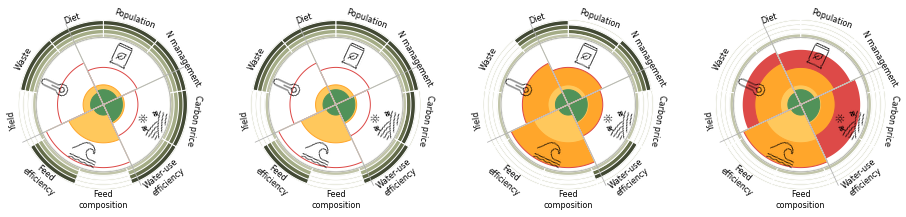

In [1229]:
import math
from textwrap import wrap
import matplotlib.image as mpimg
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from scipy import interpolate, ndimage



# Create the figure
fig = plt.figure(figsize=(15.7, 15.7))

'''# Set up the grid
width_ratios = [1 ,1]
grid = plt.GridSpec(2, 2, hspace=.01, wspace=.01, height_ratios= [1, 1])

axes = {}
# Create the subplots for the bar polar charts
for i in range(2):
    for j in range(2):
        axes[i,j] = fig.add_subplot(grid[i,j], projection='polar')'''

# Set up the grid
grid = plt.GridSpec(1, 4, wspace=.3)

axes = {}
# Create the subplots for the bar polar charts
for i in range(4):
    axes[i] = fig.add_subplot(grid[0,i], projection='polar')
        

for c, colour in enumerate(['GREEN', 'YELLOW', 'ORANGE', 'RED']): # the colours here don't represent the risk colour in the original data, they represent very high risk, High risk, Moderate risk, and Safe'
        
    # Set the zero location of theta
    axes[c].set_theta_zero_location("N", offset=-20)

    # Draw the outer solution bars
    sol_bar_label = solutions # Set the labels for the outer layer (solutions)
    N1 = len(sol_bar_label) # the numbre of solutions
    theta1 = np.linspace(0, 2 * np.pi, N1, endpoint=False)
    width1 = 2*np.pi/N1

    # Solution ring for highly ambitous level
    values1 = list(pd_scenario_rep_sol_q[colour].iloc[0])
    axes[c].bar(theta1, values1, width=width, bottom=5.0, color='#414833',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for ambitous level
    values = [x-.33 if x > 0.25 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.0, color='#656d4a',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for BAU level
    values = [x-.66 if x > 0.6 else 0 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.0, color='#a4ac86',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for low ambitous level
    values = [x-.99 if x > 0.95 else .26 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.0, color='#c2c5aa',
                   edgecolor='white',zorder=1,alpha=1)
    
    # Draw the boundary frane for solution bars
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=6.23, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.89, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.56, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=5.23, color='#c2c5aa',
                   edgecolor='white',zorder=-1, alpha=1)
    values = [.1 for x in values1]
    axes[c].bar(theta1, values, width=width, bottom=4.9, color='#c2c5aa',
                   edgecolor='white', zorder=-1, alpha=1)
    
    
       

    # Draw the inner boundary bars
    bon_bar_label = boundaries # Set the labels for the inner layer (boundaries)
    N2 = len(bon_bar_label) # the numbre of boundaries
    theta2 = np.linspace(0, 2 * np.pi, N2, endpoint=False)
    width2 = 2*np.pi/N2
   
     
    wedge_colours_temp = risk_col_list[colour]
    boundary_colour = {'Biogeochemical_Flows': '#9B3675', 'Climate_Change':'#185ADB', 
                   'Freshwater_Use':'#009DAE', 'Land_system_change':'#4AA96C'}
    #wedge_colours = [risk_colour[wedge_colours_temp[i]] for i in range(len(wedge_colours_temp))]
    
    
    # Wedges filled colour - predicted avg list(boundary_colour.values()
    values = pred_avg_norm[colour]
    
    col_r = []
    col_o = []
    col_y = []
    col_g = []
    for v, val in enumerate(values):
        if val > bound_max_norm[colour][v]: #red
            col_r.append('#DD4A48') #red
            col_o.append('#FFA62B') #orange
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif (val > bound_mode_norm[colour][v]) & (val <= bound_max_norm[colour][v]): #orange
            col_o.append('#FFA62B') #orange
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif (val > bound_min_norm[colour][v]) & (val <= bound_mode_norm[colour][v]): # yellow
            col_y.append('#FFC85C') #yellow
            col_g.append('#519259') #green
        elif val <= bound_min_norm[colour][v]: #green
            col_g.append('#519259') #green
        else:
            col_r.append((.1,.2,.1, 0))
            col_o.append((.1,.2,.1, 0))
            col_y.append((.1,.2,.1, 0))
            col_g.append((.1,.2,.1, 0))
    
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color=col_r,
                   edgecolor='none',zorder=1)
    axes[c].bar(theta2, bound_max_norm[colour], width=width2, bottom=0.0, color=col_o,
                   edgecolor='none',zorder=1) 
    axes[c].bar(theta2, bound_mode_norm[colour], width=width2, bottom=0.0, color=col_y,
                   edgecolor='none',zorder=1) 
    axes[c].bar(theta2, bound_min_norm[colour], width=width2, bottom=0.0, color=col_g,
                   edgecolor='none',zorder=1) 
   
 
    
    # Wedges filled colour - boundary mode
    values = bound_mode_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#FFA62B',zorder=1,alpha=1)
    # Wedges filled colour - boundary min
    values = bound_min_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#519259',zorder=1,alpha=1)
    # Wedges filled colour - boundary max
    values = bound_max_norm[colour]
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#DD4A48',zorder=1,alpha=1)


    
    # Wedges border colour
    values = [5, 5, 5, 5] # max normalised values of 'Nfert', 'DirNonCO2', 'WaterUse', 'TotalAgArea'.
    axes[c].bar(theta2, values, width=width2, bottom=0.0, color='none',
                   edgecolor='#e6e8d5',zorder=1,alpha=1)
    


    

    
    # Annotate the solution and boundary label
    
    # Find the right angle for solution labels
    solution_angle = [math.degrees(theta1[i])-20 for i in range(9)]
    
    for n in range(N):
        if n == 4:  # This condition is to adjust the solution label only
            axes[c].text(theta1[n], 7.1, 'Feed\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 5:
            axes[c].text(theta1[n], 7.1, 'Feed\ncomposition', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 6:
            axes[c].text(theta1[n], 7.1, 'Water-use\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta1[n], 6.8, solutions_name[solutions[n]], rotation=solution_angle[n],
                horizontalalignment='center', verticalalignment='center', fontsize=8)
            
            
    '''for n in range(N2):
        if n == 0:  # This condition is to adjust the solution label only
            axes[c].text(theta2[n], 3, 'Biogeochemical\nFlows', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 1:
            axes[c].text(theta2[n], 3, 'Climate\nChange', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 2:
            axes[c].text(theta2[n], 3, 'Freshwater\nUse', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta2[n], 3, 'Land System\nChange', rotation=0,
                horizontalalignment='center', verticalalignment='center', fontsize=8)'''

    
    # Adjust the grids
    axes[c].spines['polar'].set_visible(False)
    #axes[c].grid(True)
    # Calculate the degree of theta grids from radians
    grid_angle = [math.degrees(theta2[i])+45 for i in range(4)]  
    axes[c].set_thetagrids(grid_angle, [], visible=True)
    axes[c].set_rgrids([0, 5], [], visible=True)
    
    
    # Print the PB icon
    img_dir = 'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/PB_icons/'
    
    # Find the right angle for solution labels
    solution_angle = [math.degrees(theta2[i])-45 for i in range(4)]
    for b, bound in enumerate(boundaries):
        img = mpimg.imread(img_dir+bound+'.png')
        image_arr = np.array(img) # Conversaion to array is to be able to rotate image with Scipy later
        if b == 0:  # This condition is to adjust the icon position only / biogeochemical
            # Rotate image
            image_arr = ndimage.rotate(image_arr, solution_angle[b]+20, reshape=True)
            imagebox = OffsetImage(image_arr, zoom=1)
            ab = AnnotationBbox(imagebox, (theta2[b], 3.9), xycoords='data',  frameon=False) # the XY in annotation is based on theta (0-360) and r
        elif b == 1: # climate
            # Rotate image
            image_arr = ndimage.rotate(image_arr, solution_angle[b]+20, reshape=True)
            imagebox = OffsetImage(image_arr, zoom=1)
            ab = AnnotationBbox(imagebox, (theta2[b], 3.9), xycoords='data', frameon=False)
        elif b == 2: # water
            # Rotate image
            image_arr = ndimage.rotate(image_arr, solution_angle[b]+20+180, reshape=True)
            imagebox = OffsetImage(image_arr, zoom=1)
            ab = AnnotationBbox(imagebox, (theta2[b], 3.8), xycoords='data', frameon=False)
        else: # land system
            # Rotate image
            image_arr = ndimage.rotate(image_arr, solution_angle[b]+20+180, reshape=True)
            imagebox = OffsetImage(image_arr, zoom=1)
            ab = AnnotationBbox(imagebox, (theta2[b], 3.8), xycoords='data', frameon=False)  
        
        axes[c].add_artist(ab)


    
    '''# Draw the red, orange, yellow, and green shaded areas inside the polar plot.
    theta3 = np.linspace(0.0, 2 * np.pi, 1000, endpoint=True)
    r = 0+0*theta3
    r2 = 1 + 0*theta3
    r3 = 2 + 0*theta3
    r4 = 3 + 0*theta3
    r5 = 4 + 0*theta3
    #axes[y,t].plot(theta_2, r, lw=.1, color='none')
    axes[c].plot(theta3, r2, lw=.1, color='green',alpha=.5,zorder=-100)
    axes[c].plot(theta3, r3, lw=.1, color='#fddb3a',alpha=.5,zorder=-100)
    axes[c].plot(theta3, r4, lw=.1,color='#eb8242',alpha=.5,zorder=-100)
    axes[c].plot(theta3, r5, lw=.1,color='red',alpha=.5)
    axes[c].fill_between(theta3, r, r2, fc='green', alpha=0.5,ec='none',zorder=-100)
    axes[c].fill_between(theta3, r2, r3, fc='#fddb3a', alpha=0.5,ec='none',zorder=-100)
    axes[c].fill_between(theta3, r3, r4, fc='#eb8242',alpha=0.5,ec='none',zorder=-100)
    axes[c].fill_between(theta3, r4, r5, fc='red',alpha=0.5, ec='none', zorder=-100)'''

#plt.savefig('{}/Polar_Barchart_300dpi.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=300,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.pdf'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 
#plt.savefig('{}/Polar_Barchart.png'.format(r'N:/Planet-A/Current-Users/Enayat-Moallemi/Food_Meta_analysis/Figs/'), dpi=600,  bbox_inches='tight') 






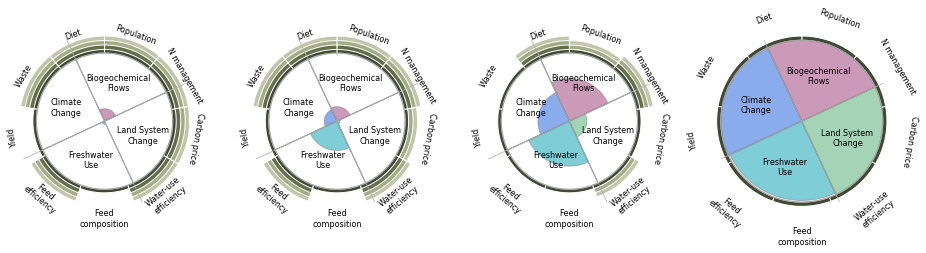

In [1049]:
import math
from textwrap import wrap

# Create the figure
fig = plt.figure(figsize=(15.7, 15.7))

'''# Set up the grid
width_ratios = [1 ,1]
grid = plt.GridSpec(2, 2, hspace=.01, wspace=.01, height_ratios= [1, 1])

axes = {}
# Create the subplots for the bar polar charts
for i in range(2):
    for j in range(2):
        axes[i,j] = fig.add_subplot(grid[i,j], projection='polar')'''

# Set up the grid
grid = plt.GridSpec(1, 4, wspace=.3)

axes = {}
# Create the subplots for the bar polar charts
for i in range(4):
    axes[i] = fig.add_subplot(grid[0,i], projection='polar')
        

for c, colour in enumerate(['GREEN', 'YELLOW', 'ORANGE', 'RED']): # the colours here don't represent the risk colour in the original data, they represent very high risk, High risk, Moderate risk, and Safe'
        
    # Set the zero location of theta
    axes[c].set_theta_zero_location("N", offset=-20)

    # Draw the outer solution bars
    sol_bar_label = solutions # Set the labels for the outer layer (solutions)
    N1 = len(sol_bar_label) # the numbre of solutions
    theta1 = np.linspace(0, 2 * np.pi, N1, endpoint=False)
    values1 = list(pd_scenario_rep_sol_q[colour].iloc[0])
    width1 = 2*np.pi/N1

    # Solution ring for highly ambitous level
    axes[c].bar(theta1, values1, width=width, bottom=5.0, color='#c2c5aa',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for ambitous level
    values12 = [x-.33 if x > 0.25 else 0 for x in values1]
    axes[c].bar(theta1, values12, width=width, bottom=5.0, color='#a4ac86',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for BAU level
    values13 = [x-.66 if x > 0.6 else 0 for x in values1]
    axes[c].bar(theta1, values13, width=width, bottom=5.0, color='#656d4a',
                   edgecolor='white',zorder=1,alpha=1)
    # Solution ring for low ambitous level
    values14 = [x-.99 if x > 0.95 else .26 for x in values1]
    axes[c].bar(theta1, values14, width=width, bottom=5.0, color='#414833',
                   edgecolor='white',zorder=1,alpha=1)
    
    
       

    # Draw the inner boundary bars
    bon_bar_label = boundaries # Set the labels for the inner layer (boundaries)
    N2 = len(bon_bar_label) # the numbre of boundaries
    theta2 = np.linspace(0, 2 * np.pi, N2, endpoint=False)
    values2 = risk_list[colour]
    width2 = 2*np.pi/N2
   
    values3 = [5,5,5,5]
    wedge_colours_temp = risk_col_list[colour]
    boundary_colour = {'Biogeochemical_Flows': '#9B3675', 'Climate_Change':'#185ADB', 
                   'Freshwater_Use':'#009DAE', 'Land_system_change':'#4AA96C'}
    #wedge_colours = [risk_colour[wedge_colours_temp[i]] for i in range(len(wedge_colours_temp))]
    # Wedges border colour
    axes[c].bar(theta2, values3, width=width2, bottom=0.0, color='white',
                   edgecolor='grey',zorder=1,alpha=.9)
    
    # Wedges filled colour
    axes[c].bar(theta2, values2, width=width2, bottom=0.0, color=list(boundary_colour.values()),
                   edgecolor='grey',zorder=1,alpha=.5)
    
    # Annotate the solution and boundary label
    
    # Find the right angle for solution labels
    solution_angle = [math.degrees(theta1[i])-20 for i in range(9)]
    
    for n in range(N):
        if n == 4:  # This condition is to adjust the solution label only
            axes[c].text(theta1[n], 7.1, 'Feed\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 5:
            axes[c].text(theta1[n], 7.1, 'Feed\ncomposition', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 6:
            axes[c].text(theta1[n], 7.1, 'Water-use\nefficiency', rotation=solution_angle[n]+180,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta1[n], 6.8, solutions_name[solutions[n]], rotation=solution_angle[n],
                horizontalalignment='center', verticalalignment='center', fontsize=8)
            
            
    for n in range(N2):
        if n == 0:  # This condition is to adjust the solution label only
            axes[c].text(theta2[n], 3, 'Biogeochemical\nFlows', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 1:
            axes[c].text(theta2[n], 3, 'Climate\nChange', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
        elif n == 2:
            axes[c].text(theta2[n], 3, 'Freshwater\nUse', rotation=0,
                    horizontalalignment='center', verticalalignment='center', fontsize=8)
            
        else:
            axes[c].text(theta2[n], 3, 'Land System\nChange', rotation=0,
                horizontalalignment='center', verticalalignment='center', fontsize=8)

    
    # Adjust the grids
    axes[c].spines['polar'].set_visible(False)
    #axes[c].grid(True)
    # Calculate the degree of theta grids from radians
    grid_angle = [math.degrees(theta2[i])+45 for i in range(4)]  
    axes[c].set_thetagrids(grid_angle, [], visible=True)
    axes[c].set_rgrids([0, 5], [], visible=True)

    
    '''# Draw the red, orange, yellow, and green shaded areas inside the polar plot.
    theta3 = np.linspace(0.0, 2 * np.pi, 1000, endpoint=True)
    r = 0+0*theta3
    r2 = 1 + 0*theta3
    r3 = 2 + 0*theta3
    r4 = 3 + 0*theta3
    r5 = 4 + 0*theta3
    #axes[y,t].plot(theta_2, r, lw=.1, color='none')
    axes[c].plot(theta3, r2, lw=.1, color='green',alpha=.5,zorder=-100)
    axes[c].plot(theta3, r3, lw=.1, color='#fddb3a',alpha=.5,zorder=-100)
    axes[c].plot(theta3, r4, lw=.1,color='#eb8242',alpha=.5,zorder=-100)
    axes[c].plot(theta3, r5, lw=.1,color='red',alpha=.5)
    axes[c].fill_between(theta3, r, r2, fc='green', alpha=0.5,ec='none',zorder=-100)
    axes[c].fill_between(theta3, r2, r3, fc='#fddb3a', alpha=0.5,ec='none',zorder=-100)
    axes[c].fill_between(theta3, r3, r4, fc='#eb8242',alpha=0.5,ec='none',zorder=-100)
    axes[c].fill_between(theta3, r4, r5, fc='red',alpha=0.5, ec='none', zorder=-100)'''


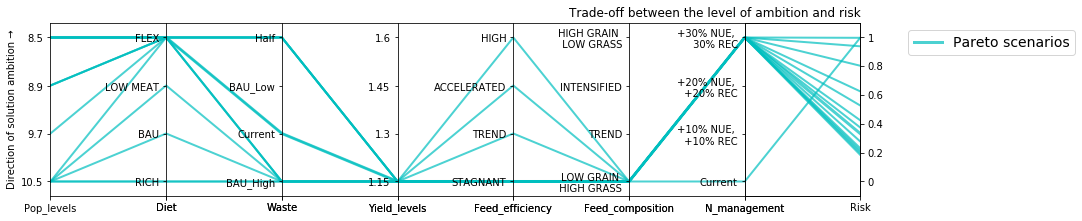

In [118]:
from matplotlib import ticker
from textwrap import wrap

# Create a copy of all scenarios and pareto scenarios for parallel coordinate and drop unused columns
pd_p_front_copy = pd_p_front['Biogeochemical_Flows'].copy()
temp_results_dict_copy  = temp_results_dict['Biogeochemical_Flows'].copy()
for s, solution in enumerate(solutions):
    if solution in list(temp_results_dict['Biogeochemical_Flows']):
        for l in list(ref_levels[solution]):
            dev = list(ref_levels.loc[ref_levels[solution] == l]['Trend_deviation'])[0]
            normalised_dev = (dev-(-1))/3 # All values in all_soln are normalized by subtracting the minimum value from each objective. Therefore [-1, 0, 1, 2] converts into [0, .33, .66, 1] 
                                          #then dividing it by the range of values for that objective. Normalisation is important because to have comparable axes later in the plot. risk range is [0,1] whereas solution range is [-1, 2]
            pd_p_front_copy[solution] = np.where(pd_p_front_copy[solution] == l, normalised_dev, pd_p_front_copy[solution])
            temp_results_dict_copy[solution] = np.where(temp_results_dict_copy[solution] == l, normalised_dev, temp_results_dict_copy[solution])

drop_list = ['Indicator', 'Pred_avg','Pred_upr','Pred_lwr','Min','Mode','Max','RiskCol', 'Safe', 'Trend_deviation']
pd_p_front_copy = pd_p_front_copy.drop(drop_list, axis=1)
temp_results_dict_copy = temp_results_dict_copy.drop(drop_list, axis=1)


# Set data
all_soln = temp_results_dict_copy.to_numpy()
nd_indices = pd_p_front_copy.to_numpy()
 
# Identify and list the objectives of the reference set
objs = ['Pop_levels',
 'Diet',
 'Waste',
 'Yield_levels',
 'Feed_efficiency',
 'Feed_composition',
 'N_management',
 'Risk']
 
# Create an array of integers ranging from 0 to the number of objectives                    
x = [i for i, _ in enumerate(objs)]
 
# sharey=False indicates that all the subplot y-axes will be set to different values
fig, ax  = plt.subplots(1,len(x)-1, sharey=False, figsize=(15,3))



# Iterate through all the axes in the figure and plot each non pareto scenario
'''for i, ax_i in enumerate(ax):
    for d in range(len(all_soln)):
        if ((d in nd_indices)== False):
            if (d == 0):
                ax_i.plot(objs, all_soln[d, :], color='lightgrey', alpha=0.3, label='Dominated', linewidth=3)
            else:
                ax_i.plot(objs, all_soln[d, :], color='lightgrey', alpha=0.3, linewidth=3)
    ax_i.set_xlim([x[i], x[i+1]])'''

# Iterate through all the axes in the figure and plot each pareto scenario
for i, ax_i in enumerate(ax):
    for d in range(len(nd_indices)):
        if (d == 0):
            ax_i.plot(objs, nd_indices[d, :], scaley=True, color='c', alpha=0.7, label='Pareto scenarios', linewidth=3)
        else:
            ax_i.plot(objs, nd_indices[d, :], scaley=True, color='c', alpha=0.7, linewidth=2)
   
    ax_i.set_xlim([x[i], x[i+1]])
        
    
    
# To drop unused ref solution levels in each boundary
ref_levels_copy = ref_levels.copy()
for s in list(ref_levels_copy):
    if s not in list(temp_results_dict_copy):
        ref_levels_copy = ref_levels_copy.drop(s, axis=1)
# Correct x axis labels for plotting
ref_levels_copy['Pop_levels'] = ['10.5', '9.7', '8.9', '8.5']
ref_levels_copy['Feed_composition'] = ['LOW GRAIN \n HIGH GRASS', 'TREND', 'INTENSIFIED', 'HIGH GRAIN \n LOW GRASS']
ref_levels_copy['N_management'] = ['Current', '+10% NUE, \n +10% REC', '+20% NUE, \n +20% REC', 
                                   '+30% NUE, \n 30% REC']
        
        
# Iterate over and label y axes and set them according to the ref levels
for i, ax_i in enumerate(ax):
    if i<7:
        ticks = [0, .33, .66, 1]
        tick_labels = ref_levels_copy.iloc[:, i].tolist()
        ax_i.yaxis.set_ticks(ticks)
        ax_i.set_yticklabels(tick_labels)
        ax_i.margins(y=.1)

        
# Create a twin axis on the last axis in ax
ax2 = plt.twinx(ax[-1])
ax2.xaxis.set_major_locator(ticker.FixedLocator([x[-2], x [-1]]))
ticks = np.arange (0, 1.1, .2).tolist()
tick_labels = [0, .2, .4, .6, .8, 1]
ax2.yaxis.set_ticks(ticks)
ax2.set_yticklabels(tick_labels)
ax2.set_xticklabels([objs[-2], objs[-1]])
ax2.margins(y=.1)

# Plot the figure
plt.subplots_adjust(wspace=0, hspace=0.2, left=0.1, right=0.85, bottom=0.1, top=0.9)
ax[6].legend(bbox_to_anchor=(1.35, 1), loc='upper left', prop={'size': 14})
ax[0].set_ylabel(u"Direction of solution ambition \u2192", fontsize=10)
plt.title("Trade-off between the level of ambition and risk", loc='right', fontsize=12)
#plt.savefig("PCP_example.png")
plt.show()

In [107]:
ref_levels_copy['Pop_levels'] = ['10.5', '9.7', '8.9', '8.5']
ref_levels_copy['Feed_composition'] = ['LOW GRAIN \n HIGH GRASS', 'TREND', 'INTENSIFIED', 'HIGH GRAIN \n LOW GRASS']
ref_levels_copy['N_management'] = ['Current', '+10% NUE, \n +10% REC', '+20% NUE, \n +20% REC', 
                                   '+30% NUE, \n 30% REC']